# Imports

In [3]:
import math
import inflection
import pandas as pd 
import numpy as np
import seaborn as sns
import datetime as dt
import xgboost as xgb
import random
import pickle

from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image
from tabulate              import tabulate
from scipy                 import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from datetime              import timedelta
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso



## Helper Functions

In [4]:
#Trazer para cá funçÕes exibida na Aula 34 - Aplicando o Cross-Validation - 1:34min.
#cross_validation
#mean_absolute_percentage_error
#ml_error
#cramer_v
#jupyter_settings
def jupyter_settings():
    """ Otimiza configurações gerais, padronizanod tamanhos de plots, etc """
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 10)
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/Users/home/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Loading Data

In [2]:
                            # lê todo o arquivo de uma vez 
df_sales_raw = pd.read_csv("../data/train.csv", low_memory=False)
df_store_raw = pd.read_csv("../data/store.csv", low_memory=False)

# merge
df_raw = pd.merge(  df_sales_raw, df_store_raw, how='left', on='Store' )

In [20]:
df_raw.sample(20)
#Minha granularidade é: valore de vendas por dia e por loja

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
134967,53,3,2015-04-01,9112,783,1,1,0,1,a,c,30360.0,9.0,2013.0,0,NaN,NaN,NaN
919039,1065,6,2013-03-30,3247,410,1,0,0,0,a,a,1290.0,NaN,NaN,1,35.0,2011.0,"Mar,Jun,Sept,Dec"
592408,14,4,2014-01-16,4054,544,1,0,0,0,a,a,1300.0,3.0,2014.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
499929,80,3,2014-04-09,5195,454,1,0,0,0,d,a,7910.0,NaN,NaN,0,NaN,NaN,NaN
629169,1095,7,2013-12-15,0,0,0,0,0,0,a,a,690.0,6.0,2007.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
96530,641,3,2015-05-06,5811,482,1,1,0,0,a,c,610.0,12.0,2003.0,1,36.0,2013.0,"Mar,Jun,Sept,Dec"
691185,671,7,2013-10-20,0,0,0,0,0,0,a,c,2070.0,2.0,2008.0,1,39.0,2010.0,"Jan,Apr,Jul,Oct"
354380,235,3,2014-08-27,3863,350,1,0,0,1,a,a,5710.0,3.0,2012.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"
730065,526,7,2013-09-15,0,0,0,0,0,0,a,a,120.0,NaN,NaN,1,48.0,2011.0,"Mar,Jun,Sept,Dec"
108329,175,6,2015-04-25,5494,716,1,0,0,0,c,a,4130.0,NaN,NaN,0,NaN,NaN,NaN


# Passo 1 - Data Description

In [819]:
df1[df1['store'] == 1 ]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1115,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
2230,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
3345,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
4460,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011635,1,6,2013-01-05,4997,635,1,0,0,1,c,a,1270.0,9,2008,0,1,2013,0,Jan,0
1012750,1,5,2013-01-04,4486,619,1,0,0,1,c,a,1270.0,9,2008,0,1,2013,0,Jan,0
1013865,1,4,2013-01-03,4327,578,1,0,0,1,c,a,1270.0,9,2008,0,1,2013,0,Jan,0
1014980,1,3,2013-01-02,5530,668,1,0,0,1,c,a,1270.0,9,2008,0,1,2013,0,Jan,0


In [4]:
# Meigarom faz uma cópia a cada seção nova, pra em grandes códigos evitar sobrescrever a var
# do DS original e ter que rodar tudo de novo.
df1 = df_raw.copy()

## Rename Columns

In [5]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
#pega as colunas originais
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

In [7]:
#cria função pra transformar em snake_case
snakecase = lambda x: inflection.underscore ( x )

#aplica a função em todas as palabras de cols_old, guarda em lista na cols_new
cols_new = list( map( snakecase, cols_old ) )

#rename
df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## Data Dimension

In [9]:
print (f'Number of rows: {df1.shape[0] }')
print (f'Number of rows: {df1.shape[1] }')

Number of rows: 1017209
Number of rows: 18


## Data Types

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
#convert 'date' to datetime:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NA

In [12]:
# Ver todas linhas que tem ao menos 1 NA
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### Há 3 formas de tratar:
1 - Excluir todas as linhas com NA.
     - Bom: rápido e fácil
     - Péssimo: descarta dados, pode prejudicar meu modelo
    
2 - Usar algoritmos de ML pra substituir NAs pela média, mediana, prevendo o número que seria 
através das colunas que tem valor.

3 - Descobrir porque o NA tá aqui. Pode ter trocado o sistema, antes não tinha essa coluna. Ou ainda antes era o valor de outra coluna.

## Fillout NA

Colunas com NA:
-competition_distance
-competition_open_since_month
-competition_open_since_year
-promo2_since_week
-promo2_since_year
-promo_interval

In [13]:
#competition_distance
#CompetitionDistance - distance in meters to the nearest competitor store

# Vou assumir que os que não tem valor aqui, não tem competidores perto.
# Logo, vou atribuir pras NAs um valor bem amior que o maior valor de distância existente.
df1['competition_distance'].max()

75860.0

In [14]:
#atribuindo o valor pra todas NA

df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x ) 

In [15]:
#competition_open_since_month
# CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the
# nearest competitor was opened

# Se esta coluna está vazia, ou deve ser porque não tem competidor próximo, ou porque
# não sabem quando foi aberta. 
# Vou assumir nesse primeiro ciclo então minha data de venda como a data de abertura do 
# competidor, mesmo que seja simplista.

# precisa axis aqui pois são duas colunas que estamos mexendo no lambda
df1['competition_open_since_month'] = df1.apply ( lambda x: x['date'].month 
                    if math.isnan( x['competition_open_since_month'] ) 
                    else x['competition_open_since_month'], axis=1 ) 

In [16]:
#competition_open_since_year
# CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the
# nearest competitor was opened

# Vamos fazer pro year o mesno que o feito pro month:
df1['competition_open_since_year'] = df1.apply ( lambda x: x['date'].year 
                    if math.isnan( x['competition_open_since_year'] ) 
                    else x['competition_open_since_year'], axis=1 ) 

In [17]:
#promo2_since_week

# Promo2Since[Year/Week] - describes the year and calendar week when the store started 
#    participating in Promo2
#Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not
#    participating, 1 = store is participating

# promo2_since_week: Também vamos por hora setar a partir da data de venda
df1['promo2_since_week'] = df1.apply ( lambda x: x['date'].week 
                    if math.isnan( x['promo2_since_week'] ) 
                    else x['promo2_since_week'], axis=1 )

In [18]:
#promo2_since_year: Também vamos por hora setar a partir da data de venda
df1['promo2_since_year'] = df1.apply ( lambda x: x['date'].year 
                    if math.isnan( x['promo2_since_year'] ) 
                    else x['promo2_since_year'], axis=1 )

In [19]:
#promo_interval
# PromoInterval - describes the consecutive intervals Promo2 is started, naming the months 
# the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in 
# February, May, August, November of any given year for that store

#
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
 9: 'Sept', 10: 'Out', 11: 'Nov', 12: 'Dec' }

#preencher NA com zeros
#inplace=True pra não retornar valor, mas modificar na coluna
df1['promo_interval'].fillna(0, inplace=True)

#cria coluna 'month_map' e seta o mes nela
df1['month_map'] = df1['date'].dt.month.map( month_map )

#cria coluna 'is_promo', e seta 1 se 'month_map' estiver em 'promo_interval', senão 0.
#assim, consigo saber se naquela venda, estava ou não em promoção.
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply ( lambda x: 
      0 if x['promo_interval'] == 0 else 
      1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1 )

In [20]:
 df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
123610,961,7,2015-04-12,0,0,0,0,0,0,d,c,9430.0,4.0,2015.0,0,15.0,2015.0,0,Apr,0
228582,8,3,2015-01-07,7262,781,1,1,0,0,a,a,7520.0,10.0,2014.0,0,2.0,2015.0,0,Jan,0
37392,598,7,2015-06-28,0,0,0,0,0,0,c,a,550.0,12.0,2013.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",Jun,0
840104,180,6,2013-06-08,6654,878,1,0,0,0,d,a,5800.0,9.0,2010.0,0,23.0,2013.0,0,Jun,0
554815,331,3,2014-02-19,7575,989,1,1,0,0,a,c,670.0,2.0,2014.0,1,14.0,2015.0,"Jan,Apr,Jul,Oct",Feb,0


In [21]:
 df1.sample(5).T

,483739,398379,278513,294364,230093
store,615,300,69,16,404
day_of_week,4,5,7,4,2
date,2014-04-24 00:00:00,2014-07-11 00:00:00,2014-11-16 00:00:00,2014-10-30 00:00:00,2015-01-06 00:00:00
sales,7931,7124,0,7122,0
customers,1182,844,0,847,0
open,1,1,0,1,0
promo,0,0,0,0,1
state_holiday,0,0,0,0,a
school_holiday,1,0,0,1,0
store_type,d,a,c,a,a


In [22]:
#resolvido
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## Change Types

In [23]:
# Como fizemos alteração nas colunas, é importante conferir se não mudou o formato das colnas
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [24]:
#converter de float pra int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

In [25]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [26]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
523959,695,3,2014-03-19,5828,559,1,1,0,0,a,a,550.0,7,2011,1,1,2012,"Jan,Apr,Jul,Oct",Mar,0
818304,680,5,2013-06-28,5483,823,1,0,0,1,c,a,170.0,6,2013,1,35,2012,"Mar,Jun,Sept,Dec",Jun,1
229819,130,2,2015-01-06,5105,582,1,1,0,1,c,a,900.0,1,2015,1,13,2010,"Jan,Apr,Jul,Oct",Jan,1
164885,981,5,2015-03-06,8777,879,1,1,0,0,d,c,2620.0,11,2002,0,10,2015,0,Mar,0
564239,835,2,2014-02-11,3822,598,1,0,0,0,a,a,2890.0,12,2007,1,10,2014,"Mar,Jun,Sept,Dec",Feb,0


## Descriptive Statistical

Serve para 2 coisas:
 - 1  Termos alguma noção de negócios pelos dados
 - 2  Conseguirmos detectar alguns erros (venda negativa por ex..)

Métricas de tendência central: média e mediana (resumem dados em um único número)

Metricas de dispersão: desvio padrão, min, max, range, skew, kurtosis

In [27]:
#separa colunas numéricas e categóricas, pra aplicar a estatística em cada conjunto:
num_attributes = df1.select_dtypes ( include=['int64','float64'] )
cat_attributes = df1.select_dtypes ( exclude=['int64','float64','datetime64[ns]'] )

In [28]:
num_attributes.sample(5)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
264130,764,2,4851,480,1,1,0,26490.0,12,2014,1,10,2014,1
126964,970,4,2770,363,1,0,1,910.0,12,2014,1,37,2009,1
240892,928,6,6220,584,1,0,0,1090.0,12,2014,1,31,2013,0
446251,1037,3,6279,824,1,0,0,150.0,5,2014,0,22,2014,0
468176,662,4,9138,706,1,1,0,1070.0,5,2014,0,19,2014,0


In [29]:
cat_attributes.sample(5)

,state_holiday,store_type,assortment,promo_interval,month_map
656650,0,d,a,"Jan,Apr,Jul,Oct",Nov
214330,0,a,c,0,Jan
685742,0,d,a,"Mar,Jun,Sept,Dec",Out
926949,0,a,a,0,Mar
611518,0,d,a,"Feb,May,Aug,Nov",Dec


### Numerical Attibures

In [30]:
#Métricas de tendência central: média e mediana
ct1 = pd.DataFrame ( num_attributes.apply ( np.mean ) ).T
ct2 = pd.DataFrame ( num_attributes.apply ( np.median ) ).T

#Metricas de dispersão: desvio padrão, min, max, range, skew, kurtosis
d1 = pd.DataFrame ( num_attributes.apply ( np.std ) ).T
d2 = pd.DataFrame ( num_attributes.apply ( min ) ).T
d3 = pd.DataFrame ( num_attributes.apply ( max ) ).T
d4 = pd.DataFrame ( num_attributes.apply ( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame ( num_attributes.apply ( lambda x: x.skew() ) ).T
d6 = pd.DataFrame ( num_attributes.apply ( lambda x: x.kurtosis() ) ).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index() 
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

In [31]:
#Análise geral:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [32]:
#Anlálise de SALES

#Vou retirar as vendas = 0 pra analisar o gráfico mais limpo:
df_sales_pos = df1.loc[ df1['sales'] > 0 ]

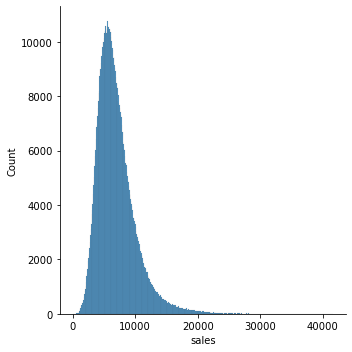

In [33]:
p = sns.displot ( df_sales_pos['sales'] )
#p.fig.set_dpi(100)
plt.show()

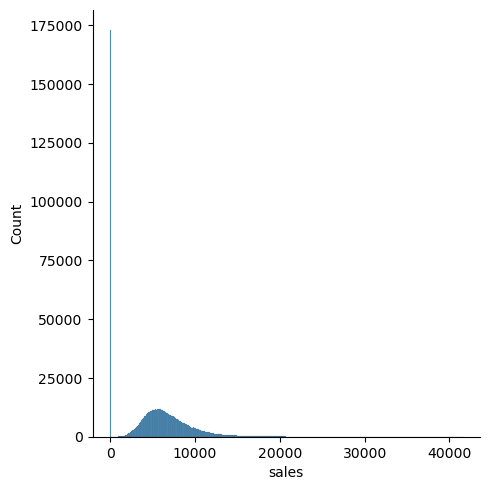

In [34]:
#Abaixo, ploto o gráfico do Sales original, porque o m que estou analistando 
# considera os zeros nas vendas também!
p = sns.displot ( df1['sales'] )
p.fig.set_dpi(100)
plt.show()

ANÁLISE SALES:

- Média e mediana bem próximas, não vai ter deslocamento da distribuição muito grande, vide skew.
- Skew 0.6 positivo (deslocamento leve para esquerda), mas bem próximo a zero, logo distribuição bem próxima de uma normal. 
- Kurtosis 1.77 positiva, próxima de 2, tem um pico grande.
- A média é de 5773 vendas/dia, e o std de 3850: Isto significa que em 78% dos dias (±1 std), temos entre 1923 (5773-3850) e 9.623 (5773+3850) vendas.

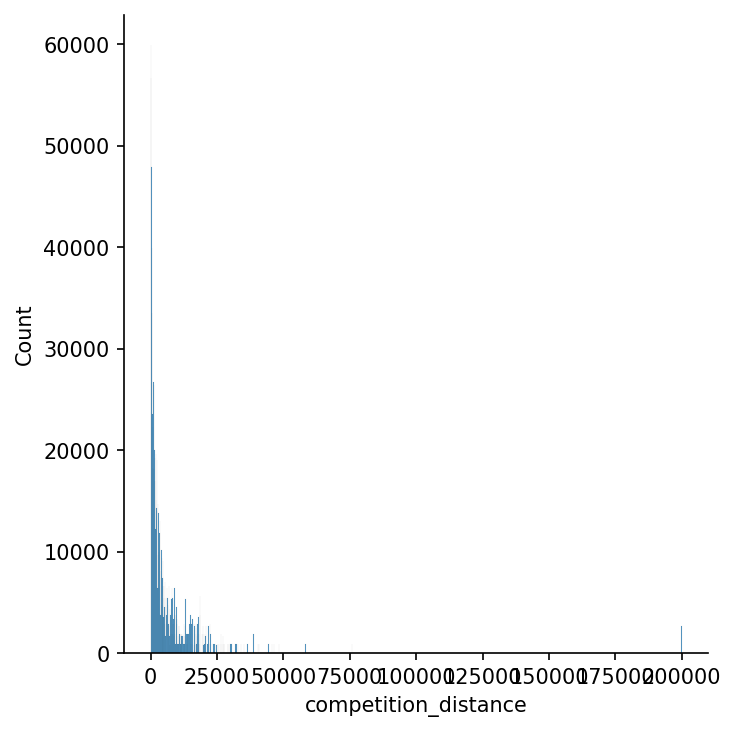

In [35]:
#Análise competition distance
p = sns.displot ( df1['competition_distance'] )
p.fig.set_dpi(150)
plt.show()

ANÁLISE COMPETITION DISTANDE:(apenas > 0):

- Média e mediana bem longe uma da outra, logo vai ter deslocamento da normal muito grande, 
vide skew.
- Skew 10.2 positiva (deslocamento enorme pra esquerda), indicando grande concentração de 
distâncias menores até os concorrentes.
- Kurtosis 147 positiva, indicando um pico gigantesco.

In [36]:
#Análise customers
#Vou retirar customers = 0 pra analisar o gráfico mais limpo:

df_cust_pos = df1.loc[ df1['customers'] > 0 ]

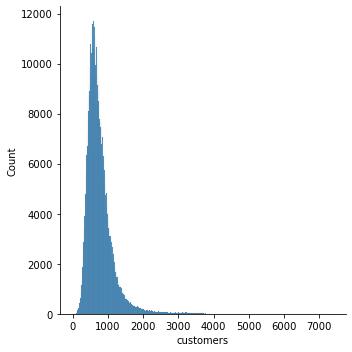

In [37]:
p = sns.displot ( df_cust_pos['customers'] )
#p.fig.set_dpi(150)
plt.show()

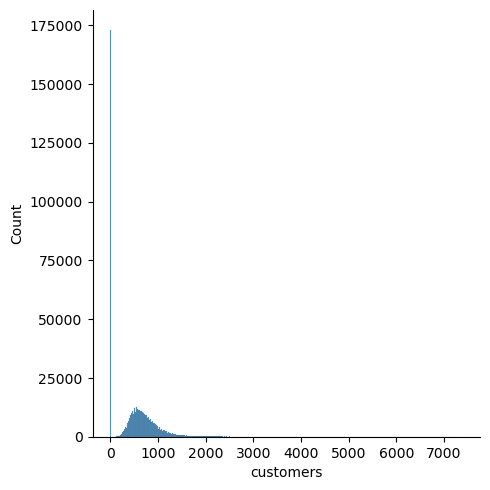

In [38]:
#Abaixo, ploto o gráfico do Customer original, porque o m que estou analistando 
# considera os zeros nos customers também!
p = sns.displot ( df1['customers'] )
p.fig.set_dpi(100)
plt.show()

ANÁLISE CUSTOMERS:

- Média (633) e mediana (609) próximas, mas mediana menor: deslocamento da curva levemente pra esquerda.

- Logo, skew levemente positiva, indicando maior concentração dos valores mais abaixo da média (ponto central).

- Kursosis de 7, logo pico muito alto /distribuição bem dispersa em número de clientes por dia.

- Std de 464, e média de clientes por dia de 633: em 78% dos dias (34% ref. 1 std positivo + 34% ref. 1 std negativo), tivemos entre 169 (633-464) e 1097 (633+464) clientes. 



In [39]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### Categorical Attibures

In [40]:
cat_attributes.apply ( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [41]:
df1['state_holiday'].value_counts()

0    986159
a     20260
b      6690
c      4100
Name: state_holiday, dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

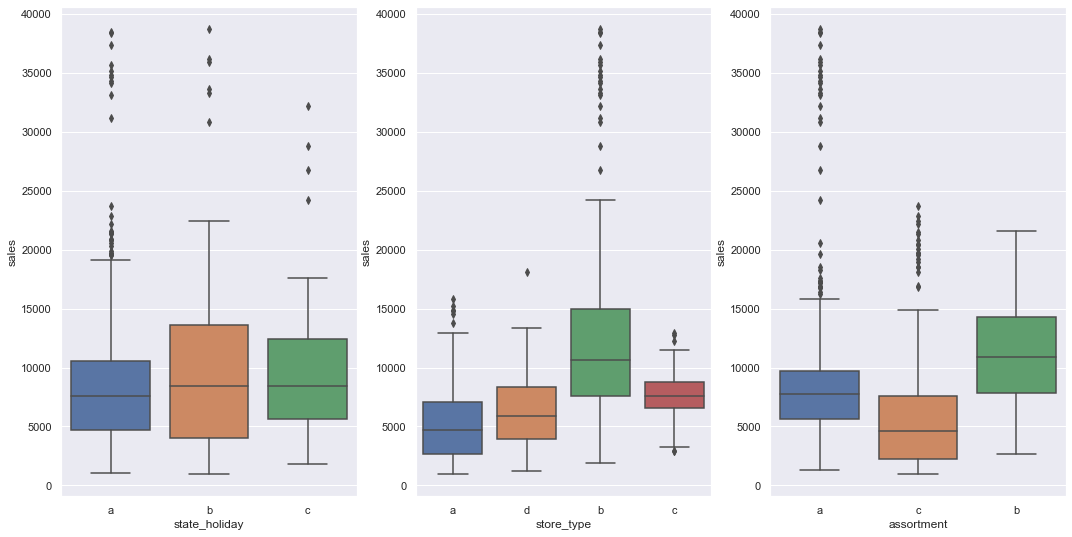

In [42]:
#Boxplot tem todas as medidas de dispersão e tendência central. Vamos usar ele.

#vendas nos feriados: remover dias não feriado e dias onde não teve vendas 
aux1 = df1[ (df1['state_holiday'] != '0') & (df1['sales'] > 0) ]

#setar tamanho:
sns.set(rc={'figure.figsize':(18,9)})

plt.subplot (1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot (1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot (1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1 )

Acima, a linha meio de cada imagem colorida é o 50º quartil, ou seja a mediana.
A borda da figura de baixo é o quartil 25, a de cima o 75.
Logo, dentro da imagem laranja, tenho o volume do quartil 25 ao 50, e do 50 ao 75. 
Fora da figura até os riscos superior e inferior é o valor mínimo e máximo.
Pontos após os riscos das bordas (valores máximos) são outliers: > 3 vezes o desvio padrão.

Logo, quanto mais achatada é a figura, maior a concentração em torno da mediana.

Análise do boxplot 1 - quantidade de vendas por tipo de feriado:

Legenda state_holiday: a = public holiday | b = Easter holiday |  c = Christmas

-A mediana de vendas de páscoa(b) e natal (c) é mais alta que de feriados publicos (a).

-A mediana de vendas de páscoa(b) e natal (c) é parecida, mas a dispersão é maior na páscoa.

Análise do boxplot 2 - quantidade de vendas por tipo de loja:
 
Legenda de StoreType - differentiates between 4 different store models: a, b, c, d
        
-Loja tipo b vende muito mais na mediana que as demais, aprox. o dobro da tipo a.

-Loja do tipo c tem concentração de vendas maior em torno da mediana.

Análise do boxplot 3 - quantidade de vendas por mix de produtos:

Legenda de Assortment - describes an assortment level: a = basic, b = extra, c = extended
        
-Há muito mais vendas do mix b do que dos demais. E o número de vendas varia mais também
neste mix.

-O mix A tem uma grande quantidade de outliers, mas uma distribuição bem uniforme fora isto.

In [66]:
#Save CSV:
df1.to_csv('1_data_description_done.csv', index=False) #index=False if I have first columns as index, to avoid saving with the unnamed:0. Don't save the index, and won't have column unnamed:0 created nor problem to load it.
#no import needed, no message will appear.

# Passo 2 - Feature Engeneering

In [53]:
df2 = df1.copy()

In [54]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0


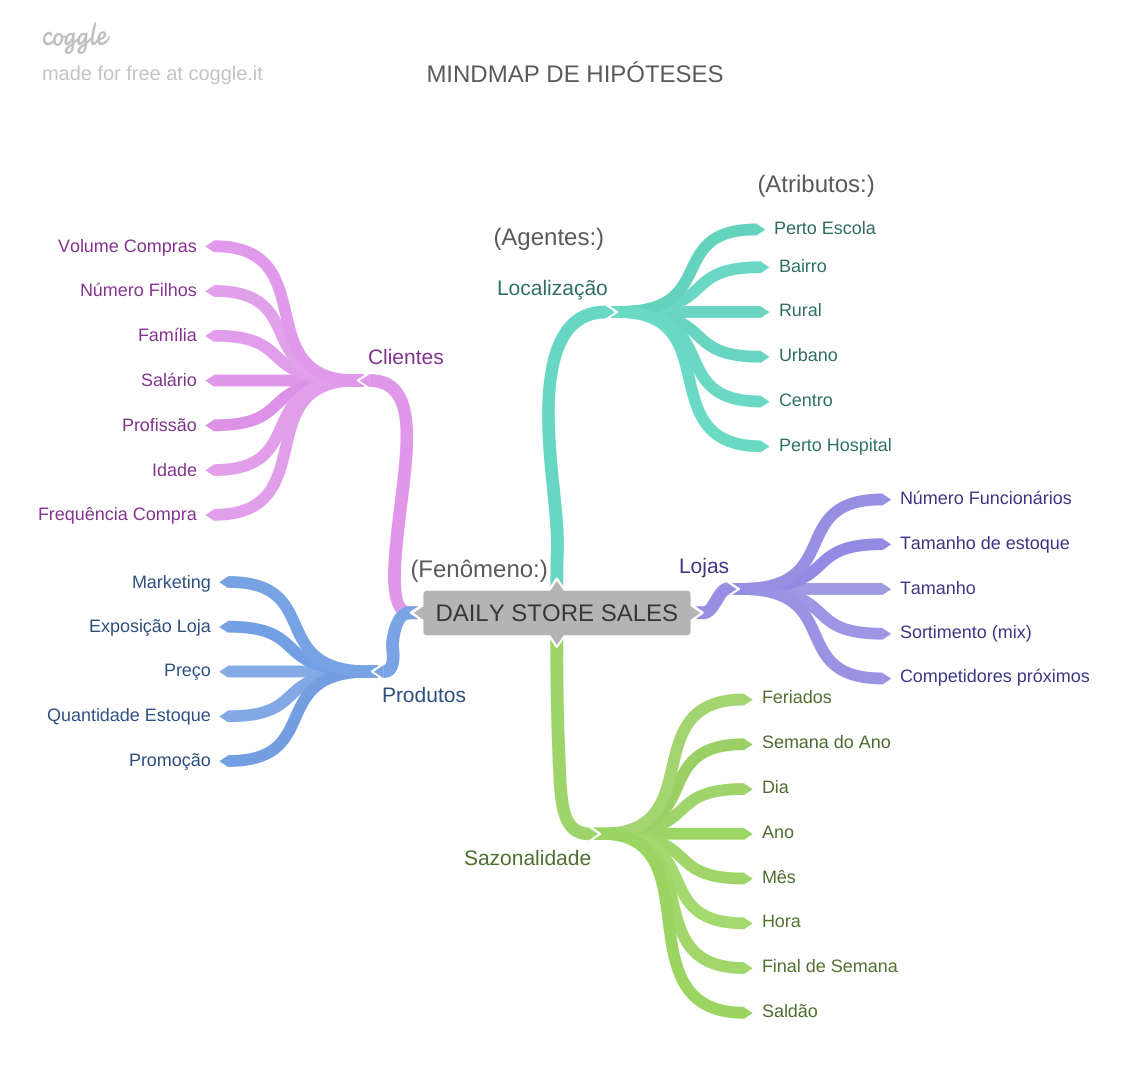

In [55]:
Image ('../img/MindMapHypothesis.png')

## Criação das Hipóteses

Hipóteses são Apostas.

Exemplos nesse contexto são:
- Lojas de MAIOR porte (atributo) deveriam vender (fenômeno) MAIS.
- Lojas com MAIOR sortimento (atributo) deveriam vender (fenômeno) MAIS.
- Lojas com MAIS competidores por perto (atributo) deveriam vender (fenômeno) MENOS.

Vamos agora criar hipóteses olhando para o mapa, relacionando o fenômeno e cada agente 
 e seus atributos:
        Na prática, isto é capturado em reunião de brainstorm com o time de negócio.
        Deixar claro que são apostas, e não são relações de causa e efeito, mas correlações:
            Isto porque estamos mapeando todos os atributos correlacionados com vendas, 
            e não há um único.

### Hipóteses Loja

#### Lojas com maior quadro de funcionários deveriam vender mais.

#### Lojas com maior estoque deveriam vender mais.

#### Lojas com maior porte deveriam vender mais.

#### Lojas com maior sortimento deveriam vender mais.

#### Lojas com competidores mais próximos deveriam vender menos.


#### Lojas com competidores à mais tempo deveriam vender mais.

### Hipóteses Produto

#### Lojas que investem mais em marketing deveriam vender mais.

#### Lojas com maior exposição de produto nas vitrines deveriam vender mais.

#### Lojas com produtos de preço menor deveriam vender mais.

#### Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

#### Lojas com promoções ativas por mais tempo deveriam vender mais.

#### Lojas com mais dias de promoção deveriam vender mais.

#### Lojas com mais promoções consecutivas deveriam vender mais.

### Hipóteses Sazonalidade

#### Lojas abertas duantes o feriado de natal deveriam vender mais.

#### Lojas deveriam vender mais ao longo dos anos.

#### Lojas deveriam vender no segundo semestre do ano.

#### Lojas deveriam vender mais no dia 10 de cada mês.

#### Lojas deveriam vender menos aos finais de semana.

#### Lojas deveriam vender menos durante os feriados escolares.

## Lista Final de Hipóteses (priorização)

Critério: tenho ou não o dado disponível agora?
    Se tenho, vou priorizar neste primeiro ciclo (listadas abaixo).
    Se não tenho, num ciclo futuro se necessário avalio coletar, conforme a performance do modelo.
    
   Cada hipótese vai gerar tabela, gráfico pra poder avaliar correlação com o fenômeno, como a força dessa correlação.

#### (H1 - loja) Lojas com maior sortimento deveriam vender mais.

#### (H2 - loja) Lojas com competidores mais próximos deveriam vender menos.


#### (H3 - loja) Lojas com competidores à mais tempo deveriam vender mais.

#### (H4 - prod) Lojas com promoções ativas por mais tempo deveriam vender mais.

#### (H5 - prod) Lojas com mais dias de promoção deveriam vender mais.

#### (H6 - prod) Lojas com mais promoções consecutivas deveriam vender mais.

#### (H7 - sazo) Lojas abertas duantes o feriado de natal deveriam vender mais.

#### (H8 - sazo) Lojas deveriam vender mais ao longo dos anos.

#### (H9 - sazo) Lojas deveriam vender mais no segundo semestre do ano.

#### (H10 - sazo) Lojas deveriam vender mais depois do dia 10 de cada mês.

#### (H11 - sazo) Lojas deveriam vender menos aos finais de semana.

#### (H12 - sazo) Lojas deveriam vender menos durante os feriados escolares.

## Feature Engeneering

Aqui, vou criar as variáveis que preciso derivar pra depois validar as hipóteses:

-year
-Month
-day
-week_of_year
-year_week

-competition_since - da data da compra, há quanto tempo tenho competidores
    juntar: competition_open_since_month + competition_open_since_year e pegar a diferença até date.

-promo_since - desde quando tenho a promoção ativa
    tenho promo2_since_week (semana do ano) e promo2_since_year, vou criar a partir deles
    
-assortment - trocar letras a b e c pelo mix de produtos
-state_holiday - trocar letras a b c pelo nome por extenso

In [56]:
df2.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
428796,307,4,2014-06-12,2959,386,1,0,0,0,a,a,18660.0,9,2002,0,24,2014,0,Jun,0


In [57]:
#year
df2['year'] = df2['date'].dt.year
#Month
df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
#week_of_year
df2['week_of_year'] = df2['date'].dt.weekofyear
#year_week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

<ipython-input-57-ab48e93f898e>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [58]:
#competition_since - da data da compra, há quanto tempo tenho competidores
    # juntar: competition_open_since_month + competition_open_since_year e pegar a diferença 
    # até date.
    
#criar um datetime contendo dia 1, e pegando o mês e ano:
df2['competition_since'] = df2.apply (lambda x: dt.datetime (year=x['competition_open_since_year'], 
                   month=x['competition_open_since_month'], day=1 ), axis=1)
#cria coluna em meses desde que a competição começou:  
df2['competition_time_month'] = ( (df2['date'] - df2['competition_since']) / 30 ).apply (lambda x: x.days).astype ( int )

In [59]:
#promo_since - desde quando tenho a promoção ativa
    #tenho promo2_since_week (semana do ano) e promo2_since_year (ano), 
    #vou criar a partir deles nova string concatenando ambas pra ficar assim:'2015-31':
df2['promo2_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
    #agora, converter essa string em data: ('%Y-%W-$w') -> ano, semana do ano, inicia domingo.
df2['promo2_since'] = df2['promo2_since'].apply \
    ( lambda x: dt.datetime.strptime( x + '-1', '%Y-%W-%w' ) - dt.timedelta( days=7 ) )         
    #agora tendo as duas datas, subtrai venda - data de início da promoção, pra obter 
    #o tempo que a promoção ficou ativa ativa em semanas
df2['promo2_time_week'] = ( ( df2['date'] - df2['promo2_since'] ) / 7).apply \
                           ( lambda x: x.days ).astype (int)

In [60]:
#assortment - trocar letras a b e c pelo mix de produtos:
    #Assortment - describes an assortment level: a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply ( lambda x: 
                               'basic' if x == 'a' else
                               'extra' if x == 'b' else 
                            'extended' if x == 'c' else x) 

In [61]:
df2['assortment'].value_counts()

basic       537445
extended    471470
extra         8294
Name: assortment, dtype: int64

In [62]:
#state_holiday - trocar letras a b c pelo nome por extenso
    #StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are 
    #closed on state holidays. Note that all schools are closed on public holidays and 
    #weekends. a = public holiday, b = easter_holiday, c = christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply ( lambda x: 
                                'public_holiday' if x == 'a' else
                                'easter_holiday' if x == 'b' else
                                     'christmas' if x == 'c' else 
                                   'regular_day' )

In [63]:
df2['state_holiday'].value_counts()

regular_day       986159
public_holiday     20260
easter_holiday      6690
christmas           4100
Name: state_holiday, dtype: int64

In [64]:
df2.sample(5).T

,894108,682012,263007,718199,828309
store,664,418,533,925,650
day_of_week,7,1,3,4,3
date,2013-04-21 00:00:00,2013-10-28 00:00:00,2014-12-03 00:00:00,2013-09-26 00:00:00,2013-06-19 00:00:00
sales,0,3677,13683,5326,6358
customers,0,434,1065,1020,693
open,0,1,1,1,1
promo,0,0,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,1,0,0,0
store_type,d,a,a,c,a


In [67]:
#Save CSV:
df2.to_csv('2_feature_eng_done.csv', index=False) #index=False if I have first columns as index, to avoid saving with the unnamed:0. Don't save the index, and won't have column unnamed:0 created nor problem to load it.
#no import needed, no message will appear.

# Passo 3 -  Filtragem de Variáveis

In [68]:
df3 = df2.copy()

In [69]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## Filtragem das Linhas

'open' != 0 -> vamos remover linhas onde lojas estavam fechadas, pois é inútil p/ prever vendas
'sales' > 0 -> também quando não houve vendas

In [70]:
#remove as linhas acima e joga em df3
df3 = df3.loc[ (df3['open'] != 0) & (df3['sales'] > 0) ]

## Seleção das Colunas

Não adianta eu considerar clientes numa previsão de vendas, se não tenho a previsão de clientes. Já dias em que a loja vai abrir eu consigo prever.

Não temos como prever os clientes futuros, a menos que façamos um projeto a parte.

In [71]:
#dropo 'open' também, pois todas que ficaram são = 1
#dropo também 'promo_interval' porque já derivei variável dela, e 'month_map' pois foi 
    #uma var auxiliar
cols_drop = [ 'customers', 'open', 'promo_interval', 'month_map' ]

#axis=1 = colunas
df3.drop (cols_drop, axis=1)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public_holiday,1,b,basic,150.0,9,2006,0,1,2013,0,2013,1,1,1,2013-00,2006-09-01,77,2012-12-31,0
1016827,733,2,2013-01-01,10765,0,public_holiday,1,b,extra,860.0,10,1999,0,1,2013,0,2013,1,1,1,2013-00,1999-10-01,161,2012-12-31,0
1016863,769,2,2013-01-01,5035,0,public_holiday,1,b,extra,840.0,1,2013,1,48,2012,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-19,6
1017042,948,2,2013-01-01,4491,0,public_holiday,1,b,extra,1430.0,1,2013,0,1,2013,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


In [72]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo2_since', 'promo2_time_week'],
      dtype='object')

In [73]:
#Save CSV:
df3.to_csv('3_variable_filtering_done.csv', index=False) #index=False if I have first columns as index, to avoid saving with the unnamed:0. Don't save the index, and won't have column unnamed:0 created nor problem to load it.
#no import needed, no message will appear.

# Passo 4 - Análise Exploratória dos Dados

In [74]:
df4 = df3.copy()
#df4 = pd.read_csv("variable_filtering_done.csv", low_memory=False)

In [75]:
df4

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,public_holiday,1,b,basic,150.0,9,2006,0,1,2013,0,Jan,0,2013,1,1,1,2013-00,2006-09-01,77,2012-12-31,0
1016827,733,2,2013-01-01,10765,2377,1,0,public_holiday,1,b,extra,860.0,10,1999,0,1,2013,0,Jan,0,2013,1,1,1,2013-00,1999-10-01,161,2012-12-31,0
1016863,769,2,2013-01-01,5035,1248,1,0,public_holiday,1,b,extra,840.0,1,2013,1,48,2012,"Jan,Apr,Jul,Oct",Jan,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-19,6
1017042,948,2,2013-01-01,4491,1039,1,0,public_holiday,1,b,extra,1430.0,1,2013,0,1,2013,0,Jan,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


## Análise Univariada

Responde: Olhar unicamente pra cada variável: Como é essa variável? (Min, Max, Distribuição..) 

### Response Variable

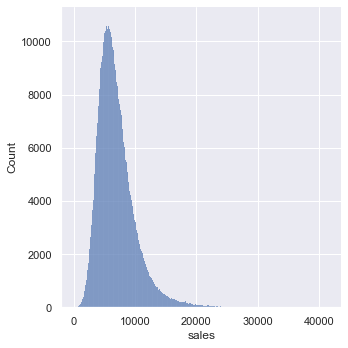

In [76]:
#plotar distribuição de vendas
sns.displot ( df4['sales'] )

A maioria dos algotirmos assumem premissas, como ter os dados distribuídos numa normal.
Quanto mais normal for a variável resposta, melhor o algoritmo vai performar.  

Há formas de tornar ela mais próximas de uma normal, como a log1p abaixo, que multiplica os valores de venda pelo log: (entenderei mais adiante)

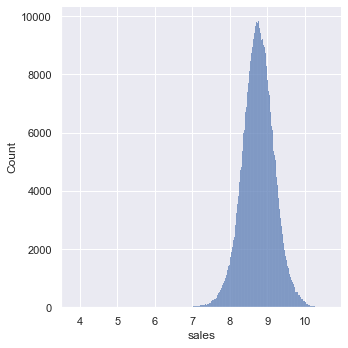

In [78]:
sns.displot (np.log1p ( df4['sales'] ) )

### Numerical Variable

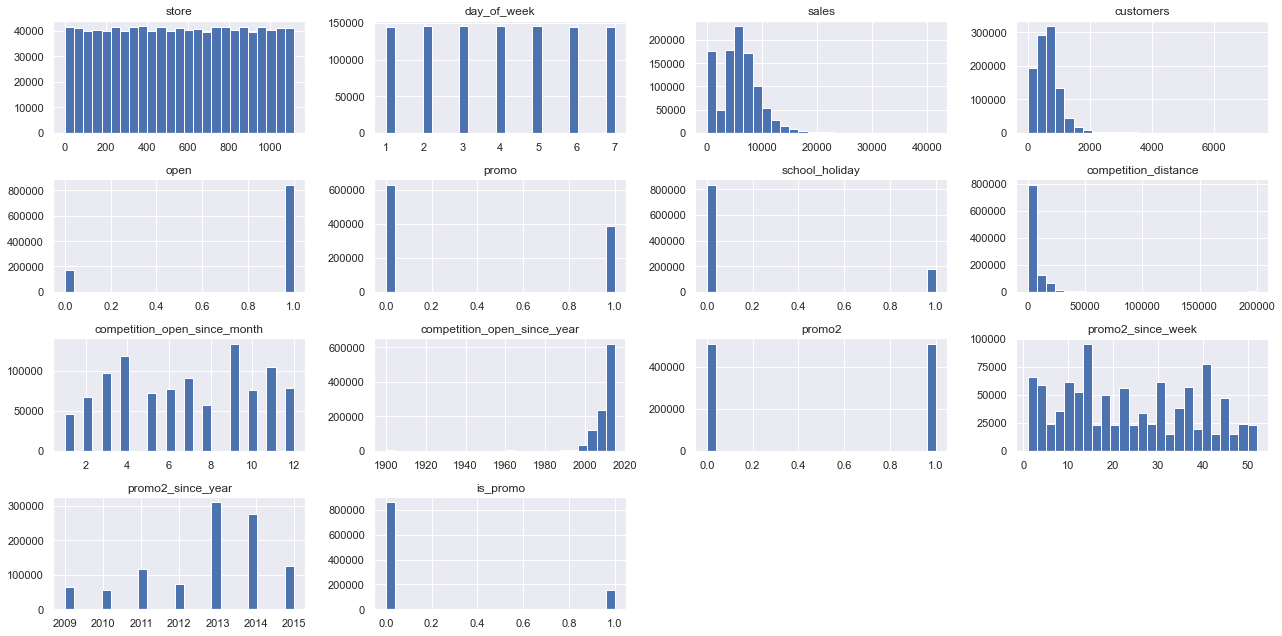

In [90]:
#Plotar histograma de todos os atributos numéricos  
#histograma é uma espécie de gráfico de barras que demonstra uma distribuição de frequências.

# bins é o número de barras, e ; é pra não mostrar texto
num_attributes.hist( bins = 25);
plt.tight_layout()

Se tem variação, nos ajuda a entender o fenômeno. 

days_of_week sozinha, se não for usada com outras variáveis, não tem relevância pro aprendizado do modelo.

sales e customers tem skew positiva: concentração de dados baixa (menor que a média)

promo: pra cada 3 lojas, 1 estava em promoção na data da venda.

promo2: só aprox. 50% das lojas estavam em promoção consecutiva (sequencia de uma anterios) quando venderam.

competition_distance: há uma enorme concentração de competidores próximos das lojas. 

### Categorical Variable

In [91]:
#resumir:
cat_attributes.head()
#vamos avaliar as 3 primeiras, as duas últimas são só derivações

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


#### state_holiday

In [92]:
df4['state_holiday'].value_counts()

regular_day       843428
public_holiday       694
easter_holiday       145
christmas             71
Name: state_holiday, dtype: int64

In [93]:
#pra voltar a ficar só com os tipos de dados originais
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

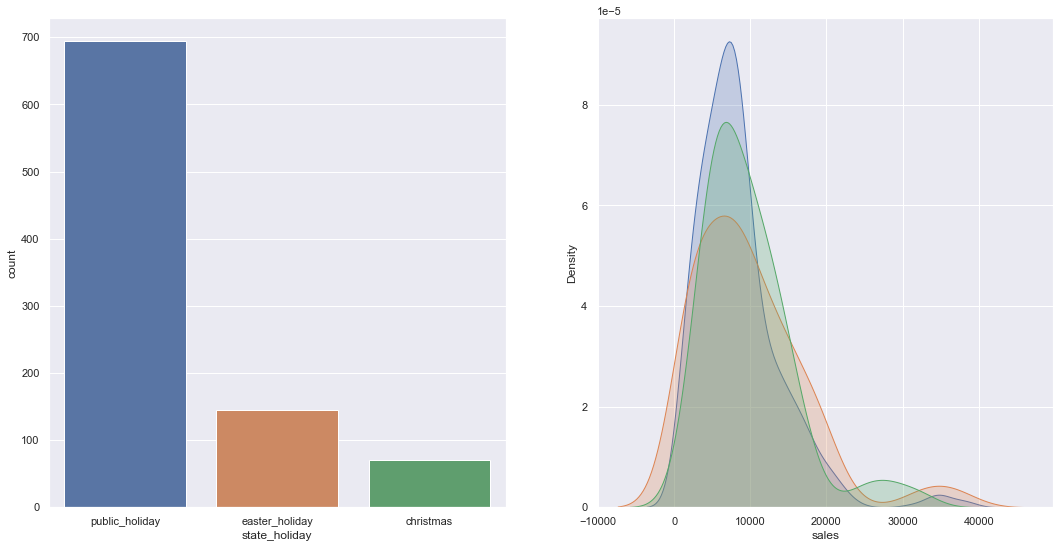

In [83]:
plt.subplot( 1,2,1)
#plotando apenas os feriados
a = df4.loc[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 1,2,2)
#agora plotando os feriados sobrepostos
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], shade=True, label='public_holiday')
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade=True, label='easter_holiday') 
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], shade=True, label='christmas') 

Interessante pro modelo saber o impacto que os feriados tem nas vendas, vamos usar a variável pra treinar o modelo.

#### store_type

In [94]:
df4['store_type'].value_counts()

a    457042
d    258768
c    112968
b     15560
Name: store_type, dtype: int64

In [95]:
#pra voltar a ficar só com os tipos de dados originais
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

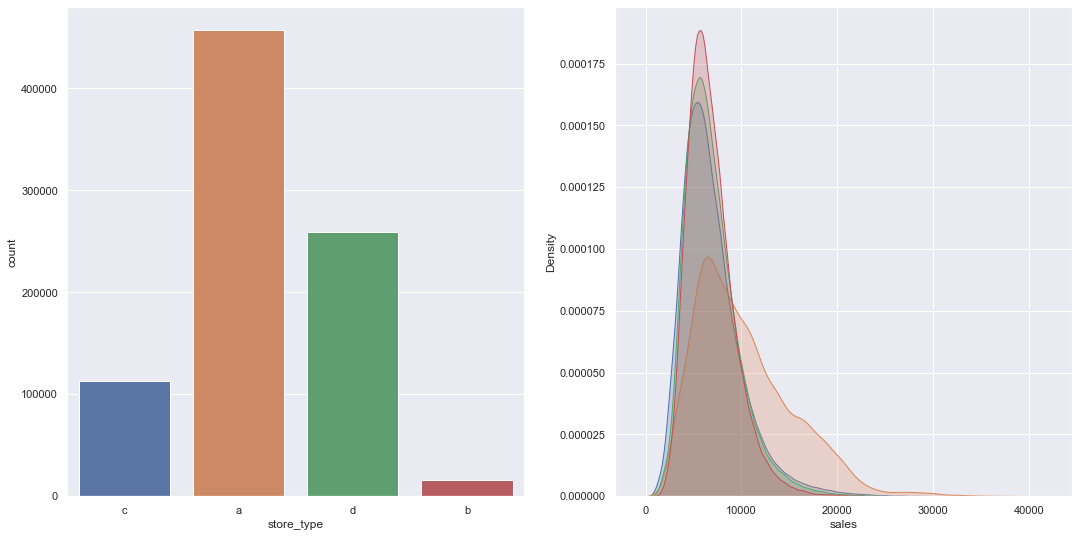

In [96]:
plt.subplot( 1,2,1)
#plotando os tipos das lojas
sns.countplot( df4['store_type'] )

plt.subplot( 1,2,2)
#agora plotando os feriados sobrepostos
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], shade=True, label='a')
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], shade=True, label='b') 
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], shade=True, label='c') 
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], shade=True, label='d')
#plt.tight_layout()

Interessante também pro modelo saber que o tipo de loja impacta assim na venda, vamos usar a variável pra treinar o modelo.

#### assortment

In [97]:
df4['assortment'].value_counts()

basic       444875
extended    391254
extra         8209
Name: assortment, dtype: int64

In [98]:
#pra voltar a ficar só com os tipos de dados originais
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

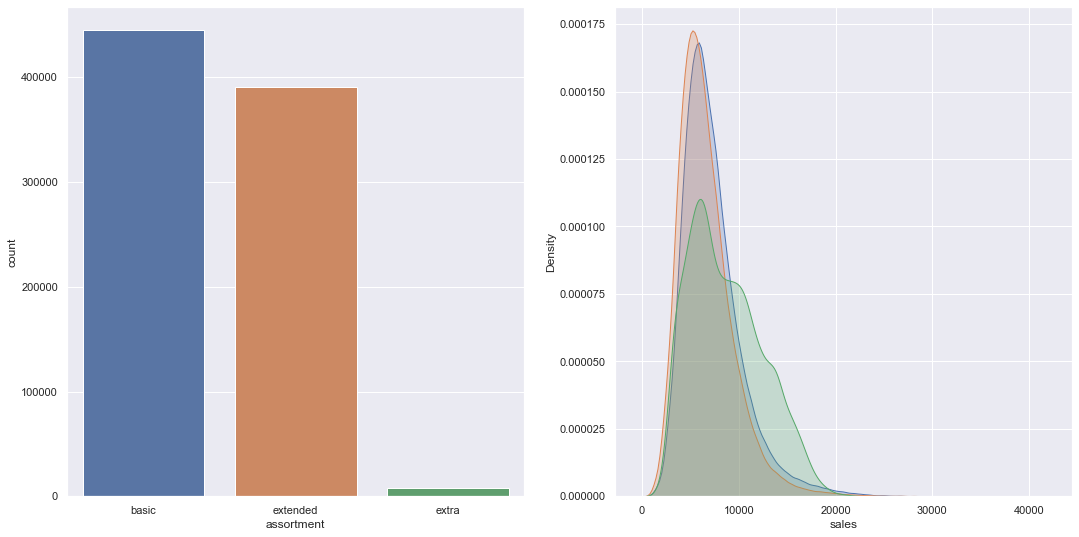

In [99]:
plt.subplot( 1,2,1)
#plotando os mixes das lojas
sns.countplot( df4['assortment'] )

plt.subplot( 1,2,2)
#agora plotando os feriados sobrepostos
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], shade=True, label='extended')
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], shade=True, label='basic') 
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], shade=True, label='extra') 
#plt.tight_layout()

Interessante também pro modelo saber que o assorment de loja impacta na venda, vamos usar a variável pra treinar o modelo.

## Análise Bivariada

Responde: Qual a força do impacto de uma variável na variável resposta?

Vamos validar cada hipótese, e analisar se a variável é importante ou não pro modelo.

Vamos validar as 3 primieras hipóteses priorizadas

#### (H1 - loja) Lojas com maior sortimento deveriam vender mais.
***FALSA*** - Lojas com maior sortimento vendem menos.

<AxesSubplot:xlabel='assortment', ylabel='sales'>

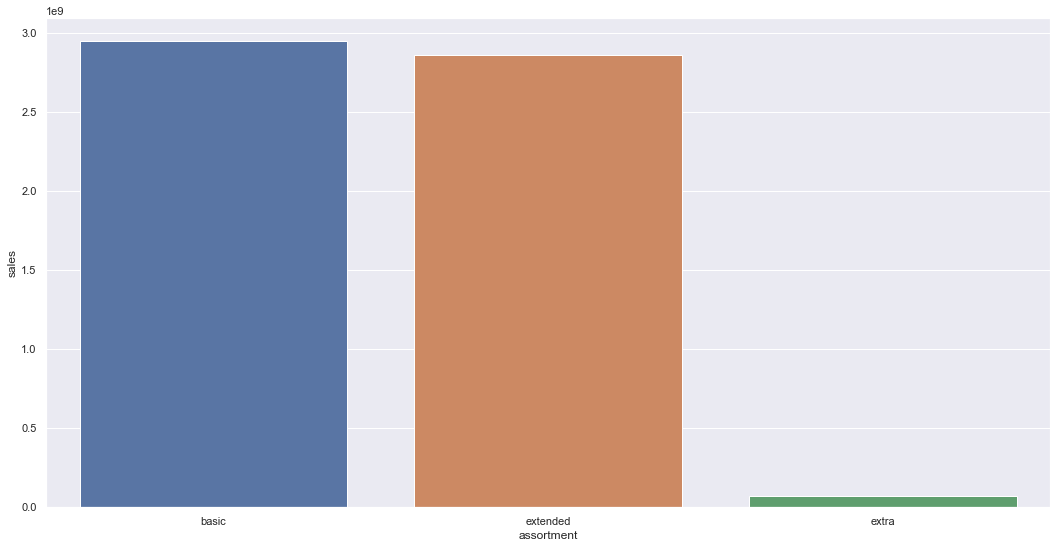

In [100]:
#Quantidade de vendas por loja:
aux1 = df4[['assortment','sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot ( x='assortment', y='sales', data=aux1 )

Assumimos que o assortment seja: basic < extended < extra, pois não tem essa legenda.
Baseados nisso, a hipótese é falsa, pois lojas com assortment extra vendem menos.


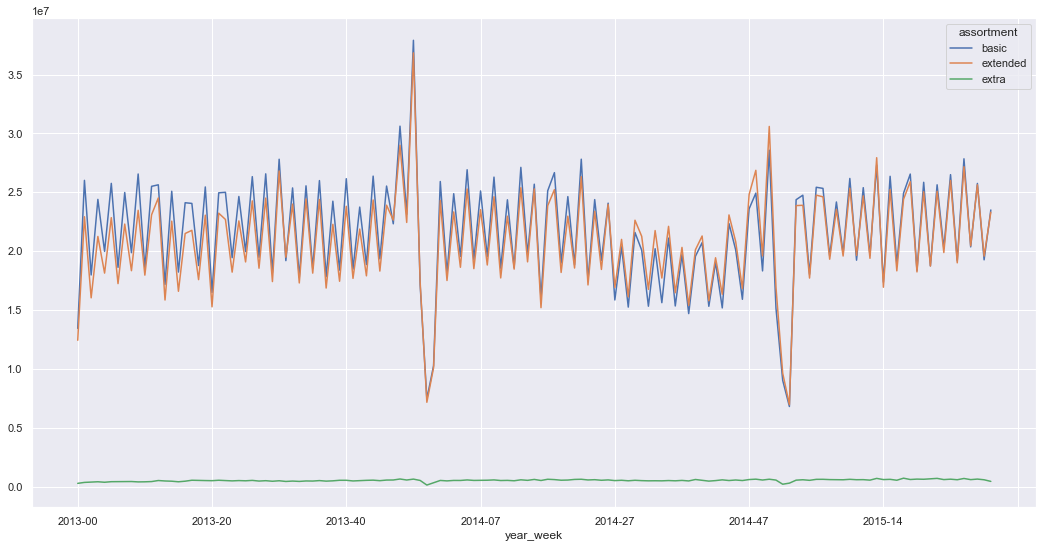

In [101]:
aux2 = df4[['year_week','assortment','sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2_piv = aux2.pivot ( index='year_week', columns='assortment', values='sales' ).plot()

Notamos que basic e extended tem praticamente o mesmo comportamento ao longo do tempo, já extra sempre teve bem menos vendas. 

Como extra tem muito menos vendas comparado com os demais, não dá pra ver a sua variação. Vamos olhar apenas ele agora:

In [102]:
#Obs: como é a estrutura de aux3 pra conseguir plotar: (tira o plot lá de cima pra rodar este)
aux2_piv

<AxesSubplot:xlabel='year_week'>

<AxesSubplot:xlabel='year_week'>

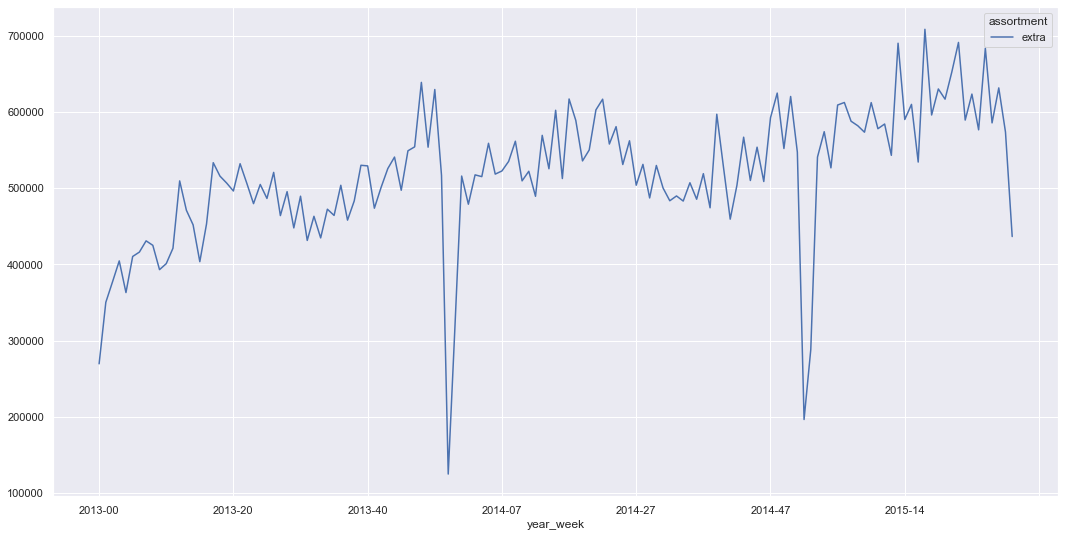

In [103]:
aux3 = aux2.loc[aux2['assortment'] == 'extra' ]
aux3.pivot ( index='year_week', columns='assortment', values='sales' ).plot()

Há variação também, mas diferente da oscilação dos demais assortments. Então é relevante pro modelo.

Importância para o modelo: Baixa mas relevante, pois numa única variável assortment, temos mais de um tipo de comportamento de venda.

#### (H2 - loja) Lojas com competidores mais próximos deveriam vender menos.
***FALSA*** - Lojas com mais competidores mais próximos vendem mais.


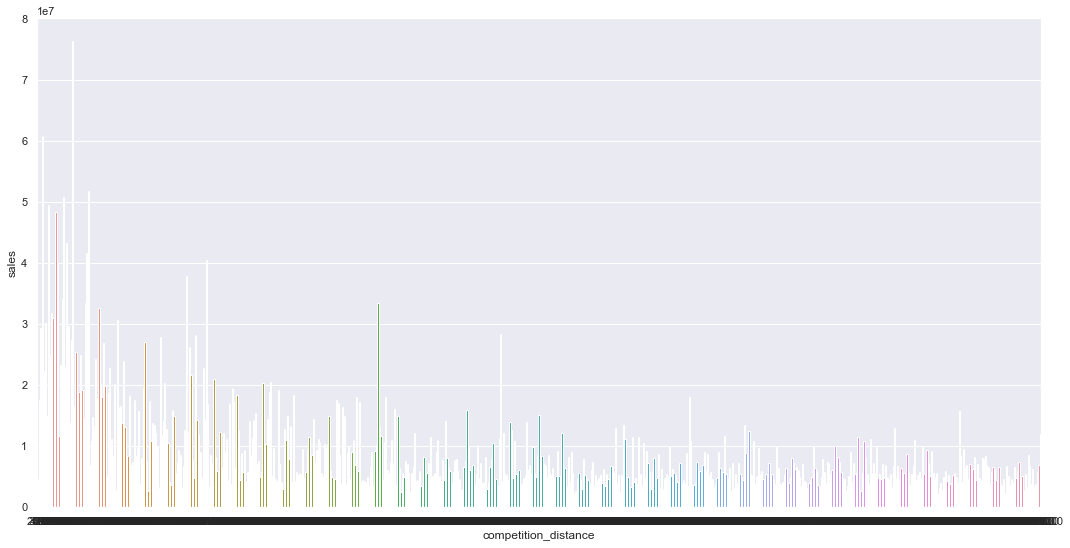

In [104]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.barplot (x='competition_distance', y='sales', data=aux1);

Como ficou ilegível, vamos criar bins pra ficar mais fácil:

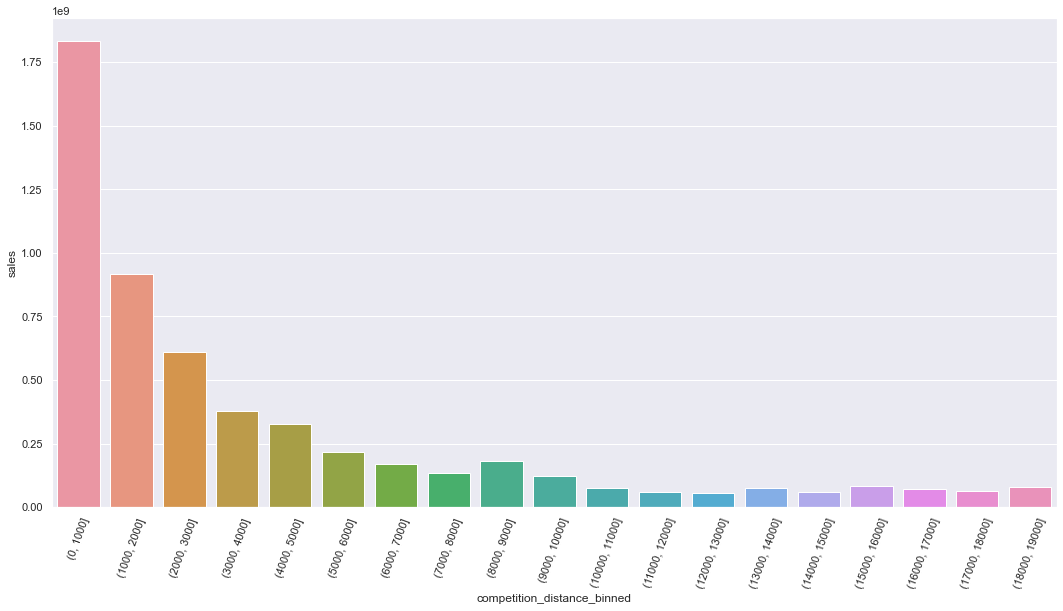

In [105]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
#bins são listas de 0 a 20k, dividido em grupos de 1k. Mesmo que fique fora vendas > 20k,
#já me mostra bem a concentração
bins = list(np.arange(0 ,20000, 1000) )

#coloca 'competition_distance' dentro dos bins:
aux1['competition_distance_binned'] = pd.cut ( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()

sns.barplot (x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=70);

Obs: Na legenda: () não inclui o intervalo, e [] inclui o intervalo. Ex: (0, 1500] é do 1 ao 1500.

Temos aqui um baita insight: quanto menor a distância dos competidores, maior a quantidade de vendas, contrário à crença que parecia mais 'lógica'. 

In [106]:
#Obs: Como fica o aux1:
aux1.sample(5)

,competition_distance,sales,competition_distance_binned
78,820.0,9957101,"(0.0, 1000.0]"
602,20620.0,8338762,NaN
605,20970.0,6461297,NaN
25,270.0,25366502,"(0.0, 1000.0]"
67,690.0,3739067,"(0.0, 1000.0]"


Agrupamos a distribuição em barras, mas para ver melhor a distribuição podemos usar um  scatterplot:

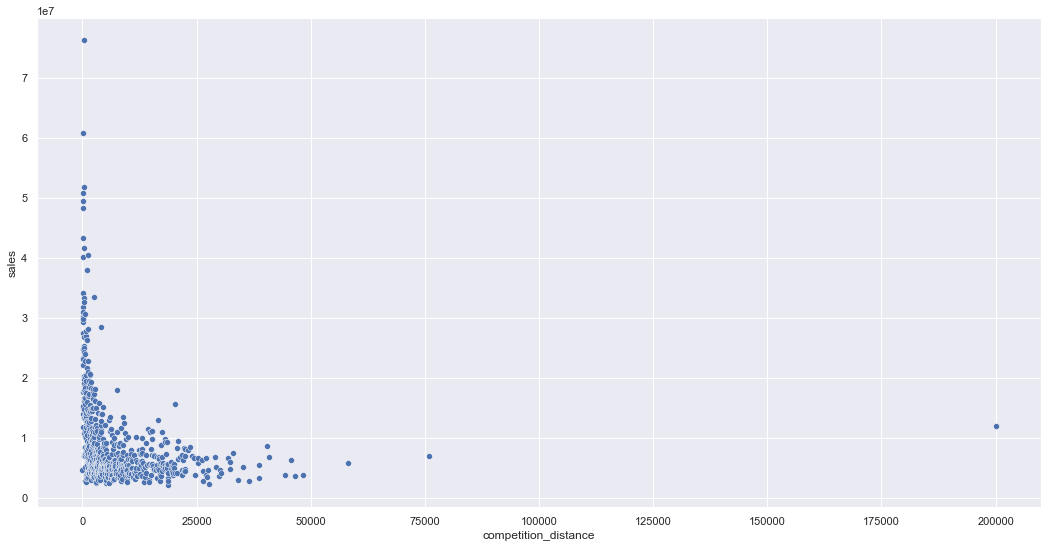

In [107]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.scatterplot (x='competition_distance', y='sales', data=aux1);

Cada ponto representa uma das 655 distâncias únicas! 

Agora, vamos ver a força da correlação entre 'competition_distance', 'sales', pra entender melhor a força do impacto desta variável na variável resposta.

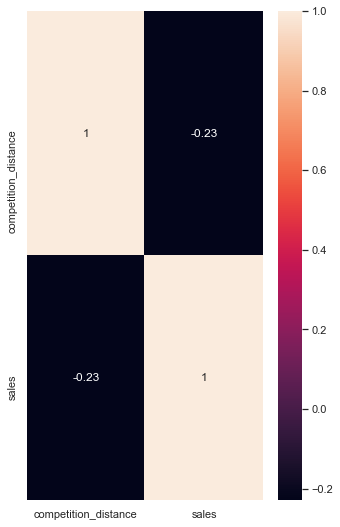

In [108]:
#força da correlação
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr (method='pearson'),annot=True );

Há correlação, mas é fraca: conforme aumenta a distância, diminuem as vendas.
Como a correlação é fraca, assumo que o fenômeno (venda) aumenta ou diminui muito mais por interferêncai de outros agentes (fluxo de clientes por ex) do que pela distância da concorrência isolada.

Relevância para o modelo: Média.

#### (H3 - loja) Lojas com competidores há mais tempo deveriam vender mais.
***FALSA*** - Lojas com COMPETIDORES HÁ MAIS TEMPO vendem MENOS

In [109]:
# vamos usar o 'competition_time_month' que criamos, pra ver há quantos meses existe competição
df4[['competition_time_month','sales']]

,competition_time_month,sales
0,84,5263
1,94,6064
2,105,8314
3,71,13995
4,4,4822
...,...,...
1016776,77,3375
1016827,161,10765
1016863,0,5035
1017042,0,4491


<AxesSubplot:xlabel='competition_time_month', ylabel='sales'>

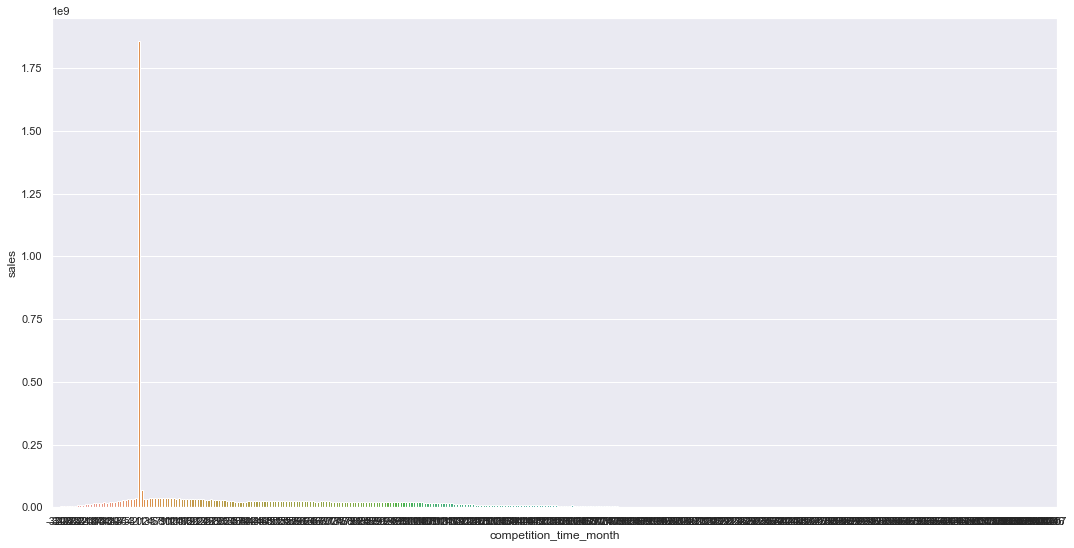

In [110]:
aux1 = df4[['competition_time_month','sales']].groupby( 'competition_time_month' ).sum().reset_index()
sns.barplot ( x='competition_time_month', y= 'sales', data=aux1 )

Ficou muito ruim de ver por este pico imenso. Vamos criar um filtro:

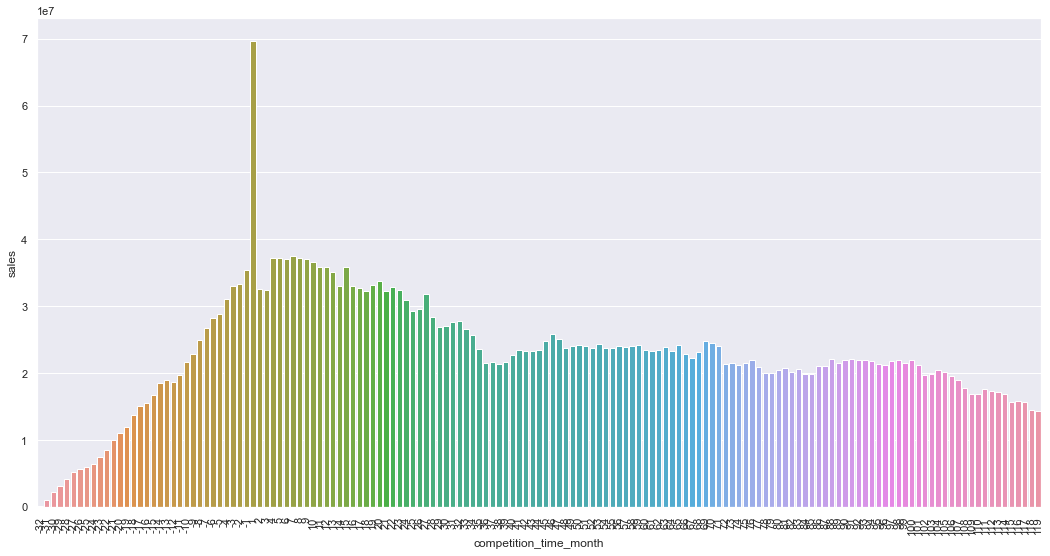

In [111]:
aux1 = df4[['competition_time_month','sales']].groupby( 'competition_time_month' ).sum().reset_index()
#filtrar só competição menor que 120 meses (10 anos) 
  #e que abriram em mês diferente do mesmo da venda (setamos esses no braço lá atrás):
aux2 = aux1[ ( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 ) ]
sns.barplot ( x='competition_time_month', y= 'sales', data=aux2 )
plt.xticks(rotation=90);

Se valores positivo, competidor abriu há aquela quandiade de meses atrás dessa venda.
Se valor negativo, competidor vai abrir há aquela quandiade de meses pra frente desta venda. 

Insight bem contraditório ao senso comum:
Quanto mais recente é a competição (mais se aproxima o negativo de zero), maior é a venda!

Vamos agora criar um regplot de tendência de crescimento ou não: (só pra mostrar, mas não é boa nesse caso porque temos uma subida e uma descida nas vendas, então fica enviezado)

<AxesSubplot:xlabel='competition_time_month', ylabel='sales'>

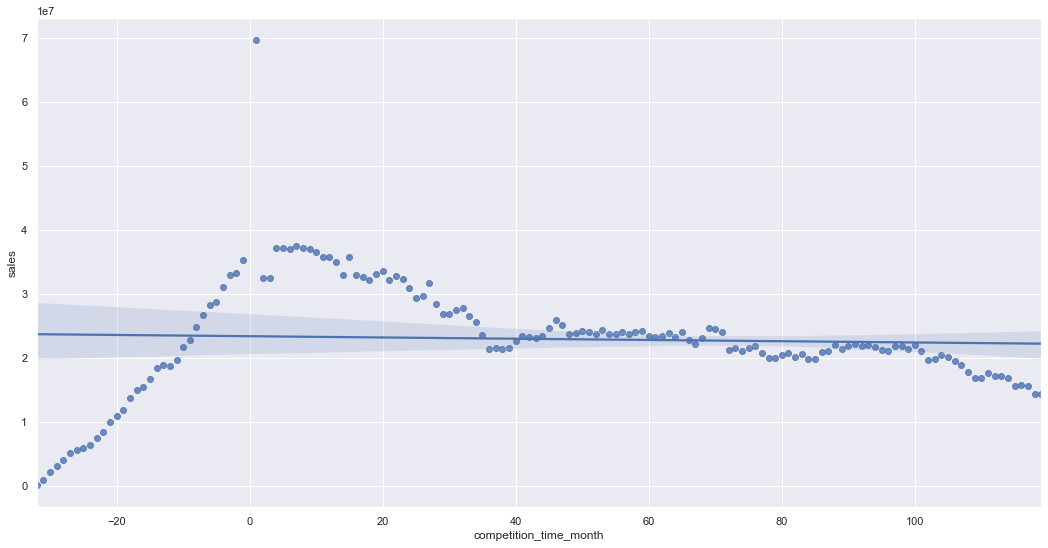

In [112]:
sns.regplot ( x='competition_time_month', y= 'sales', data=aux2 )

Vamos avaliar agora a correlação entre as variáveis:

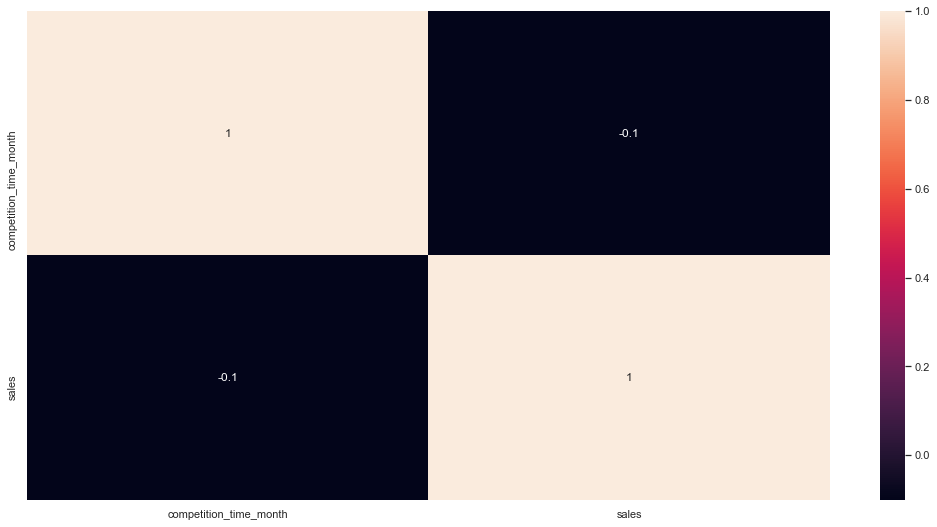

In [114]:
#força da correlação
sns.heatmap( aux1.corr (method='pearson'),annot=True );

Relevância para o modelo: média.

#### (H4 - prod) Lojas com promoções ativas por mais tempo deveriam vender mais.
***FALSA*** - Lojas com PROMOÇÕES ATIVAS POR MAIS TEMPO vendem MENOS depois de um certo período de promoção.

In [116]:
df4.head(15)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
5,6,5,2015-07-31,5651,589,1,1,regular_day,1,a,basic,310.0,12,2013,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2013-12-01,20,2015-07-27,0
6,7,5,2015-07-31,15344,1414,1,1,regular_day,1,a,extended,24000.0,4,2013,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2013-04-01,28,2015-07-27,0
7,8,5,2015-07-31,8492,833,1,1,regular_day,1,a,basic,7520.0,10,2014,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2014-10-01,10,2015-07-27,0
8,9,5,2015-07-31,8565,687,1,1,regular_day,1,a,extended,2030.0,8,2000,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2000-08-01,182,2015-07-27,0
9,10,5,2015-07-31,7185,681,1,1,regular_day,1,a,basic,3160.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0


In [120]:
df4['promo2_time_week'].value_counts()

 0      421646
 52       3910
 98       1872
 102      1847
 97       1830
         ...  
-125        18
-123        18
-122        18
-124        18
-126        12
Name: promo2_time_week, Length: 440, dtype: int64

promo2_time_week negativo: significa que a venda foi feita no período promocional normal.
promo2_time_week positivo: significa que a venda foi feita no período promocional estendido.

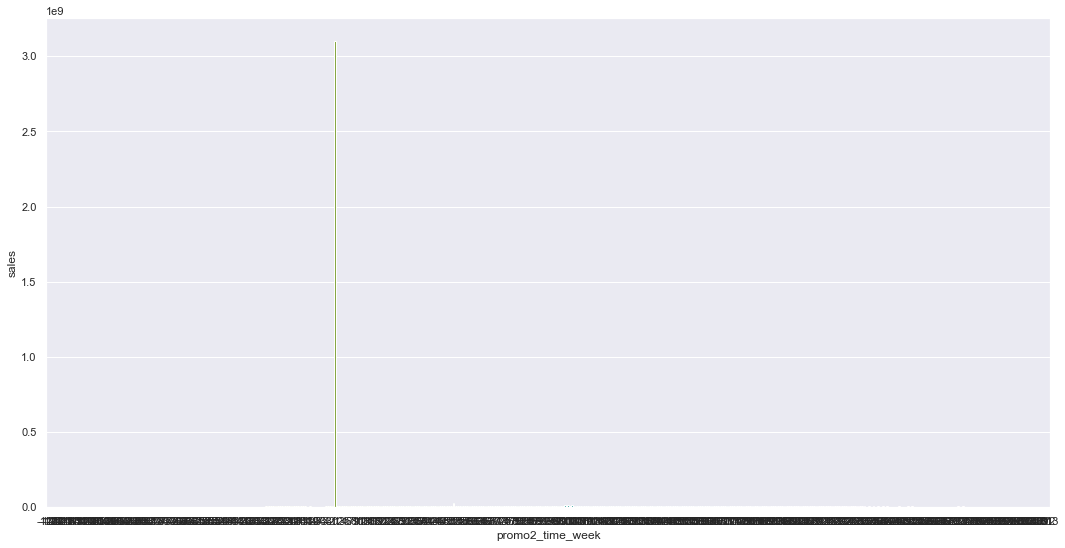

In [121]:
aux1 = df4[['promo2_time_week', 'sales']].groupby ( 'promo2_time_week' ).sum().reset_index()
sns.barplot( x='promo2_time_week', y='sales', data=aux1 );

Como ficou ilegível, vamos olhar o período promocional separado do estendido:

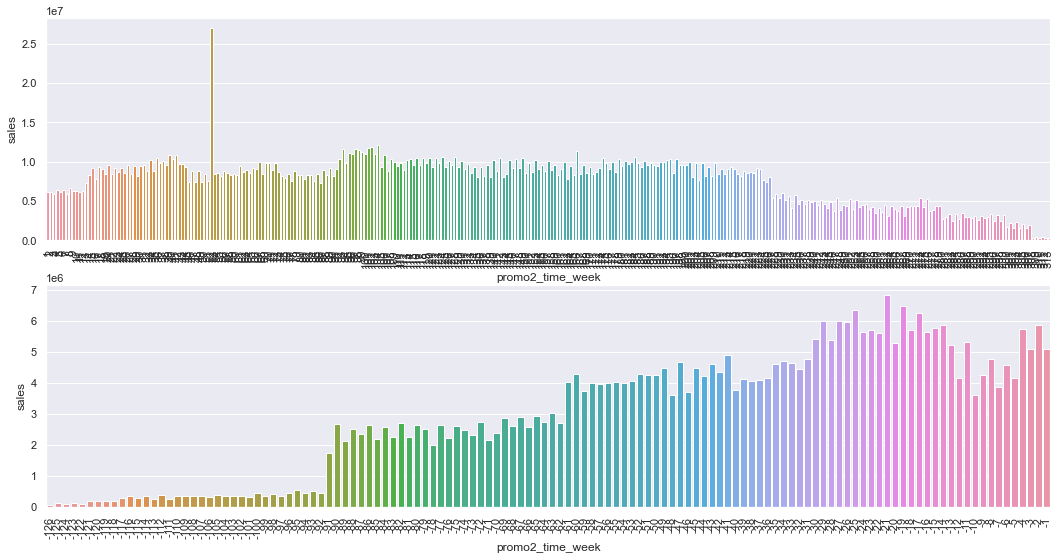

In [124]:
#linhas, coluna, posição
plt.subplot (2, 1, 1)
aux2 = aux1[aux1['promo2_time_week'] > 0] # promo extendido
sns.barplot( x='promo2_time_week', y='sales', data=aux2 );
plt.xticks (rotation=90);

plt.subplot (2, 1, 2)
aux3 = aux1[aux1['promo2_time_week'] < 0] # promo regular
sns.barplot( x='promo2_time_week', y='sales', data=aux3 );
plt.xticks (rotation=90);

Analisando o gráfico superior, podemos ver que a promoção extendida vende regularmente até um momento, mas a partir da 4º parte final do gráfico, as vendas caem.
Analisando o gráfico inferior, podemos ver que antes de chegar na promoção, há aumento nas vendas, talvez pelo efeito do marketing.
Logo, a hipótese já é FALSA, pois: Lojas com PROMOÇÕES ATIVAS POR MAIS TEMPO vendem MENOS. Vai caindo as vendas conforme o tempo passa.

Sobre a relevância para o modelo, vamos avaliar melhor com um gráfico de regplot pra ver a tendência tanto na promo regular como na promo extendida:

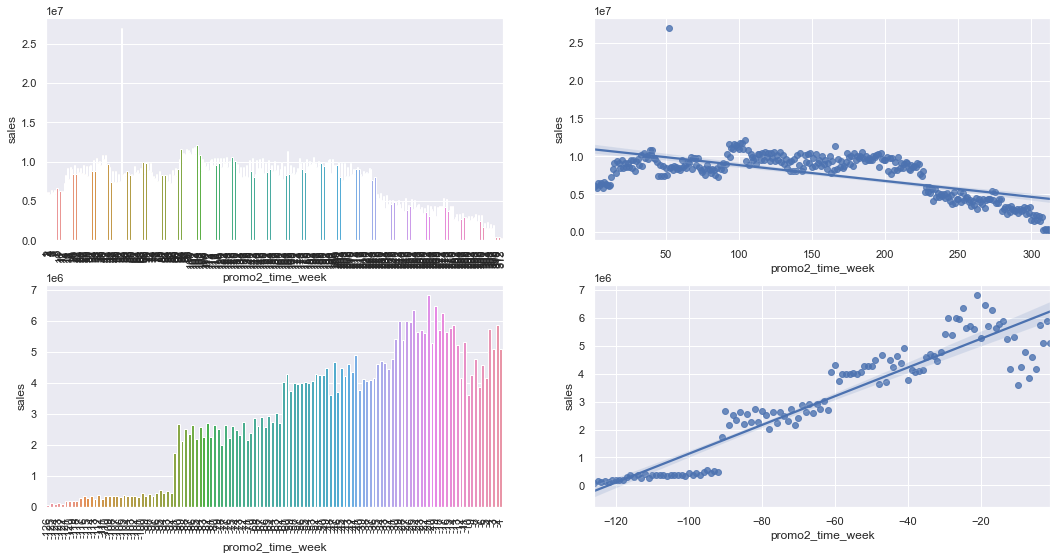

In [125]:
plt.subplot (2, 2, 1)
aux2 = aux1[aux1['promo2_time_week'] > 0] # promo extendido
sns.barplot( x='promo2_time_week', y='sales', data=aux2 );
plt.xticks (rotation=90);

plt.subplot (2, 2, 2)
sns.regplot( x='promo2_time_week', y='sales', data=aux2 );

plt.subplot (2, 2, 3)
aux3 = aux1[aux1['promo2_time_week'] < 0] # promo regular
sns.barplot( x='promo2_time_week', y='sales', data=aux3 );
plt.xticks (rotation=90);

plt.subplot (2, 2, 4)
sns.regplot( x='promo2_time_week', y='sales', data=aux3 );

Agora conseguimos constatar a tendência de aumento de vendas no período promocional normal, e também de queda no período promocional estendido após um tempo.
Vamos medir a correlação agora de promoções com vendas de modo geral, colocando em um grid pra melhorar a visualização:

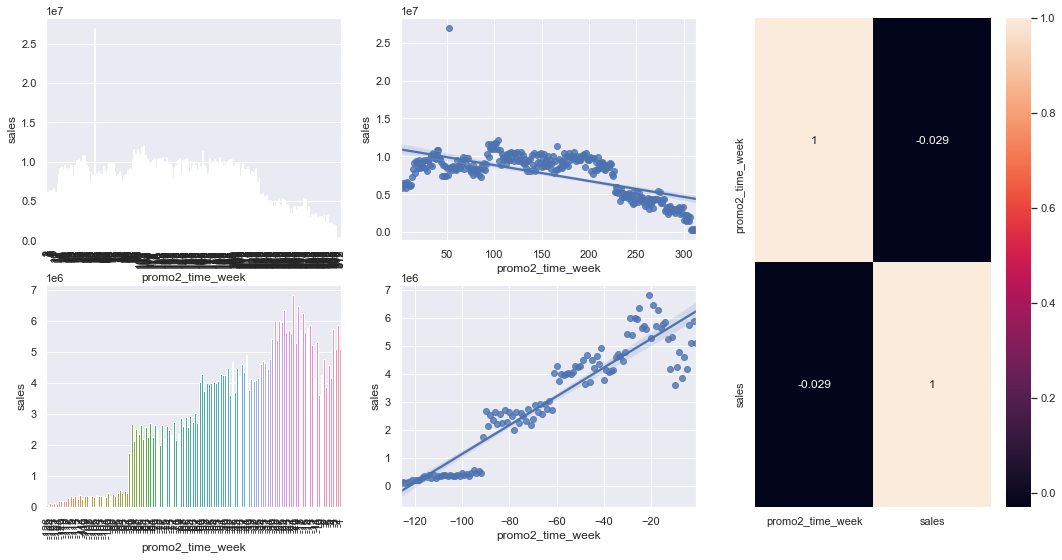

In [132]:
grid = plt.GridSpec (2, 3)

plt.subplot (grid[0,0])
aux2 = aux1[aux1['promo2_time_week'] > 0] # promo extendido
sns.barplot( x='promo2_time_week', y='sales', data=aux2 );
plt.xticks (rotation=90);

plt.subplot (grid[0,1])
sns.regplot( x='promo2_time_week', y='sales', data=aux2 );

plt.subplot (grid[1,0])
aux3 = aux1[aux1['promo2_time_week'] < 0] # promo regular
sns.barplot( x='promo2_time_week', y='sales', data=aux3 );
plt.xticks (rotation=90);

plt.subplot (grid[1,1])
sns.regplot( x='promo2_time_week', y='sales', data=aux3 );

plt.subplot (grid[:,2])
sns.heatmap( aux1.corr (method='pearson'), annot=True );

Relevância para o modelo: baixa relavância isoladamente. Correlação de -0,029: muito fraca.  Pode ser que combinada com outra feature, seja relevante.
Obs: pro modelo, não quebramos em aux2, aux3 como fizemos aqui, só quebramos pra poder olhar melhor em gráfico o comportamento dos dados.

#### <s> (H5 - prod) Lojas com mais dias de promoção deveriam vender mais.</s>

Promoções ativas por mais tempo = mais dias de promoção.
Pra poder validar essa hipótese, precisariamos fazer feature engeneering novamente, criando nova variável dias_de_promocao e agrupar todos os dias de promoção por loja. Ai, fazer esse count.. como trabalhamos com CRISP, vamos deixar pro segundo ciclo pra fechar esse primero o mais rápido possível. 

#### (H6 - prod) Lojas com mais promoções consecutivas deveriam vender mais.
***FALSA*** - Lojas com MAIS PROMOÇÕES CONSECUTIVAS vendem MENOS.

Vamos avaliar aqui se lojas que entram no período consegutivo de promoção vendem mais que as que não entram.

In [135]:
df4[['promo', 'promo2', 'sales']].groupby ( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


Constatamos que houve mais vendas nas lojas que só participaram da promo 1, e logo depois as lojas que não participaram de nenhuma promoção.
Vamos ver se esse comportamento mudou ao longo do tempo.

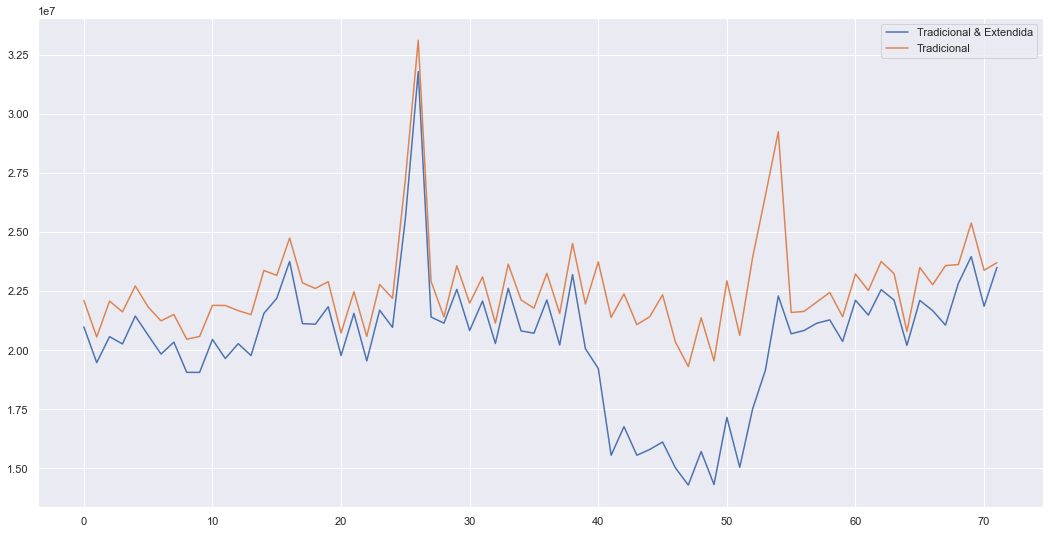

In [145]:
#plotar só vendas de lojas que participaram da promo 1 tradicional e promo 2 extendida:
aux1 = df4[ ( df4['promo'] == 1 ) & ( df4['promo2'] == 1 ) ][['year_week','sales']].groupby ( 'year_week' ).sum().reset_index()
ax = aux1.plot()

#plotar só vendas de lojas que só participaram da promo 1 tradicional e NÃO da promo 2 extendida:
aux2 = df4[ ( df4['promo'] == 1 ) & ( df4['promo2'] == 0 ) ][['year_week','sales']].groupby ( 'year_week' ).sum().reset_index()
aux2.plot(ax=ax)

ax.legend( labels=['Tradicional & Extendida','Tradicional'])

Vemos então que lojas com mais promoções consecutivas vendem menos, pode ser um insight importante para o negócio.

Relevância para o modelo: baixa. Analisando estas variávies sozinhas, não parecem ser muito relevantes para o modelo, pois só tem uma parte onde o gráfico difere mais. Mais adiante vamos ter uma segunda opinião de um algorítmo.

#### (H7 - sazo) Lojas abertas duantes o feriado de natal deveriam vender mais.
***FALSA*** - Lojas abertas durante o feriado de natal vendem menos que nos demais feriados do ano.

Eliminei registros onde não houveram vendas lá no início da análise. Logo, vou comparar as vendas do feriado de natal com as vendas dos demais feriados:

In [148]:
df4['state_holiday'].value_counts()

regular_day       843428
public_holiday       694
easter_holiday       145
christmas             71
Name: state_holiday, dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

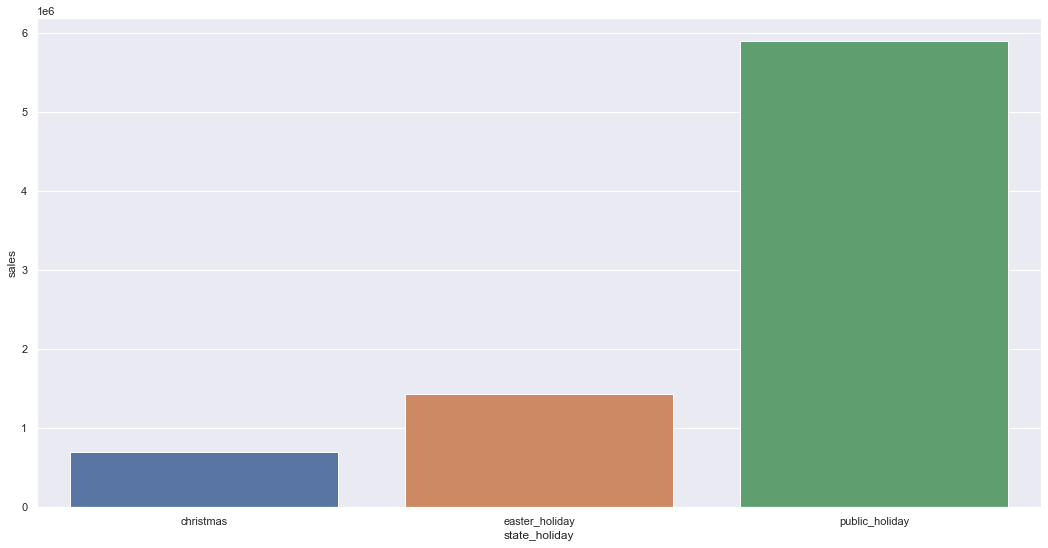

In [162]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby ('state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 )

Já vemos que a hipótese é falsa, pois o natal vende menos que outros feriados.
Vamos ver ao longo do tempo se em algum momento já vendeu, pegando pelos anos:

<AxesSubplot:xlabel='year', ylabel='sales'>

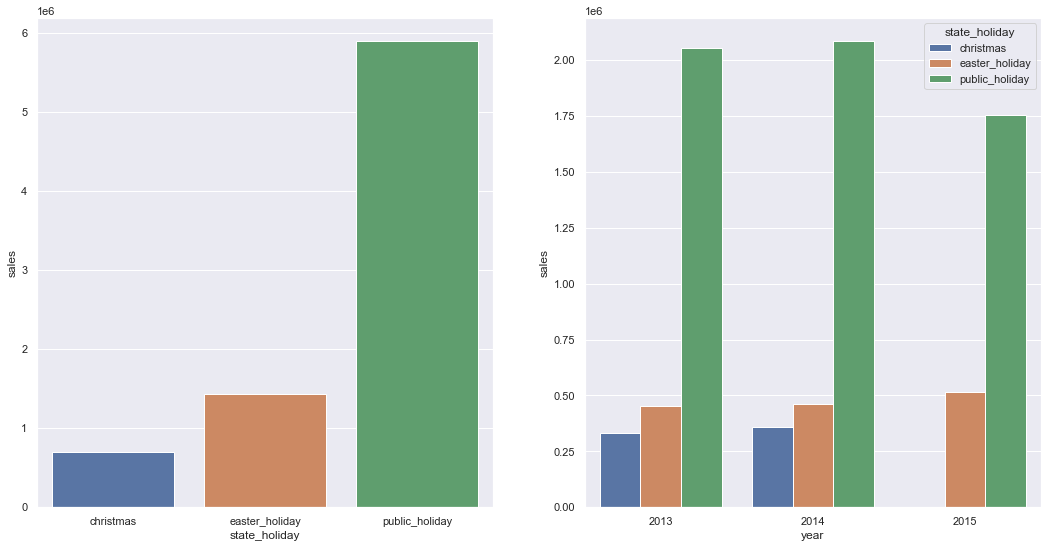

In [167]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1,2,1 )
aux1 = aux[['state_holiday','sales']].groupby ('state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1,2,2 )
aux2 = aux[['year','state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', data=aux2, hue='state_holiday' )
#hue = tipos de barras, pra cada state_holiday quero uma barra

Realmente, as vendas no notal sempre são menores que nos demais feriados. Em 2015, não temos dados.
Logo, a hipótese é falsa.

Importância para o modelo: média, relevante pois o modelo vai considerar essa variação de vendas de acordo com state_holiday

#### (H8 - sazo) Lojas deveriam vender mais ao longo dos anos.
***FALSA*** - Lojas vendem menos ao longo dos anos.

In [170]:
df4['year'].value_counts()

2013    337924
2014    310385
2015    196029
Name: year, dtype: int64

Vou agrupar as vendas por ano, e ver se há aumento de vendas entre 2013 e 1015:

<AxesSubplot:xlabel='year', ylabel='sales'>

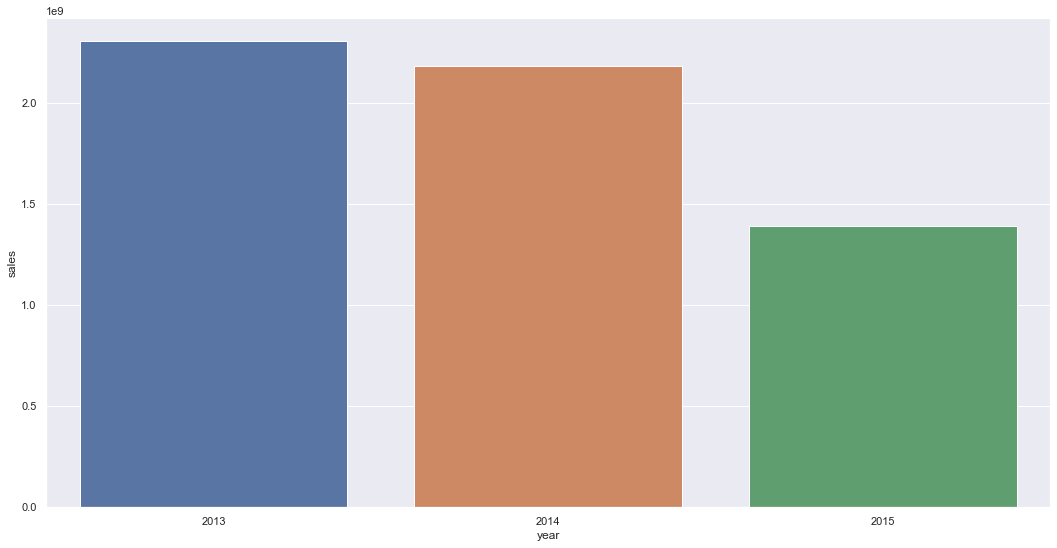

In [175]:
aux1 = df4[['year','sales']].groupby( 'year' ).sum().reset_index()
sns.barplot (x='year', y='sales', data=aux1)

Vendas vem caindo ao longo dos anos, ainda que 2015 não esteja fechado.
Vamos ver a correlação:

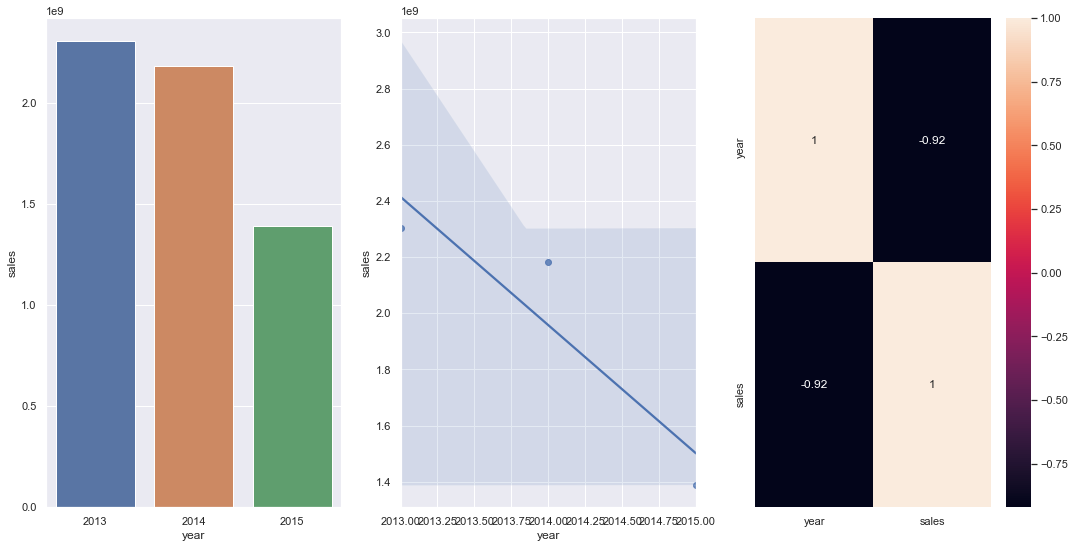

In [200]:
aux1 = df4[['year','sales']].groupby( 'year' ).sum().reset_index()

#linha, coluna, posição
plt.subplot(1, 3, 1)
sns.barplot (x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot (x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap (aux1.corr(method='pearson'), annot=True );

Correlação negativa muito forte de -0,92: conforme os anos avançam, as vendas caem. 
Como 2015 não está fechado, temos dados até aprox. agosto, ideal é pegar só períodos fechados, pois temos dados enviesados aqui.
Ano então é uma variável importante pro modelo. Não deve ser novidade pra empresa esta queda.

Relevância para o modelo: alta, pois ainda que tenhamos pego só parte de 2015, a correlação é altíssima entre vendas e anos, logo vai ajudar na previsão dos próximos anos.

#### (H9 - sazo) Lojas deveriam vender mais no segundo semestre do ano.
***FALSA*** - Lojas VENDEM MENOS no SEGUNDO SEMESTRE DO ANO.

Vamos analisar por mês, pois já temos a variável month pronta:

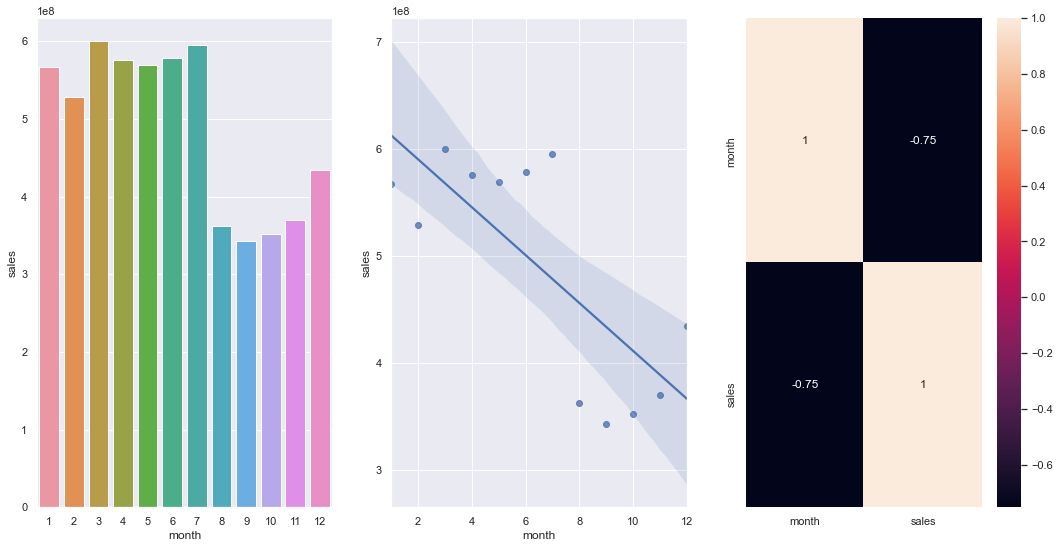

In [207]:
aux1 = df4[['month','sales']].groupby( 'month' ).sum().reset_index()

#linha, coluna, posição
plt.subplot(1, 3, 1)
sns.barplot (x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot (x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap (aux1.corr(method='pearson'), annot=True );

Bem marcante o fato das lojas da Rossmann venderem muito mais no primeiro semestre que no segundo. Correlação negativa entre meses e vendas muito alta, de -0,75.

Importância para o modelo: Alta, pois há grande correlação entre mês e vendas.

#### (H10 - sazo) Lojas deveriam vender mais depois do dia 10 de cada mês.
***FALSA*** - Lojas VENDEM MENOS DEPOIS do dia 10 de cada mês.

Vamos verificar primeiramente por dia:

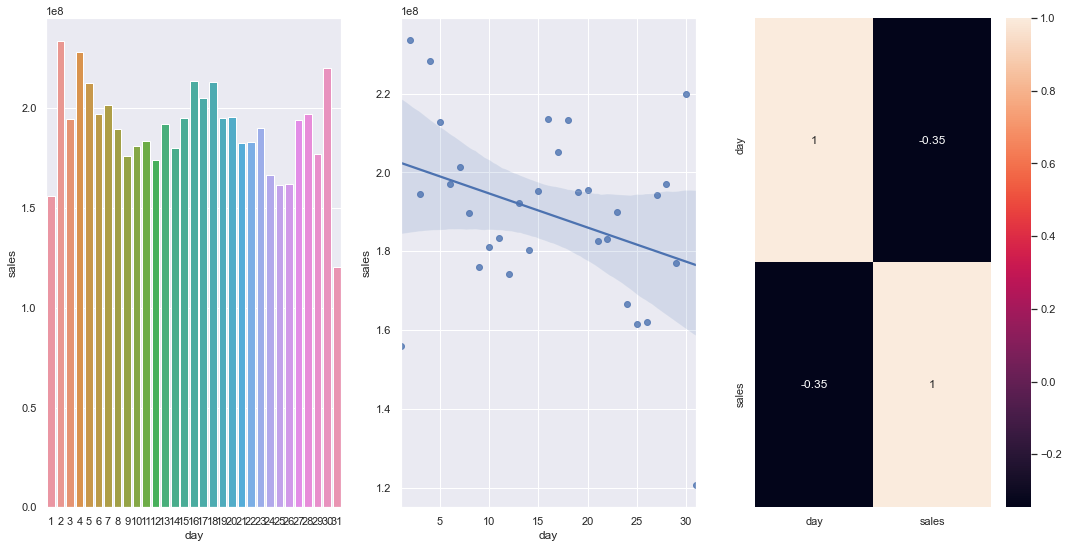

In [210]:
aux1 = df4[['day','sales']].groupby( 'day' ).sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot (x='day', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot (x='day', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap (aux1.corr(method='pearson'), annot=True );

Vamos agora verificar antes e depois do dia 10:

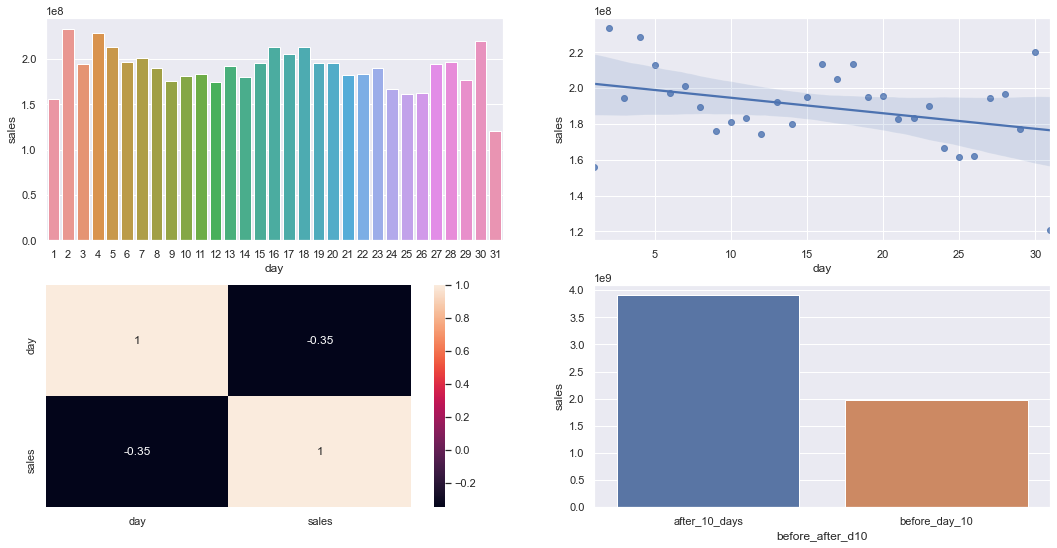

In [231]:
aux1 = df4[['day','sales']].groupby( 'day' ).sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot (x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot (x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap (aux1.corr(method='pearson'), annot=True );

plt.subplot(2, 2, 4)
aux1['before_after_d10'] = aux1['day'].apply( lambda x: 
                                'before_day_10' if x <=10 else 'after_10_days' )
aux2 = aux1[['before_after_d10','sales']].groupby( 'before_after_d10' ).sum().reset_index()
sns.barplot(x='before_after_d10', y='sales', data=aux2);

No último gráfico inferior, vemos que se antes do dia 10 (laranja) vende pouco mais da metade com relação a depois do dia 10 (azul), que corresponde a 2 partes do mês.
Logo, constatamos que há uma redução leve de vendas ao longo dos dias do mês, contrariando a hipótese de que as lojas deveriam vender mais depois do dia 10 do mês.

Relevância para o modelo: alta, apesar da correlação mais fraca.

#### (H11 - sazo) Lojas deveriam vender menos aos finais de semana.
***VERDADEIRA*** - Lojas VENDEM MENOS aos FINAIS DE SEMANA.

Vamos olhar inicialmente por dia da semana:

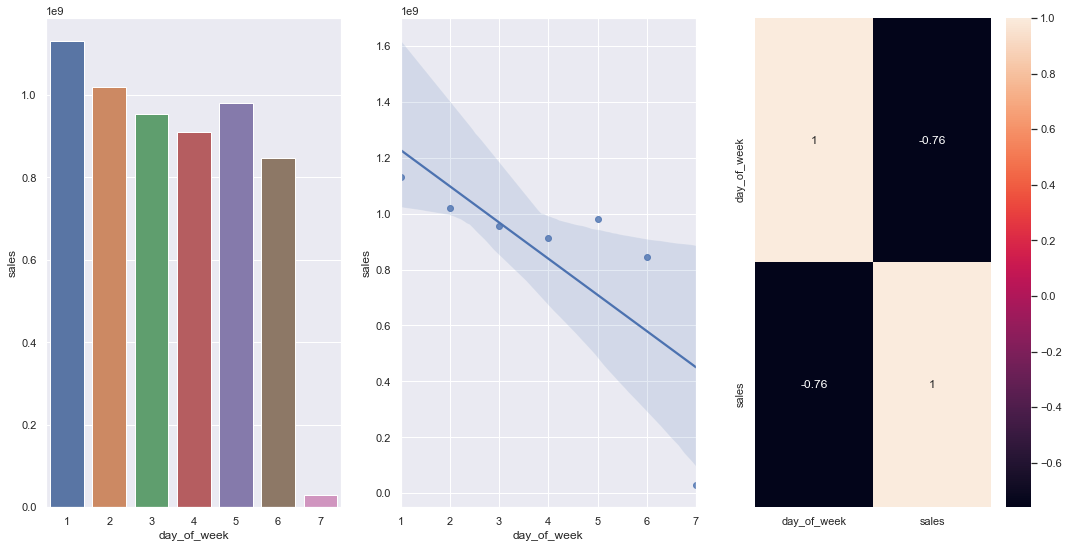

In [235]:
aux1 = df4[['day_of_week','sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot (x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot (x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap (aux1.corr(method='pearson'), annot=True );


As vendas caem conforme passam os dias da semana, em especial no fim de semana.
O sábado é o dia de menos vendas, após o domingo, onde quase não há vendas.
Já aqui ficou claro, hipótese falsa. Nem precisamos separar por dia da semana e final de semana.

Relevância para o modelo: alta, pois há grande correlação entre dias da semana e vendas.

#### (H12 - sazo) Lojas deveriam vender menos durante os feriados escolares.
***VERDADEIRA*** - Lojas VENDEM MENOS durante os FERIADOS ESCOLARES, exceto nos meses de agosto.

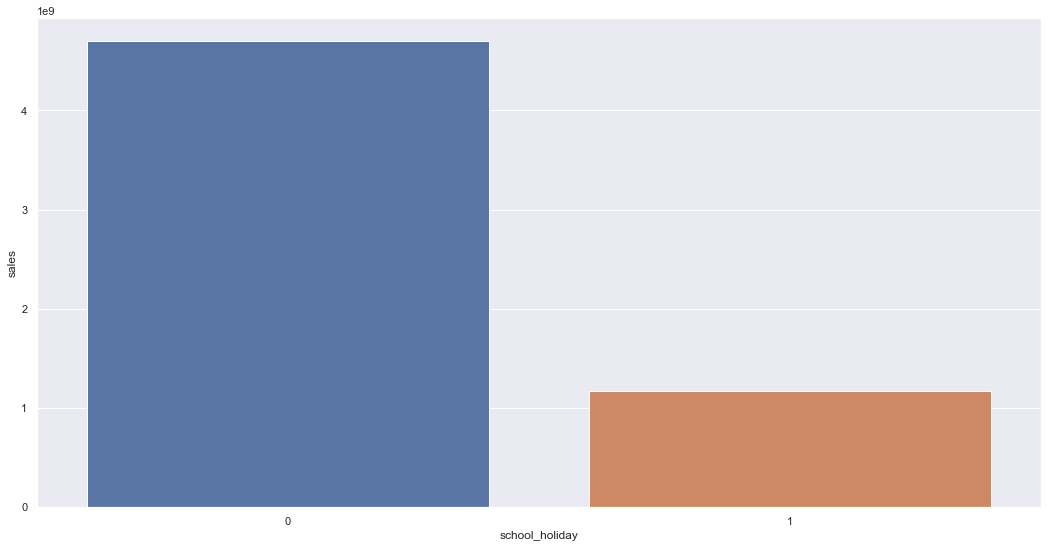

In [236]:
aux1 = df4[['school_holiday','sales']].groupby( 'school_holiday' ).sum().reset_index()
sns.barplot (x='school_holiday', y='sales', data=aux1);

Óbvio, como tem muito menos dias de ferias escolares do que dias normais, lojas vendem mais nos dias normais.
Vamos ver se tem alguma exceção em algum mês:

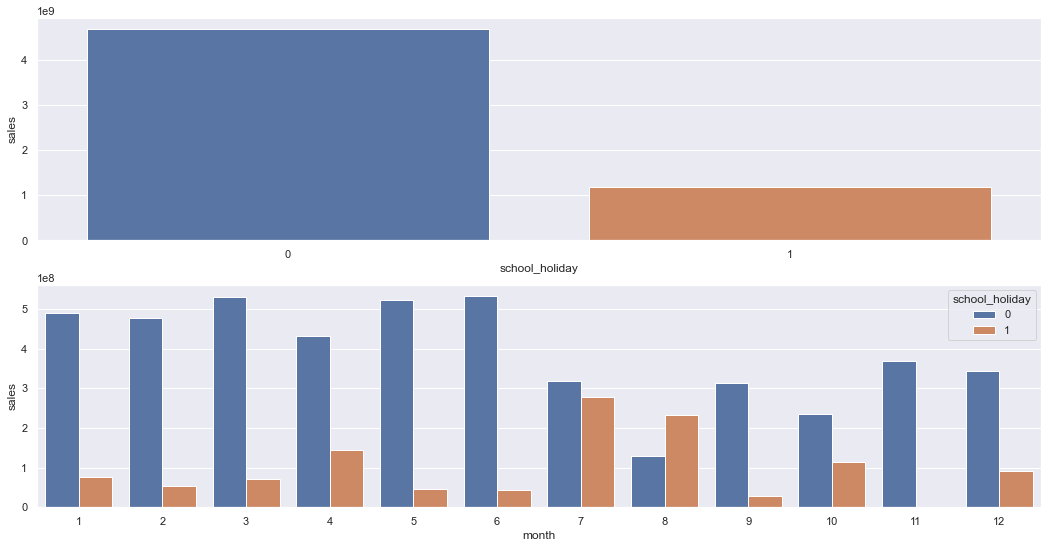

In [239]:
aux1 = df4[['school_holiday','sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot(2,1,1)
sns.barplot (x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday','sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot (x='month', y='sales', data=aux2, hue='school_holiday');

Notamos que em julho, as vendas em feriados escolares são próximas, pois talvez na maioria dos dias não há aulas. 
Em agosto, possivelmente seja um mês forte de férias, e temos até mais vendas em feriados escolares que fora deles.

Relevância para o modelo: média, pois há variação no comportamento nos meses 7 e 8, que deve ser considerada.

### Resumo das Hipóteses

In [253]:
tab = [['Hipoteses', 'Conclusão', 'Relevância Estimada'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Média'],
       ['H3', 'Falsa', 'Média'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Média'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Falsa', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa']
      ]
print(tabulate(tab, headers='firstrow', stralign='center'))
#tablefmt='pipe', tablefmt='grid'

 Hipoteses    Conclusão    Relevância Estimada
-----------  -----------  ---------------------
    H1          Falsa             Baixa
    H2          Falsa             Média
    H3          Falsa             Média
    H4          Falsa             Baixa
    H5            -                 -
    H6          Falsa             Baixa
    H7          Falsa             Média
    H8          Falsa             Alta
    H9          Falsa             Alta
    H10         Falsa             Alta
    H11      Verdadeira           Alta
    H12      Verdadeira           Baixa


## Análise Multivariada

Responde: Como as variáveis impactam nas outras, e como elas juntas impactam na variável resposta.

### Numerical Attributes

In [262]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


<AxesSubplot:>

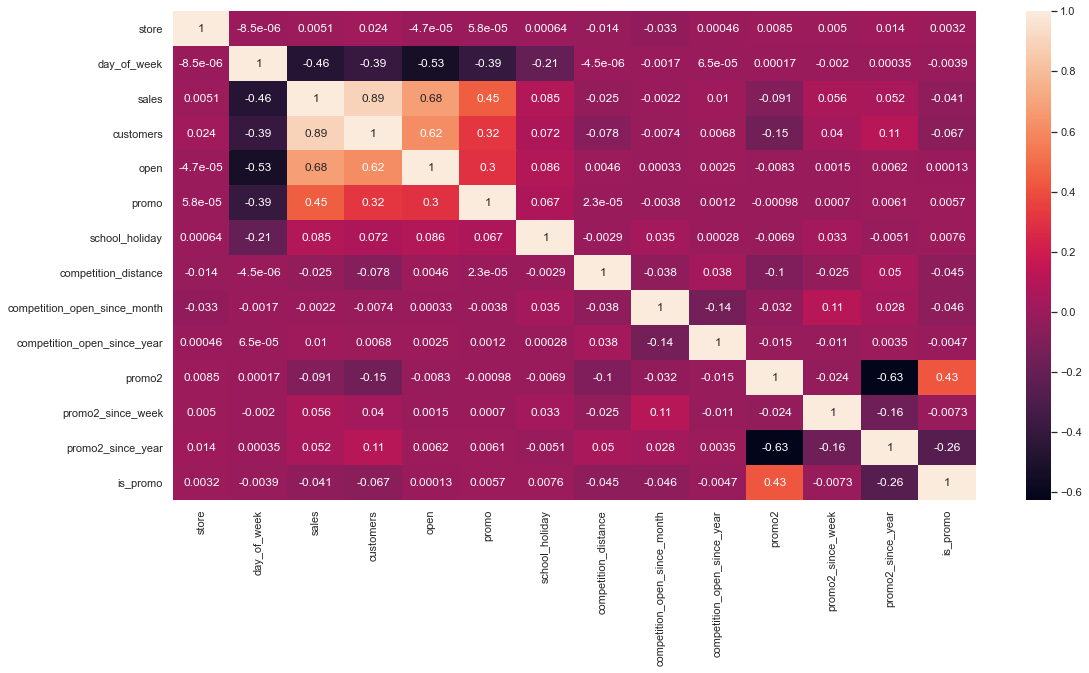

In [260]:
correlation = num_attributes.corr( method='pearson')
sns.heatmap ( correlation, annot=True )

Um dos problemas de previsão bem comuns, é não poder usar variáveis que sabemos que impactam muito, como no caso de Customer em Sales.
Precisaria ter a quantidade de clientes que vão estar na loja nas próximas 6 semanas pra medir isto. Poderia fazer um outro projeto separado, e com esse resultado usar aqui.

### Categorical Attributes

Quando temos variáveis categóricas, não podemos usar Pearson, logo vamos usar o V de Cramer.

In [261]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [264]:
a.head()

,state_holiday,store_type,assortment,promo_interval,month_map,year_week
0,regular_day,c,basic,0,Jul,2015-30
1,regular_day,a,basic,"Jan,Apr,Jul,Oct",Jul,2015-30
2,regular_day,a,basic,"Jan,Apr,Jul,Oct",Jul,2015-30
3,regular_day,c,extended,0,Jul,2015-30
4,regular_day,a,basic,0,Jul,2015-30


#### V de Cramer

In [293]:
#função para gerar o V de Cramer:
def cramer_v (x, y):
    
    #Vamos criar uma confusion matrix, ou tabela de contingência: vai contar todas as 
    # possíveis combinações de duas variáveis categóricas:
    #cm = pd.crosstab (a['state_holiday'], a['store_type']).as_matrix()   -> DEPRECATED
    cm = pd.crosstab( x, y ).values
    n = cm.sum() #matriz de confusão
    r, k = cm.shape
    
    #confusion matrix, ou tabela de contingência
    #pegar apenas o resultado do teste em [0]
    chi2 = stats.chi2_contingency( cm )[0] 
    #Correções para tirar o bias
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    #valor do resultado do teste de V de Cramer:
    return np.sqrt( (chi2corr/n) / (min( kcorr-1, rcorr-1 ) ) )

In [282]:
#Olhando apenas chi2 avulso:
chi2
#vai trazer 4 resultados: resultado do teste, p valor, grau de liberdade, e tabela de frequência

(12792.159524019908,
 0.0,
 9,
 array([[3.84324548e+01, 1.30843335e+00, 9.49942795e+00, 2.17596839e+01],
        [7.84888161e+01, 2.67215262e+00, 1.94002402e+01, 4.44387911e+01],
        [3.75663713e+02, 1.27894753e+01, 9.28535634e+01, 2.12693248e+02],
        [4.56549415e+05, 1.55432299e+04, 1.12846247e+05, 2.58489108e+05]]))

O V de Cramer vai de 0 a 1, pois não temos correlação negativa entre variáveis categóricas.
Quando mais perto de 1, maior a correlação.

In [298]:
#pega somente os dados categóricos
a = df4.select_dtypes( include='object' )

#calcula o V de Crammer de todas as combinações de variáveis categóricas possíveis: 
#Obs: eu tenho algumas colunas a mais, mas vamos avaliar as 3 primeiras, as duas últimas 
# são só derivações:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#cria DF fianl com todos Vs calculados
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
                  'store_type': [a4, a5, a6], 
                  'assortment': [a7, a8, a9]  })
#agora renomeia as linhas:
d = d.set_index (d.columns)


In [299]:
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot:>

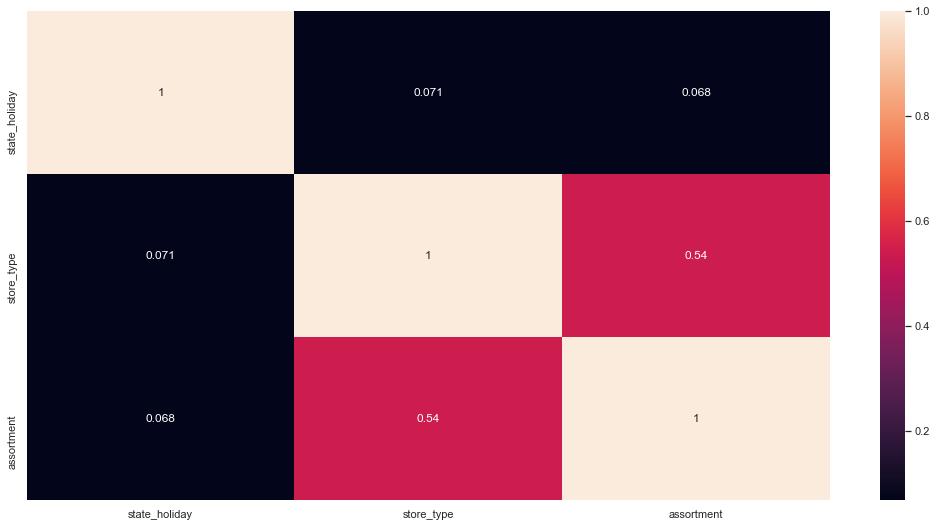

In [300]:
sns.heatmap (d, annot=True)

Temos acima as correlações entre variáveis categóricas.
Notamos que state_holiday tem correlação média com store_type.

In [375]:
#Save CSV:
df4.to_csv('4_exploratory_data_analysis_done.csv', index=False) #index=False if I have first columns as index, to avoid saving with the unnamed:0. Don't save the index, and won't have column unnamed:0 created nor problem to load it.
#no import needed, no message will appear.

In [360]:
df5 = df4.copy()

NameError: name 'df4' is not defined

Checkpoint 01

In [361]:
                            # lê todo o arquivo de uma vez 
df5 = pd.read_csv("../data/4_exploratory_data_analysis_done.csv", low_memory=False)

In [362]:
df5.dtypes
#Converter 'date' de obj para datetieme
df5['date'] = pd.to_datetime(df5['date'] )
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

In [363]:
df5.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## Normalização

Vamos primieramente avaliar quais variáveis serão normalizadas, olhando suas distribuições em EDA -> Análise Univariada -> Numerical Variable.

Notamos lá nos histogramas que não temos nenhuma variável com distribuição normal, logo não vamos normalizar nada neste projeto, e vamos fazer reescaling de todas as variáveis. 

## Rescaling

Identificar primeiramente as variáveis que vamos aplicar o rescaling.
Selecionar as variáveis numéricas:

In [365]:
a = df5.select_dtypes ( include=['int64','float64'] )

In [366]:
a.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo2_time_week
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


Variáveis que vamos aplicar o rescaling estão listadas abaixo, e as de natureza cíclica foram encaminhadas para o Transformation de natureza cíclica mais abaixo.

In [ ]:
#competition_distance
#competition_time_month
#promo2_time_week
#year

Qual técnica escolher?
Se poucos outliers, aplicar Min Max Scaler.
Se muitos outliers, aplicar Robust Scaler.

Vamos analisar cada variável:

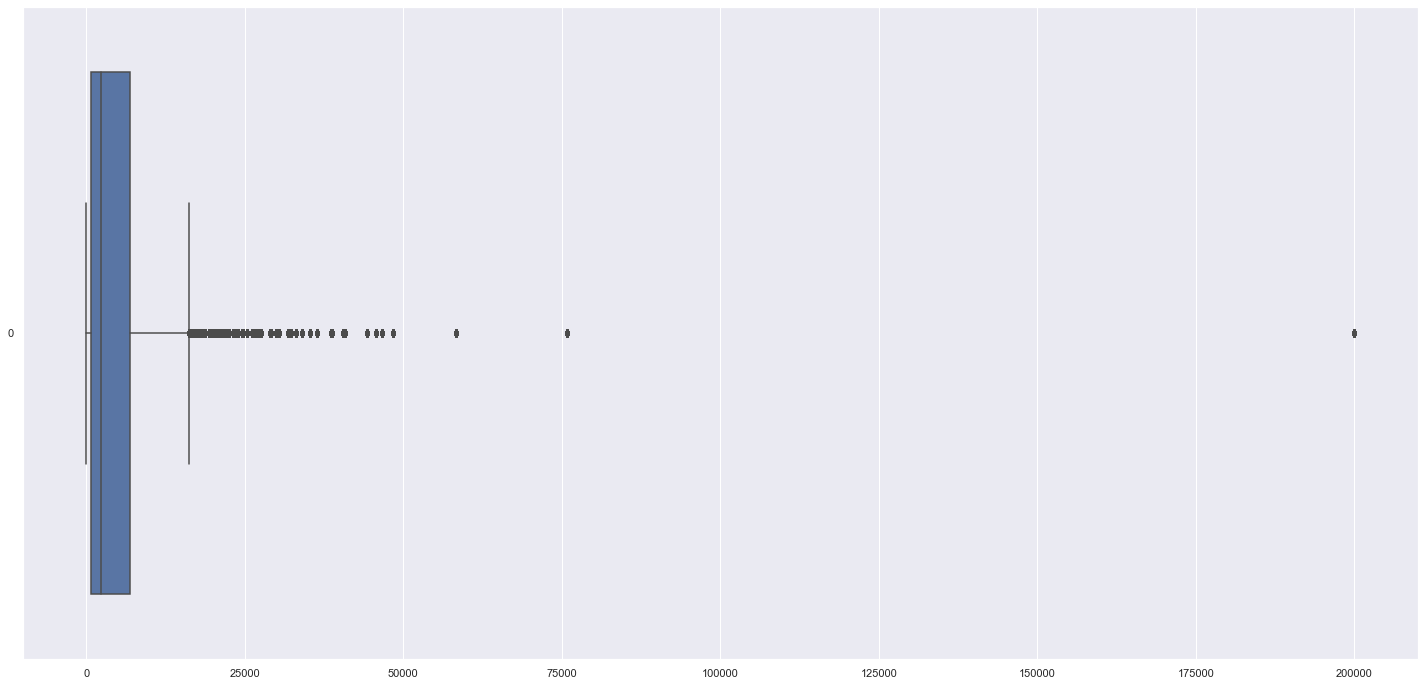

In [40]:
sns.boxplot(data= df5['competition_distance'], orient='h' ); #tem muitos outliers -> Robust

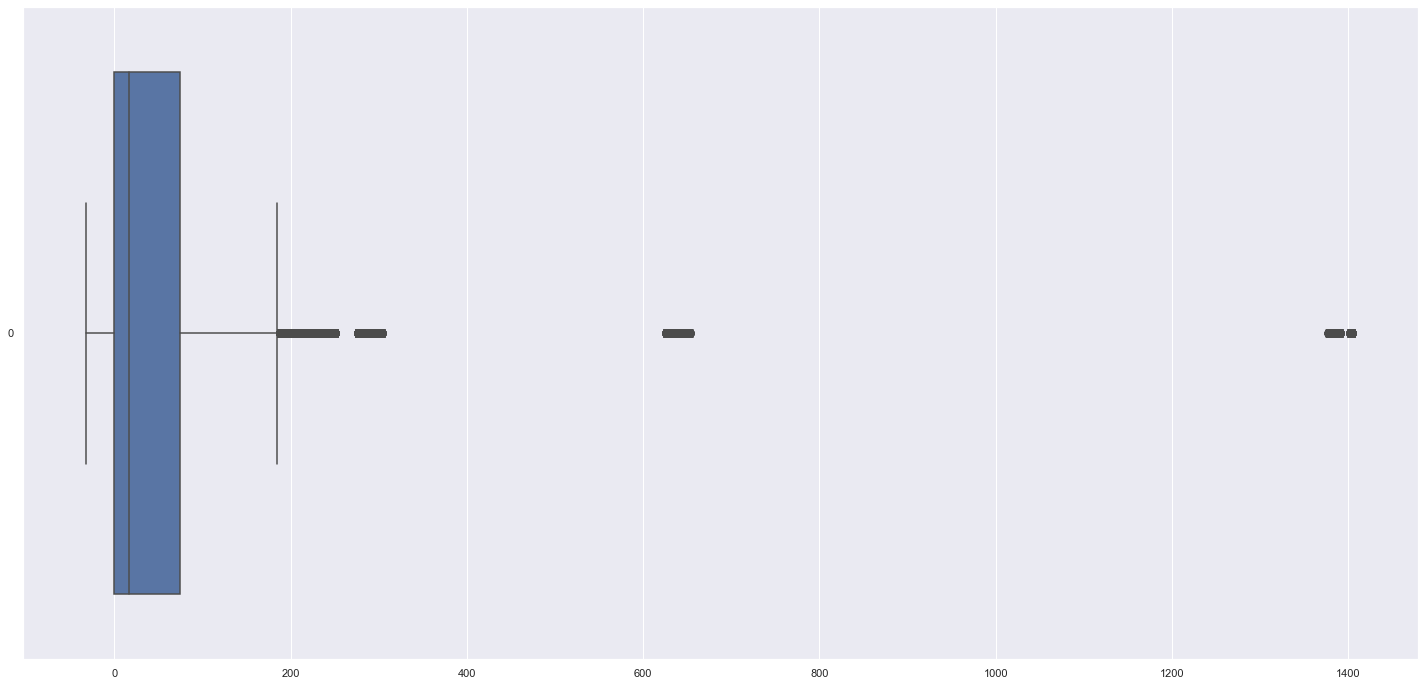

In [44]:
sns.boxplot(data= df5['competition_time_month'], orient='h' ); #tem muitos outliers -> Robust Scaler

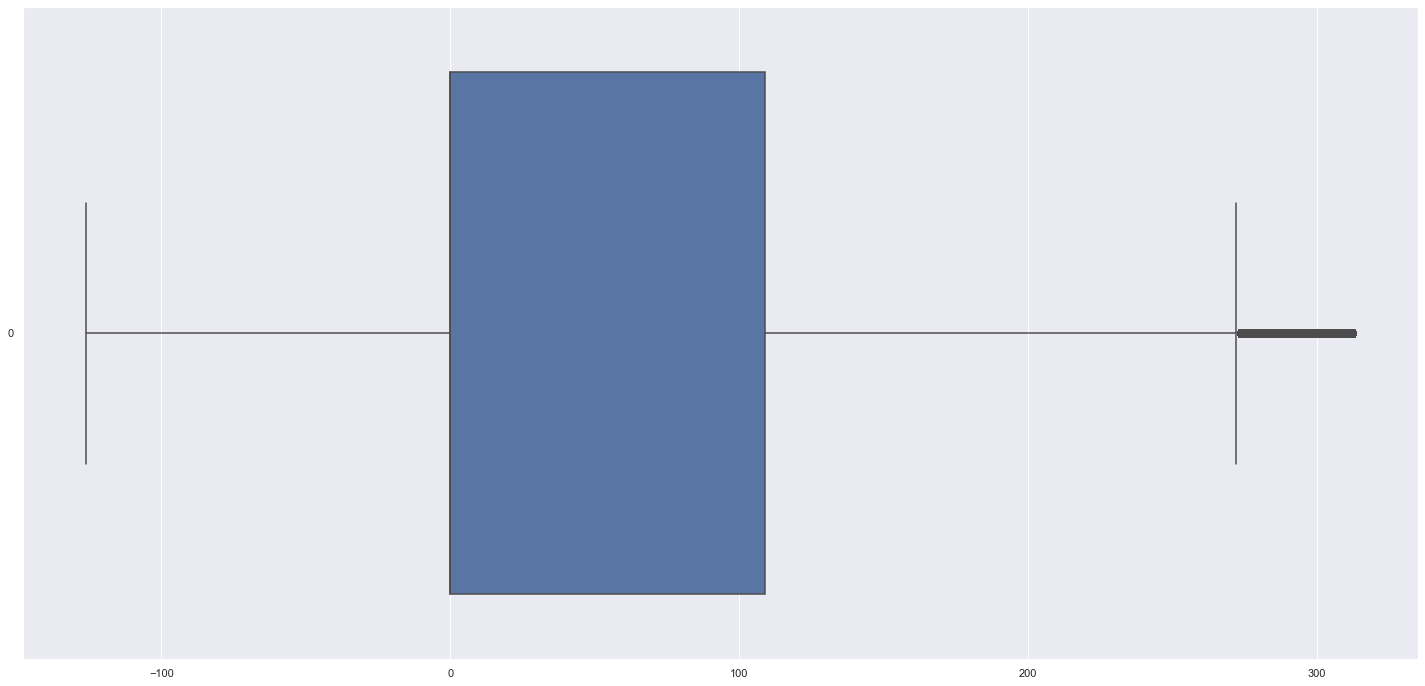

In [45]:
sns.boxplot( data= df5['promo2_time_week'], orient='h'); #tem poucos outliers -> Min Max Scaller

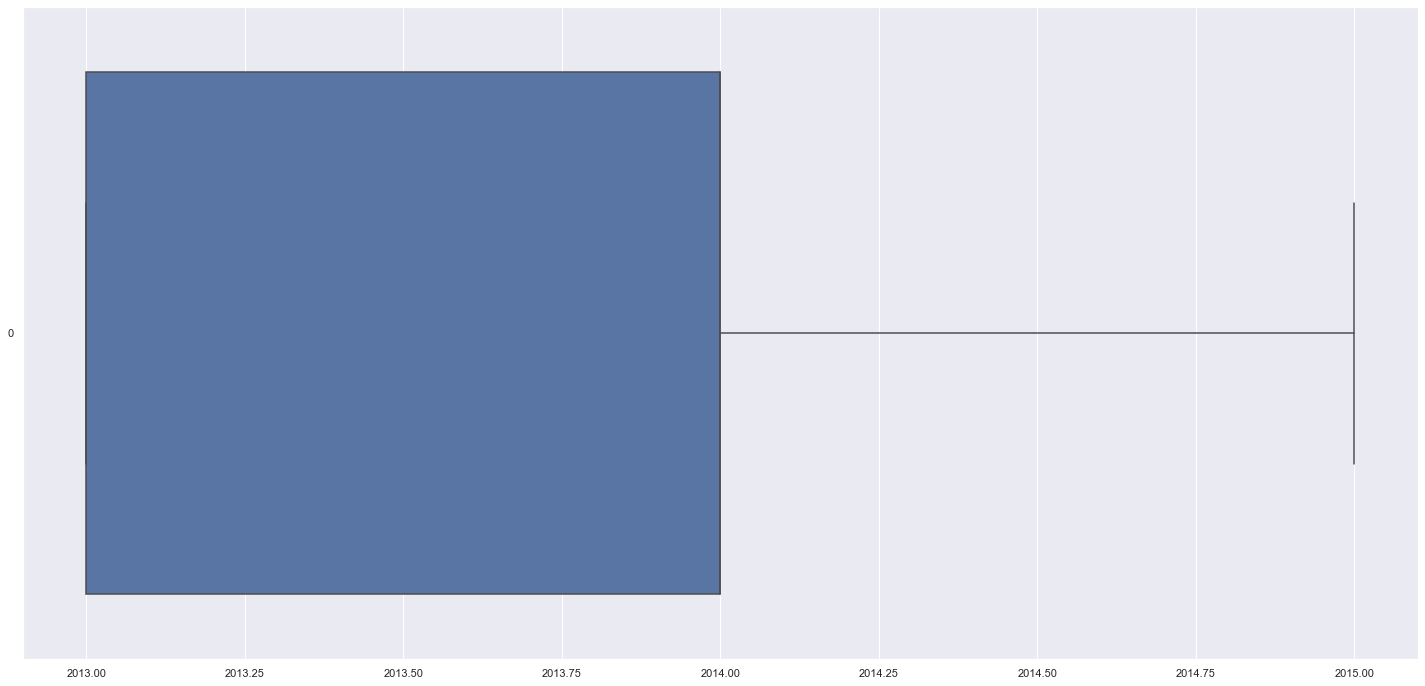

In [47]:
sns.boxplot( data= df5['year'], orient='h' ); #sem outliers -> Min Max Scaller

In [367]:
#instancia Robust Scaller e Min Max Scaller:
rs = RobustScaler()
mms = MinMaxScaler()

#função fit_transform encontra os quartis 1 e 3 da coluna e aplica a formula. 
#Vamos aplicar nas variáveis:

#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values ) 
#salvar para uso na API, wb= escrita
pickle.dump (rs, open ('../parameter/competition_distance_scaler.pkl', 'wb') )

#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values ) 
pickle.dump (rs, open ('../parameter/competition_time_month_scaler.pkl', 'wb') )

#promo2_time_week
df5['promo2_time_week'] = mms.fit_transform(df5[['promo2_time_week']].values ) 
pickle.dump (rs, open ('../parameter/promo2_time_week_scaler.pkl', 'wb') )

#year
df5['year'] = mms.fit_transform(df5[['year']].values ) 
pickle.dump (mms, open ('../parameter/year_scaler.pkl', 'wb') )

Vamos observar agora as 4 variáveis reescaladas:

/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


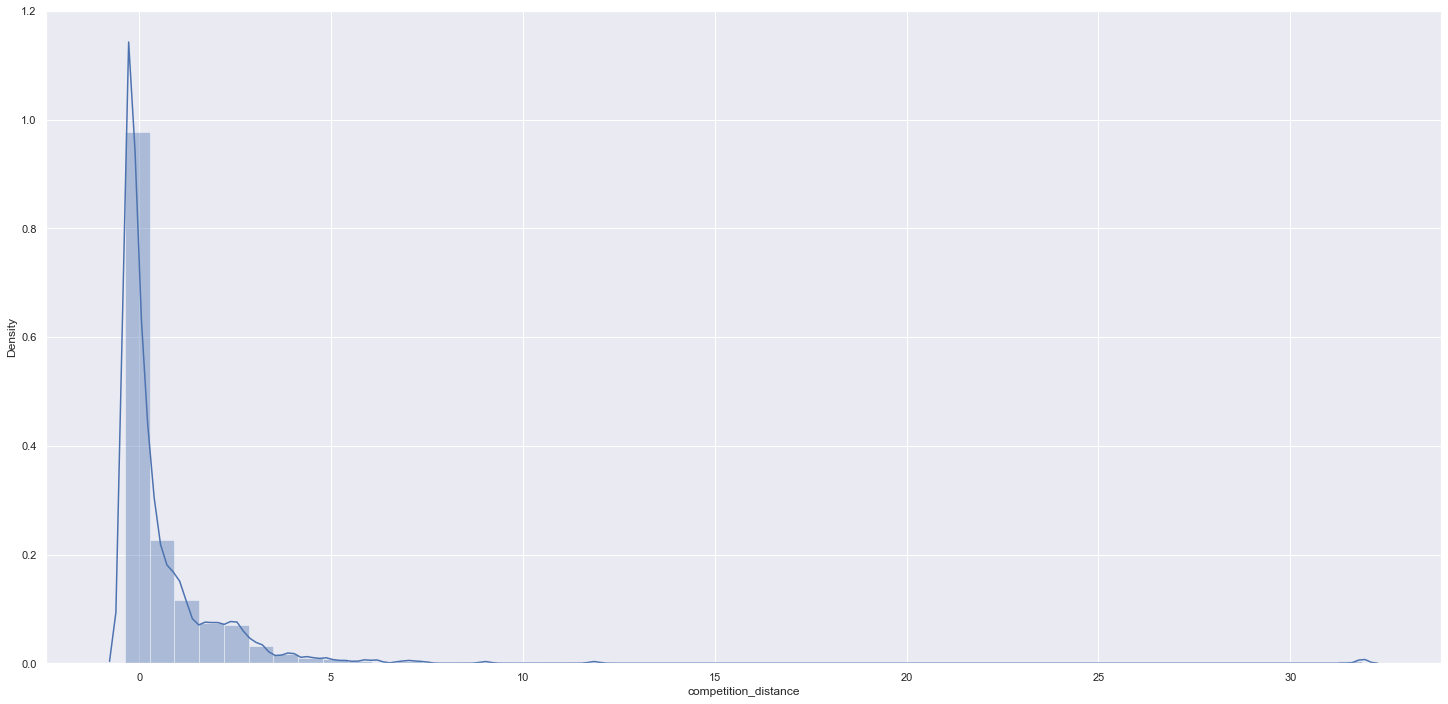

In [54]:
sns.distplot( df5['competition_distance'] );

/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


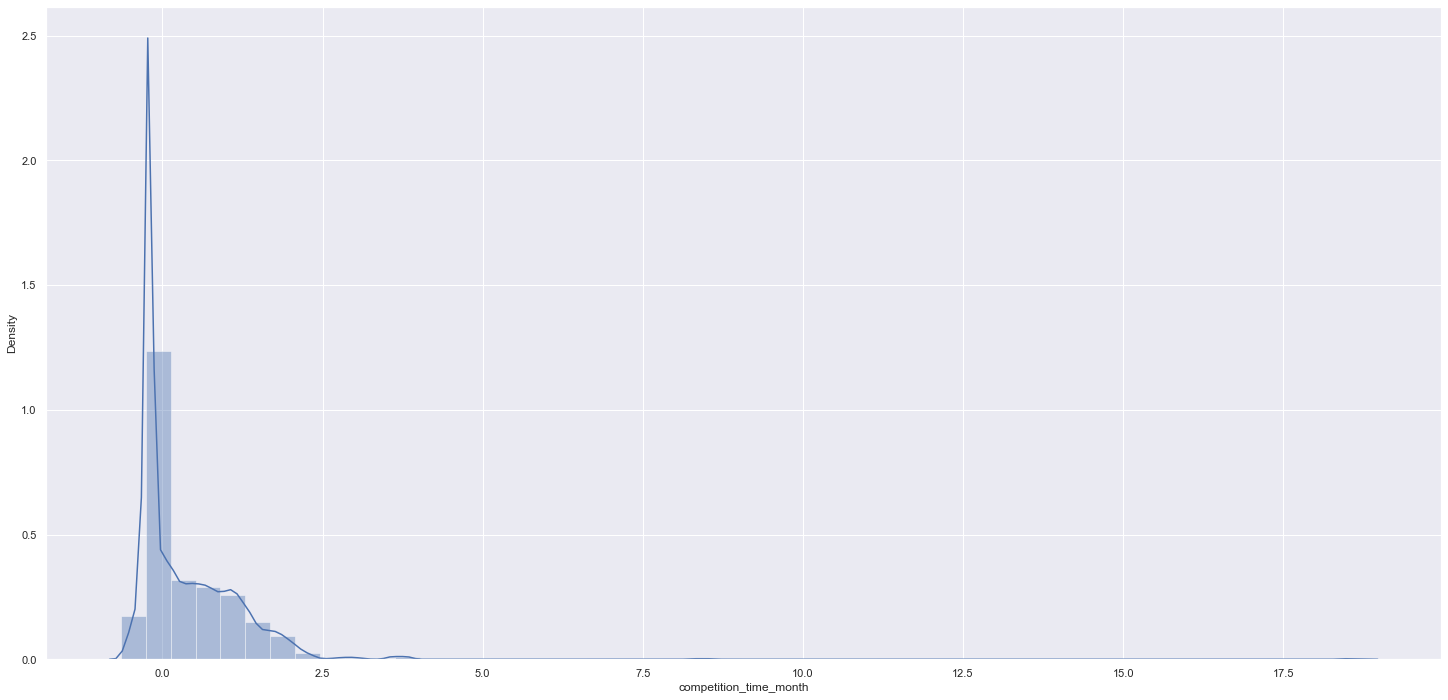

In [55]:
sns.distplot( df5['competition_time_month'] );

/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


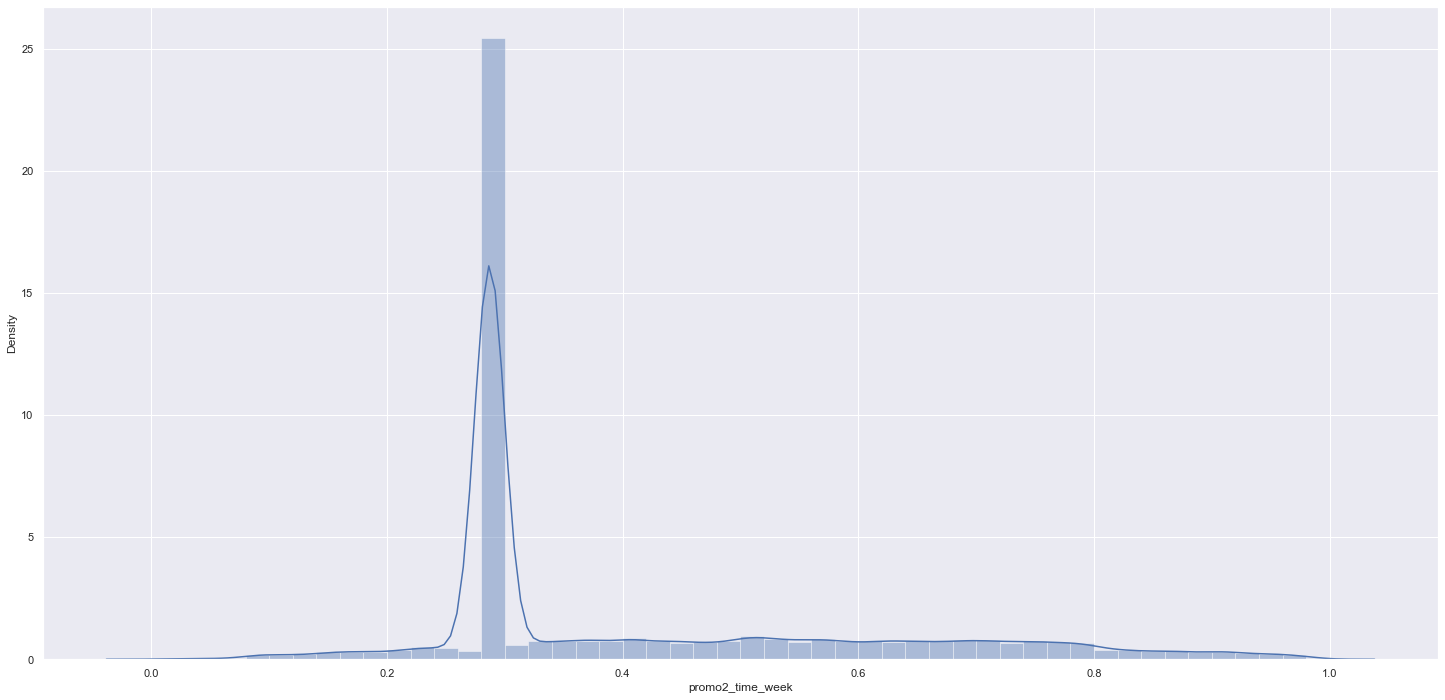

In [56]:
sns.distplot( df5['promo2_time_week'] );

/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


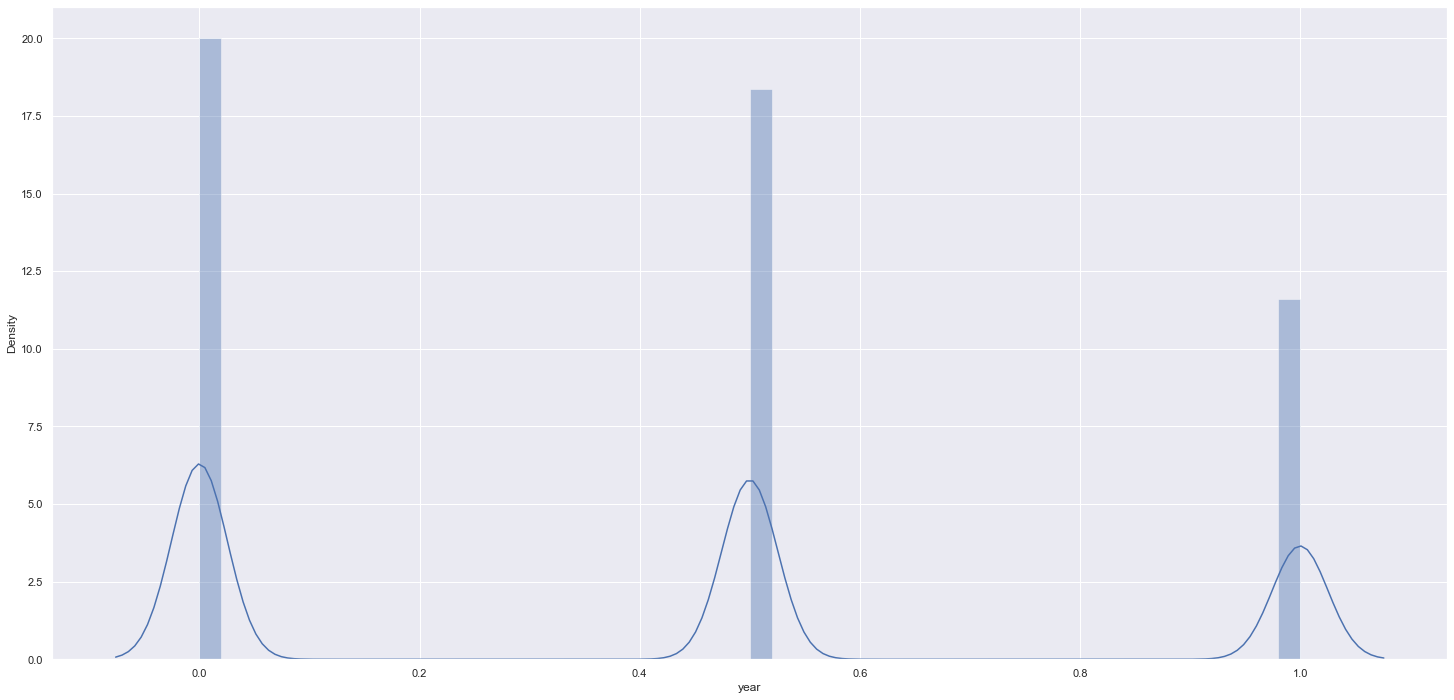

In [58]:
sns.distplot( df5['year'] );

## Transformação

### Encoding

Vamos aplicar o encoding nas variáveis categóricas. Vamos listar elas abaixo:

In [60]:
df5.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [ ]:
#variáveis categóricas:

#state_holiday
#store_type
#assortment

#### state_holiday - (One-Hot-Encoding)

state_holiday: é um estado, estou num estado de natal, depois vou pra estado de dias normais.
Vou usar one hot encoding aqui.

In [65]:
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

In [66]:
#vai criar as 4 colunas novas das possíveis variações agora:
df5.head()

,store,day_of_week,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,555,1,1,1,2,1,-0.170968,9,2008,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,625,1,1,1,0,1,-0.283871,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,821,1,1,1,0,1,1.903226,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1498,1,1,1,2,3,-0.275806,9,2009,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,559,1,1,1,0,1,4.448387,4,2015,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


#### store_type (Label Encoding)

store_type: vamos usar label encoding, porque não há ordem explícita nas categorias a, b e c.

In [69]:
#instanciar
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
#exportar para uso na API
pickle.dump( le, open( '../parameter/store_type_scaler.pkl', 'wb' ) )

In [67]:
#vai ter trocado aleatoriamente as letras por números, e atribuí na mesma coluna:
df5.head()

,store,day_of_week,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,555,1,1,1,2,1,-0.170968,9,2008,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,625,1,1,1,0,1,-0.283871,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,821,1,1,1,0,1,1.903226,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1498,1,1,1,2,3,-0.275806,9,2009,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,559,1,1,1,0,1,4.448387,4,2015,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


#### assortment (Ordinal Encoding)

assortment tem uma ordem: basic, extra, extended, vamos manter esta ordem então, e usar Ordinal Encoding

In [63]:
#explicitar a ordem em dict:
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

In [68]:
#vai ter substituído pela escala
df5.head()

,store,day_of_week,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,555,1,1,1,2,1,-0.170968,9,2008,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,625,1,1,1,0,1,-0.283871,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,821,1,1,1,0,1,1.903226,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1498,1,1,1,2,3,-0.275806,9,2009,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,559,1,1,1,0,1,4.448387,4,2015,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


Nada impede fazer o target encoding pra todas, por exemplo. No primiero ciclo do Crisp, faz pelo feeling, e melhora mais tarde, pra não perder muito tempo aqui e colocar rodar logo.

### Response Variable Transformation

/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


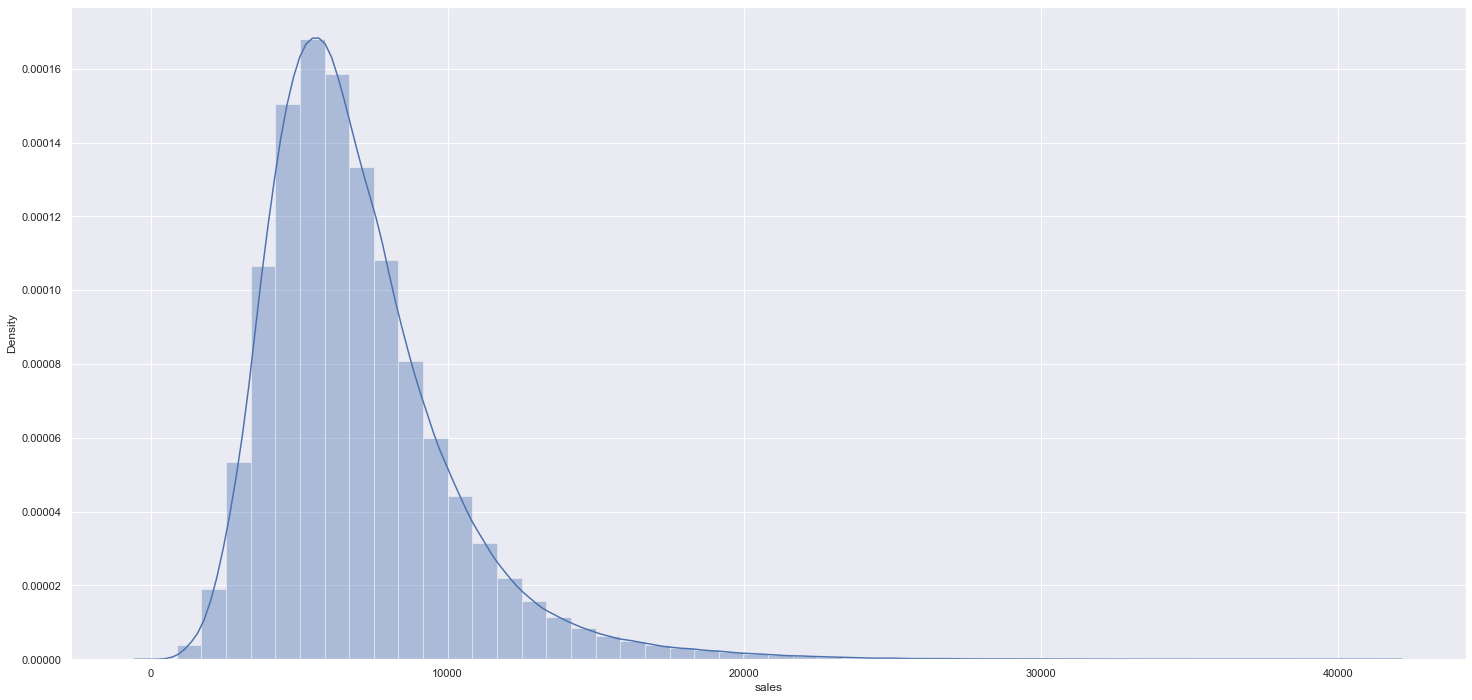

In [71]:
#Notamos que sales atualmente tem uma skew positiva leve:
sns.distplot( df5['sales'] );

In [72]:
#vamos normalizar com Transformação Logarítmica:
df5['sales'] = np.log1p (df5['sales'] )

/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


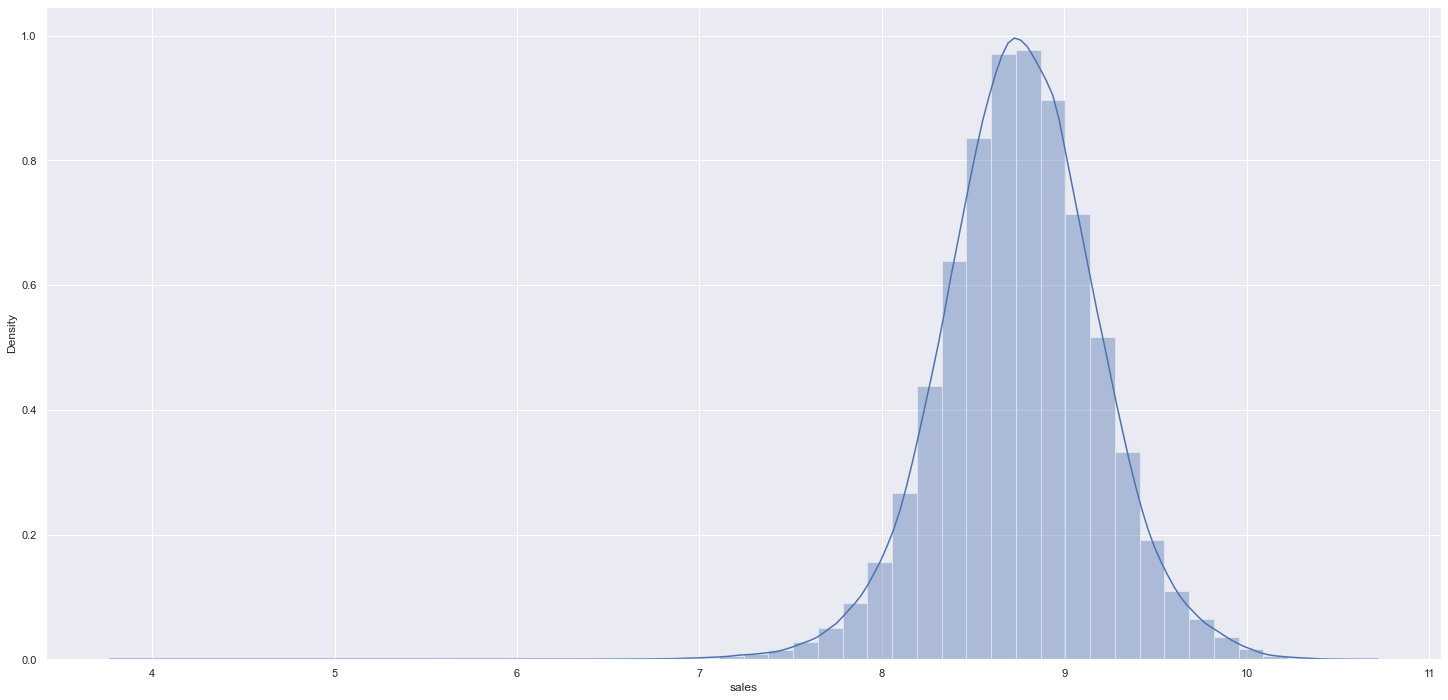

In [73]:
#resultado: distribuição mais pra direita, normalizada
sns.distplot( df5['sales'] );

### Nature Transformation

In [74]:
df5.head()

,store,day_of_week,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,8.568646,555,1,1,1,2,1,-0.170968,9,2008,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,8.710290,625,1,1,1,0,1,-0.283871,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,9.025816,821,1,1,1,0,1,1.903226,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,9.546527,1498,1,1,1,2,3,-0.275806,9,2009,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,8.481151,559,1,1,1,0,1,4.448387,4,2015,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [ ]:
#Variáveis de natureza ciclica: 

#month
#day
#day_of_week
#week_of_year

#Obs: year não é cíclico, pois nunca se repete, já foi tratado anteriormente.

In [75]:
#month
df5['month_sin'] = df5['month'].apply (lambda x: np.sin(x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply (lambda x: np.cos(x * ( 2. * np.pi/12 ) ) )

#day
df5['day_sin'] = df5['day'].apply (lambda x: np.sin(x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply (lambda x: np.cos(x * ( 2. * np.pi/30 ) ) )

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply (lambda x: np.sin(x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply (lambda x: np.cos(x * ( 2. * np.pi/52 ) ) )

#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply (lambda x: np.sin(x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply (lambda x: np.cos(x * ( 2. * np.pi/7 ) ) )

In [76]:
df5.sample(5)

,store,day_of_week,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
779150,394,1,2013-03-11,8.623893,492,1,0,0,3,1,1.374194,3,2013,0,11,2013,0,Mar,0,0.0,3,11,11,2013-10,2013-03-01,-0.216216,2013-03-11,0.287016,0,0,0,1,1.000000,6.123234e-17,0.743145,-0.669131,0.970942,0.239316,0.781831,0.623490
419092,523,4,2014-04-03,9.420034,1446,1,1,0,2,3,-0.367742,11,2013,0,14,2014,0,Apr,0,0.5,4,3,14,2014-13,2013-11-01,-0.148649,2014-03-31,0.287016,0,0,0,1,0.866025,-5.000000e-01,0.587785,0.809017,0.992709,-0.120537,-0.433884,-0.900969
665603,82,6,2013-07-13,8.557375,462,1,0,0,0,1,3.235484,4,2008,1,37,2009,"Jan,Apr,Jul,Oct",Jul,1,0.0,7,13,28,2013-27,2008-04-01,0.648649,2009-09-07,0.742597,0,0,0,1,-0.500000,-8.660254e-01,0.406737,-0.913545,-0.239316,-0.970942,-0.781831,0.623490
419308,740,4,2014-04-03,8.924789,528,1,1,0,3,1,0.656452,3,2014,0,14,2014,0,Apr,0,0.5,4,3,14,2014-13,2014-03-01,-0.202703,2014-03-31,0.287016,0,0,0,1,0.866025,-5.000000e-01,0.587785,0.809017,0.992709,-0.120537,-0.433884,-0.900969
62316,329,3,2015-05-27,8.770129,619,1,0,0,0,1,-0.164516,6,1990,1,22,2012,"Mar,Jun,Sept,Dec",May,0,1.0,5,27,22,2015-21,1990-06-01,3.891892,2012-05-21,0.644647,0,0,0,1,0.500000,-8.660254e-01,-0.587785,0.809017,0.464723,-0.885456,0.433884,-0.900969


In [78]:
#Save CSV:
df5.to_csv('../data/5_data_preparation_done.csv', index=False) #index=False if I have first columns as index, to avoid saving with the unnamed:0. Don't save the index, and won't have column unnamed:0 created nor problem to load it.
#no import needed, no message will appear.

In [79]:
df6 = df5.copy()

In [80]:
df6.head()

,store,day_of_week,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,555,1,1,1,2,1,-0.170968,9,2008,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,625,1,1,1,0,1,-0.283871,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,821,1,1,1,0,1,1.903226,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1498,1,1,1,2,3,-0.275806,9,2009,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,559,1,1,1,0,1,4.448387,4,2015,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


In [81]:
#remover variáveis que foram usadas pra criar outras e não são mais necessárias:
#promo2_since originou promo_time_week, então vou remover. competition_since e year_week também.
cols_drop = ['week_of_year','day','month','day_of_week','promo2_since', 
             'promo_interval', 'competition_since', 'year_week', 'month_map' ]
#date e sales tem que deletar também, mas vamos usar pra uns cálculos, então faremos depois
df6 = df6.drop( cols_drop, axis=1) 

In [82]:
df6.head()

,store,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,2015-07-31,8.568646,555,1,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,2015-07-31,8.710290,625,1,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,1.054054,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,2015-07-31,9.025816,821,1,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,1.202703,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,2015-07-31,9.546527,1498,1,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,2015-07-31,8.481151,559,1,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,-0.162162,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


## Split dataframe into training and test dataset

Dados de treino: parte do dataset usada pra trainar o modelo.
Dados de teste: parte do dataset usado pra medir a acurácia.
Não posso selecionar aleatoriamente os dados pra cada um. Senão com a amostra de alguns dados futuros que tenho no teste, o modelo já os conhece e vai acertar, decorar. Isso é Overfitar.

Neste caso, vou pegar as últimas 6 semanas de venda, e separar isto para teste.
Todas as vendas antes disso, serão treino.

In [ ]:
#pegar data mínima (inicial) de venda de cada loja:
df6[['store', 'date']].groupby( 'store' ).min().reset_index()

In [ ]:
#pegar data máxima (final) de venda de cada loja:
df6[['store', 'date']].groupby( 'store' ).max().reset_index()

In [85]:
#pegar 60 dias antes da última data
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - dt.timedelta( days=6*7 ) 

Timestamp('2015-06-19 00:00:00')

In [86]:
#Dinâmica:
# X = dataset todo
# Y = var resposta

#training dataset:
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales'] #Meigarom usou 'y_train'

#test dataset:
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales'] #Meigarom usou 'y_test'

#Conferência das data (ok)
print ('Traning Min Date: ',X_train['date'].min() )
print ('Traning Max Date: ', X_train['date'].max() )

print ('\nTest Min Date: ', X_test['date'].min() )
print ('Test Max Date: ', X_test['date'].max() )

Traning Min Date:  2013-01-01 00:00:00
Traning Max Date:  2015-06-18 00:00:00

Test Min Date:  2015-06-19 00:00:00
Test Max Date:  2015-07-31 00:00:00


In [87]:
#whole dataset - training
X_train.head()

,store,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
41396,1,2015-06-18,8.443762,498,1,1,0,2,1,-0.170968,9,2008,0,25,2015,0,1.0,0.891892,0.287016,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
41397,2,2015-06-18,8.547722,594,1,1,0,0,1,-0.283871,11,2007,1,13,2010,0,1.0,1.027027,0.908884,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
41398,3,2015-06-18,8.927712,743,1,1,0,0,1,1.903226,12,2006,1,14,2011,0,1.0,1.189189,0.788155,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
41399,4,2015-06-18,9.091669,1138,1,1,0,2,3,-0.275806,9,2009,0,25,2015,0,1.0,0.729730,0.287016,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
41400,5,2015-06-18,8.502080,545,1,1,0,0,1,4.448387,4,2015,0,25,2015,0,1.0,-0.189189,0.287016,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969


In [88]:
#whole dataset - test
X_test.head()

,store,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,2015-07-31,8.568646,555,1,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,2015-07-31,8.710290,625,1,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,1.054054,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,2015-07-31,9.025816,821,1,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,1.202703,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,2015-07-31,9.546527,1498,1,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,2015-07-31,8.481151,559,1,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,-0.162162,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


In [89]:
#response var - training
#id | vendas (normalizado já)
y_train.head()

41396    8.443762
41397    8.547722
41398    8.927712
41399    9.091669
41400    8.502080
Name: sales, dtype: float64

In [90]:
#response var - test
#id | vendas (normalizado já)
y_test.head()

0    8.568646
1    8.710290
2    9.025816
3    9.546527
4    8.481151
Name: sales, dtype: float64

## Boruta as Feature Selector (Seleção por Subset - Wrapper Methods)

In [91]:
X_train.head()

,store,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
41396,1,2015-06-18,8.443762,498,1,1,0,2,1,-0.170968,9,2008,0,25,2015,0,1.0,0.891892,0.287016,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
41397,2,2015-06-18,8.547722,594,1,1,0,0,1,-0.283871,11,2007,1,13,2010,0,1.0,1.027027,0.908884,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
41398,3,2015-06-18,8.927712,743,1,1,0,0,1,1.903226,12,2006,1,14,2011,0,1.0,1.189189,0.788155,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
41399,4,2015-06-18,9.091669,1138,1,1,0,2,3,-0.275806,9,2009,0,25,2015,0,1.0,0.729730,0.287016,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
41400,5,2015-06-18,8.502080,545,1,1,0,0,1,4.448387,4,2015,0,25,2015,0,1.0,-0.189189,0.287016,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969


In [443]:
#training and test dataset for Boruta
    #.values pra pegar só os valores, sem o header, deletamos date e sales por serem dados de treino
X_train_n = X_train.drop( ['date','sales'],axis=1 ).values
    #ravel pra colocar num vetor contínuo todos os valores de sales contidos em Y_train
y_train_n = y_train.values.ravel()

#define RandomForestRegressor
    #n_jobs=-1 pra usar todos cores da máquina, usando paralelismo
rf = RandomForestRegressor( n_jobs=-1 )

#define Boruta
    #instancia, usando Randon Forest, n_estimators é o número de galhos, 
    # verbose=2 pra ver o log, pois demora um pouco, random_state=42 pra partir do mesmo início
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	11


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	11


Log do Boruta:

Iteration: número de iterações até o Boruta decidir as features
Confirmed: features relevantes pro modelo
Tentative: teve dúvida, nesta iteração não conseguiu classificar
Rejected: variáveis já rejeitadas como relevantes

### Best features from Boruta

In [450]:
#retorna True ou False pra cada coluna
cols_selected = boruta.support_.tolist()

#obter lista das features selecionadas a partir de cols_selected (True e False pra cada coluna)
X_train_fs = X_train.drop( ['date','sales'],axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns

#obter lista das features não selecionadas
cols_not_selected_boruta = list (np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## Manual Feature Selection

In [451]:
cols_selected_boruta

Index(['store', 'customers', 'promo', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'competition_time_month', 'promo2_time_week',
       'month_cos', 'day_cos', 'week_of_year_cos', 'day_of_week_sin',
       'day_of_week_cos'],
      dtype='object')

In [452]:
cols_not_selected_boruta

['day_sin',
 'is_promo',
 'month_sin',
 'open',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

Tendo os resultados das variáveis que o Boruta considera relevantes, vamos comparar com as que eu como DS considerei ALTA relevância lá na EDA.
Vamos fazer um merge disso.

Minha análise:
H9:
sobre o 'year', Boruta descartou, mas eu vi que é relevante.
A decisão como DS é minha.
Sendo a primeira iteração, vou seguir só com as vars sugeridas pelo Boruta, e no segundo ciclo, adiciono year e vejo se a acurácia aumenta.
A EDA é relevante pra questionar a avaliação dos algoritmos com meu feeling.

H10
sobre o 'month', Boruta considerou só o 'month_cos' como relevante. Vamos colocar 'month_sin' também.

H11
sobre o 'day', Boruta considerou só 'day_cos', Vamos colocar 'day_sin' também.

H12
sobre 'day_of_week', Boruta considerou ambos: 'day_of_week_sin' e 'day_of_week_cos'

Por fim, 'week_of_year_sin' também será considerada relevante por nós, apesar do Boruta não considerar.

Salvar agora o resultado do boruta, incluindo as considerações acima, pra não precisar rodar novamente:

In [92]:
cols_not_selected_boruta = [
    'is_promo',
    'open',
    'school_holiday',
    'state_holiday_christmas',
    'state_holiday_easter_holiday',
    'state_holiday_public_holiday',
    'state_holiday_regular_day',
    'year']


In [494]:
cols_selected_boruta = [
    'store', 
    'promo', 
    'store_type', 
    'assortment',
    'competition_distance', 
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2', 
    'promo2_since_week',
    'promo2_since_year', 
    'competition_time_month', 
    'promo2_time_week',
    'month_cos',
    'month_sin',#added manually by me, was not sel. by Boruta
    'day_cos',
    'day_sin',#added manually by me, was not sel. by Boruta
    'week_of_year_cos', 
    'week_of_year_sin',#added manually by me, was not sel. by Boruta
    'day_of_week_sin',
    'day_of_week_cos']

# incluir de volta o date (vamos usar pra separar o dataset mais pra frente) 
# e o sales (é nossa var resposta, vamos precisar dela pra treinar o algoritmo)

#columns to add
feat_to_add = ['date', 'sales']

#final features 
#cria cols_selected_boruta_full, que contém 'date' e 'sales', pra manter cols_selected_boruta sem eles.
cols_selected_boruta_full = cols_selected_boruta.copy()
    #extend adiciona uma lista na outra
cols_selected_boruta_full.extend (feat_to_add)

In [495]:
#removido o customers:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'month_cos',
 'month_sin',
 'day_cos',
 'day_sin',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_week_cos']

In [508]:
#removido o customers:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'month_cos',
 'month_sin',
 'day_cos',
 'day_sin',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_week_cos',
 'date',
 'sales']

In [94]:
cols_selected_boruta

['store',
 'customers',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'month_cos',
 'month_sin',
 'day_cos',
 'day_sin',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_week_cos']

In [95]:
#Save CSV:
df6.to_csv('../data/6_feature_selection.csv', index=False) #index=False if I have first columns as index, to avoid saving with the unnamed:0. Don't save the index, and won't have column unnamed:0 created nor problem to load it.
#no import needed, no message will appear.

In [103]:
X_train[ cols_selected_boruta_full ].head()

,store,customers,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos,date,sales
41396,1,498,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.443762
41397,2,594,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.547722
41398,3,743,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.927712
41399,4,1138,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,9.091669
41400,5,545,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.502080


In [105]:
X_test[ cols_selected_boruta_full ].head()

,store,customers,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos,date,sales
0,1,555,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,8.568646
1,2,625,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,8.710290
2,3,821,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,9.025816
3,4,1498,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,9.546527
4,5,559,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,8.481151


In [116]:
#conferência:
print ('Data inicial Treino: ', X_train[ cols_selected_boruta_full ]['date'].min() )
print ('Data final Treino: ', X_train[ cols_selected_boruta_full ]['date'].max() )

print ('\nData inicial Teste: ', X_test[ cols_selected_boruta_full ]['date'].min() )
print ('Data final Teste: ', X_test[ cols_selected_boruta_full ]['date'].max() )

Data inicial Treino:  2013-01-01 00:00:00
Data final Treino:  2015-06-18 00:00:00

Data inicial Teste:  2015-06-19 00:00:00
Data final Teste:  2015-07-31 00:00:00


In [496]:
#criar vars treino e teste só com o que o Boruta Selecionou: 
    #peguei cols_selected_boruta e não cols_selected_boruta_full, pra não pegar 'date' e 'sales', que não são 
    #usados pra treinar o modelo
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

In [497]:
x_train.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos
41396,1,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41397,2,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41398,3,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41399,4,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41400,5,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969


In [461]:
x_train.head() #old

,store,customers,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos
47945,1,498,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
47946,2,594,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
47947,3,743,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
47948,4,1138,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
47949,5,545,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969


In [498]:
x_test.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521
3,4,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521


In [462]:
x_test.head() #old

,store,customers,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos
0,1,555,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521
1,2,625,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521
2,3,821,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521
3,4,1498,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521
4,5,559,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521


Agora, vamos testar 5 modelos:

## Average Model

É a média de vendas de cada uma das lojas.
Média é um modelo linear (para dados com comportamento mais simples)

Criar função para cálculo do erro:

In [499]:
#existe a função mean_absolute_percentage_error pronta no pacote sklearn.metrics, e recebe 
# os mesmos 2 params, mas o resultado dela difere desta abaixo feita pelo Meigarom quando
# não existia:

# def mean_absolute_percentage_error_fun (y, yhat):
#     return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    """ Calcula os erros do modelo passado 
    model_name: nome do modelo
             y: valores de vendas reais
          yhat: valores de vendas estimados pelo modelo """
    mae = mean_absolute_error (y, yhat)
    mape = mean_absolute_percentage_error( y, yhat ) #mean_absolute_percentage_error_fun( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse  }, index=[0] )

Calcular o erro do modelo de Média:

In [500]:
#actual sales -------------------------------------------------------------------
#Já temos Y_test (ok)

#prediction sales ------------------------------------------------------------------
#Cria aux1, a partir dos dados de teste: DS Todo (em x_test) e Vendas (em Y_test)
aux1 = x_test.copy()
aux1['sales'] = y_test.copy() #Y_test: (loja|venda)
    #agora tenho o ds original em aux1, só com ados de teste

#---- Como estamos modelando a média, vamos obter o valor médio de vendas por loja dos dados de teste
aux2 = aux1[['store','sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales':'predictions'} )
    #temos agora em aux2 todas as predições (médias de venda por loja do dataset teste)
#agora, precisamos anexar de volta:
aux1 = pd.merge(aux1, aux2, how='left', on='store')
#y~ na matemática é tudo o que é estimado. 
# Chamo agora de 'predictions' as vendas previstas (a partir da média simples) do DS de teste por loja
yhat_baseline = aux1['predictions'] 
    
#performance ---------------------------------------------------------------------
    #passo nome do modelo, y_test sendo as vendas reais e yhat_baseline sendo as predições de vendas por loja pela média
    #Lá em cima na Transf. da Var Resposta, fizemos o log de vendas. O oposto do log é o exponencial.
        #Vamos usar np.expm1 agora então pra voltar pros valores originais aplicando o exponencial.
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline)  )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


In [501]:
yhat_baseline.head()

0    8.373392
1    8.460676
2    8.795885
3    9.194715
4    8.346624
Name: predictions, dtype: float64

## Linear Regression Model

In [509]:
#treina o modelo
    #.fit() treina o modelo com dados de treino (y_train = vendas, x_train = demais vars)
lr = LinearRegression().fit( x_train, y_train)

#extrai previsão do modelo
    #predict() faz a previsão com dados de teste (apenas x_test, sem vendas)
yhat_lr = lr.predict ( x_test )

#calcula performance
    #passa vendas reais de teste (y_test), vs as predições do modelo (yhat_lr):
lr_result = ml_error ( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


ps: RMSE do Meigarom deu 2671.049215 no Linear Regression Model.

Análise do ERRO RMSE:
O Erro RMSE do modelo de regressão linear é muito maior que o erro do modelo de média.
Logo:
1 - o modelo de média é melhor que a regressão linear aqui
2 - isto nos diz que os dados tem comportamento complexo (não linear), e muito provavelmente modelos não lineares não vão conseguir aprender este comportamento.
Vamos implementar o Regularized só pra ter o modelo implementado.

### Linear Regression Model - Cross Validation

In [510]:
lr_result_cv = cross_validation( x_training, 5 , "Linear Regression", lr, verbose=False )
lr_result_cv

,Model Nme,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 ± 295.63,0.3 ± 0.02,2952.52 ± 468.37


Notamos que ao fazer só com um pedaço do dataset antes (lr_result), o RMSE foi de 3371.
Agora, ao fazer com todas as partes através da fução cross_validation, o RMSE foi de 3536. 
Vale notar que o RMSE do lr_result está dentro da variação do RMSE do lr_result_cv.
Haviamos pego então um pedaço "bom" pra fazer a predição, e o erro antes deu menor.
Por isso do cross validation, passar por vários pedaços do dataset, pra pegar a maior variabilidade possível dele.

## Linear Regression Regularized Model - Lasso

In [511]:
#training
    #alfa - fator multiplicador dos pesos, pra ficarem dentro do range desejável
lrr = Lasso (alpha=0.01).fit( x_train, y_train)

#prediction
yhat_lrr = lrr.predict ( x_test )

#performance
lrr_result = ml_error ( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,2744.451735


Comparando o RMSE, também notamos que o erro é bem maior que o RMSE do modelo da média.

Vamos agora implementar dois modelos não-lineares (para dados com comportamento mais complexo)

PS: Atualização: Incluso o cross validation antes abaixo:

### Lasso - Cross Validation

In [512]:
lrr_result_cv = cross_validation( x_training, 5 , "Lasso", lrr, verbose=False )
lrr_result_cv

,Model Nme,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 ± 341.5,0.29 ± 0.01,3057.75 ± 504.26


Análise: o lrr_result quando rodado sobre a última semana de vendas, deu RMSE de 3410
Notamos que foi uma semana um pouco melhor que a média, pois o RMSE médio agora de lrr_result_cv foi de 3541, tendo performance um pouco pior considerando todo o dataset.

## Random Forest Regressor

In [514]:
#model
    #n_estimators=100 -> quantas árvores vai criar (fica legal com umas 3k arvores: leva horas)
    #n_jobs=-1 -> usar todas as threads
    #random_state=42 -> partir da mesma origem aleatória (pode ser qualquer número)
rf = RandomForestRegressor (n_estimators=20, n_jobs=-1, random_state=42 ).fit( x_train, y_train)

#prediction
yhat_rf = rf.predict ( x_test )

#performance
rf_result = ml_error ( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,695.976837,0.102203,1035.324593


### Random Forest Regressor - Cross Validation

In [515]:
#temos usado 5 kfolds, usei 2 pra agilizar:
rf_result_cv = cross_validation( x_training, 2 , "Random Forest Regressor", rf, verbose=True )
rf_result_cv


KFold Number:  2
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-03-25 00:00:00
kFold validation start date:  2015-03-26 00:00:00
kFold validation end date:  2015-05-07 00:00:00

KFold Number:  1
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-05-06 00:00:00
kFold validation start date:  2015-05-07 00:00:00
kFold validation end date:  2015-06-18 00:00:00


,Model Nme,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,792.84 ± 74.58,0.11 ± 0.01,1180.0 ± 147.28


In [659]:
rf_result_cv = cross_validation( x_training, 5 , "Random Forest Regressor", rf, verbose=True )
rf_result_cv


KFold Number:  5

KFold Number:  4

KFold Number:  3

KFold Number:  2

KFold Number:  1


,Model Nme,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,405.43 ± 97.89,0.05 ± 0.01,591.94 ± 145.44


## XGBoost Regressor

In [502]:
#model correto - sem customer!
   
    #random_state=42 -> partir da mesma origem aleatória (pode ser qualquer número)
model_xgb = xgb.XGBRegressor( objective='reg:squarederror', #função objetiva
                             n_estimators=20, #quantas árvores vai criar (fica legal com umas 3k arvores: leva horas)
                             eta=0.01, #quantas passadas usa pra fazer o aprendizado
                             max_depth=10, #máxima ramificação da árvore
                             subsample=0.7, #% das variáveis de amostra pra selecionar as relevantes
                             colsample_bytree=0.9 ).fit( x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict ( x_test )

#performance
xgb_result = ml_error ( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6988.747938,0.998925,7622.820799


In [128]:
#faltou executar novamente, sem o customers!
#model
   
    #random_state=42 -> partir da mesma origem aleatória (pode ser qualquer número)
model_xgb = xgb.XGBRegressor( objective='reg:squarederror', #função objetiva
                             n_estimators=20, #quantas árvores vai criar (fica legal com umas 3k arvores: leva horas)
                             eta=0.01, #quantas passadas usa pra fazer o aprendizado
                             max_depth=10, #máxima ramificação da árvore
                             subsample=0.7, #% das variáveis de amostra pra selecionar as relevantes
                             colsample_bytree=0.9 ).fit( x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict ( x_test )

#performance
xgb_result = ml_error ( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6988.769819,0.998944,7622.75996


Neste momento, não estamos tão preocupados em encontrar o melhor parâmetro. Vamos fazer isso no fine tuning.
Meigarom implementa estes 5 modelos com parâmetros default. O que performar melhor, ele utiliza e coloca em produção logo pra ganhar velocidade (desde que o tipo de problema que o algoritmo resolve seja o que ele tem pra resolver)
Até porque fine tuning não dá salto de 70 pra 80% na acurária. O que dá este salto, são as variáveis utilizadas.

### XGBoost Regressor - Cross Validation

In [156]:
#faltou executar novamente, sem o customers!
#temos usado 5 kfolds, usei 2 pra agilizar:
xgb_result_cv = cross_validation( x_training, 2 , "XGBoost Regressor", model_xgb, verbose=True )
xgb_result_cv


KFold Number:  2
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-03-25 00:00:00
kFold validation start date:  2015-03-26 00:00:00
kFold validation end date:  2015-05-07 00:00:00

KFold Number:  1
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-05-06 00:00:00
kFold validation start date:  2015-05-07 00:00:00
kFold validation end date:  2015-06-18 00:00:00


,Model Nme,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7419.08 ± 128.28,1.0 ± 0.0,8073.2 ± 175.36


In [660]:
xgb_result_cv = cross_validation( x_training, 5 , "XGBoost Regressor", model_xgb, verbose=True )
xgb_result_cv


KFold Number:  5

KFold Number:  4

KFold Number:  3

KFold Number:  2

KFold Number:  1


,Model Nme,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7044.41 ± 588.03,0.95 ± 0.0,7696.95 ± 687.75


## Compare Model's Performance

### Single Performance

In [129]:
#agrupar todos os resultados dos modelos pra ver qual o de menor erro:
modelling_result= pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result ] )
modelling_result.sort_values( 'RMSE' ) #Ordenar pelo modelo com o menor erro

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,387.291454,0.054518,593.724759
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1344.347775,0.183431,3371.671836
0,Linear Regression - Lasso,1413.378546,0.187075,3410.484851
0,XGBoost Regressor,6988.769819,0.998944,7622.759960


PS: Nos resultados do Meigarom, tivemos menor erro em Randos Forest e depois XGBoost (modelos não lineares).
    Usei também só 20 'n_estimators', pois aumenta muito o tempo de execução, mas também aumenta a performance. 

Sendo assim, o problema que estamos resolvendo de previsão de vendas é um problema complexo, logo modelos lineares não funcionam bem pra isto. Vamos resolver com os modelos não lineares.

Olhando apenas o RMSE, usaríamos Random Forest, mas ocorre que pegamos apenas as 6 últimas semanas para teste. Pode acontecer de termos um comportamento esperado nestas semanas, e isto não refletir a realidade.. não generalizar bem.

Por isso, temos o Cross-Validation: cortar várias fatias do dataset, e medir a performance do modelo nestas diferentes partes.
Esta média então será nossa performance real.

### Real Performance - Cross Validation

In [157]:
#agrupar todos os resultados dos modelos pra ver qual o de menor erro: 
    #(2º vez que rodei, com menos k_folds e configs n_estimators menor)
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ] )
modelling_result_cv

,Model Nme,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1440.51 ± 231.33,0.19 ± 0.01,3536.63 ± 703.2
0,Lasso,1516.15 ± 257.71,0.19 ± 0.01,3541.76 ± 732.89
0,Random Forest Regressor,404.76 ± 38.22,0.05 ± 0.0,600.14 ± 85.27
0,XGBoost Regressor,7419.08 ± 128.28,1.0 ± 0.0,8073.2 ± 175.36


In [671]:
#agrupar todos os resultados dos modelos pra ver qual o de menor erro: (1ª vez que rodei)
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ] )
modelling_result_cv

,Model Nme,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1440.51 ± 231.33,0.19 ± 0.01,3536.63 ± 703.2
0,Lasso,1516.15 ± 257.71,0.19 ± 0.01,3541.76 ± 732.89
0,Random Forest Regressor,405.43 ± 97.89,0.05 ± 0.01,591.94 ± 145.44
0,XGBoost Regressor,7044.41 ± 588.03,0.95 ± 0.0,7696.95 ± 687.75


Notamos que de longe, a Random Forest trouxe um resultado muito superior que os demais modelos.
Random Forest é um algoritmos bem legal pra regressão e classificação, rápido pra treinar, vale se aprofundar nele.
Neste projeto, vamos implementar a XGBoost porque tem menos material disponível sobre.
Meigarom implementou recentemente uma XGBoost também, que performou pouco menos que uma Random Forest, mas veio de 26BG pra 300mb de tamanho com a mudança. Empresa dispensou a máquina de 32 GB então que hospedava, economizando, e a acurácia perdida foi pequena, compensando a economia de server.

## Implementando Time-Series Cross-Validation

Precioso agora a partir dos dados de treino, separar os dados de validação. (os de teste nem entram aqui, já foram separados antes).

In [503]:
x_train.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos
41396,1,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41397,2,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41398,3,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41399,4,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41400,5,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969


In [547]:
x_train.head() #old

,store,customers,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos
47945,1,498,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
47946,2,594,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
47947,3,743,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
47948,4,1138,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
47949,5,545,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969


In [504]:
x_training = X_train[ cols_selected_boruta_full ]

In [505]:
#agora sim temos todas as variáveis, com date e sales no final
x_training.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos,date,sales
41396,1,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.443762
41397,2,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.547722
41398,3,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.927712
41399,4,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,9.091669
41400,5,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.502080


In [548]:
#agora sim temos todas as variáveis, com date e sales no final
x_training.head() #OLD

,store,customers,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos,date,sales
47945,1,498,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.443762
47946,2,594,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.547722
47947,3,743,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.927712
47948,4,1138,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,9.091669
47949,5,545,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.502080


In [133]:
x_training['date'].min()

Timestamp('2013-01-01 00:00:00')

In [134]:
x_training['date'].max()

Timestamp('2015-06-18 00:00:00')

Os dados de treino variam entre 2013-01-01 e 2015-06-18.
Agora vou obter as datas do validação, sendo as últimas 6 semanas que estão no training:

In [135]:
#start and end date for validation (last 6 weeks)
validation_start_date = x_training['date'].max() - dt.timedelta( days=1*6*7 ) 
        #Timestamp('2015-05-07 00:00:00')

    #o timedelta abaixo poderia ser removido nesta primeira iteração, mas é útil nas próximas
validation_end_date = x_training['date'].max() - dt.timedelta( days=0*6*7 )
        #Timestamp('2015-06-18 00:00:00')

In [ ]:
Agora, vamos criar dados de treino e validation:

In [136]:
#filtering dataset
    #seto em training dados anteriores ao validation_start_date (2015-05-07)
training = x_training[x_training['date'] < validation_start_date ]
    #seto em validation o start e end já calculados, sendo as últimas 6 semanas:
validation = x_training[ (x_training['date'] >= validation_start_date) & ( x_training['date'] <= validation_end_date) ]

In [138]:
training['date'].min() #Timestamp('2013-01-01 00:00:00')
training['date'].max() #Timestamp('2015-05-06 00:00:00')

Timestamp('2015-05-06 00:00:00')

In [140]:
validation['date'].min() #Timestamp('2015-05-07 00:00:00')
validation['date'].max() #Timestamp('2015-06-18 00:00:00')

Timestamp('2015-06-18 00:00:00')

Agora, incremento 1 após o days pra criar os dados da próxima iteração:

In [141]:
validation_start_date2 = x_training['date'].max() - dt.timedelta( days=2*6*7 ) 
validation_end_date2 = x_training['date'].max() - dt.timedelta( days=1*6*7 )
    
training2 = x_training[x_training['date'] < validation_start_date2 ]
validation2 = x_training[ (x_training['date'] >= validation_start_date2) & ( x_training['date'] <= validation_end_date2) ]

In [142]:
training2['date'].min()

Timestamp('2013-01-01 00:00:00')

In [143]:
training2['date'].max()

Timestamp('2015-03-25 00:00:00')

In [144]:
validation2['date'].min()

Timestamp('2015-03-26 00:00:00')

In [145]:
validation2['date'].max()

Timestamp('2015-05-07 00:00:00')

Acima, notamos então que na primeira iteração
Treino: 2013-01-01 -> 2015-05-06 | Validação: 2015-05-07 -> 2015-06-18 (6 semanas)

Na segunda iteração:
Treino: 2013-01-01 -> 2015-03-25 (6 semanas menos que antes) | Validação:  2015-03-26 -> 2015-05-07 (6 semanas)

Está fazendo portanto ao contrário da imagem do Time Series Cross validation abaixo. No laço for, vou inverter isto abaixo com reversed, pra ficar igual a imagem.

Pra automatizar esse processo acima e fazer o cross validation, vamos usar uma variável k-fold (para cada separação) mais abaixo.

Dentro da função abaixo, descobrimos o erro de cada um dos folds (separações dos dados).
Já calculcamos a média e desvio padrão dos kfolds, pra termos a performance real do modelo!

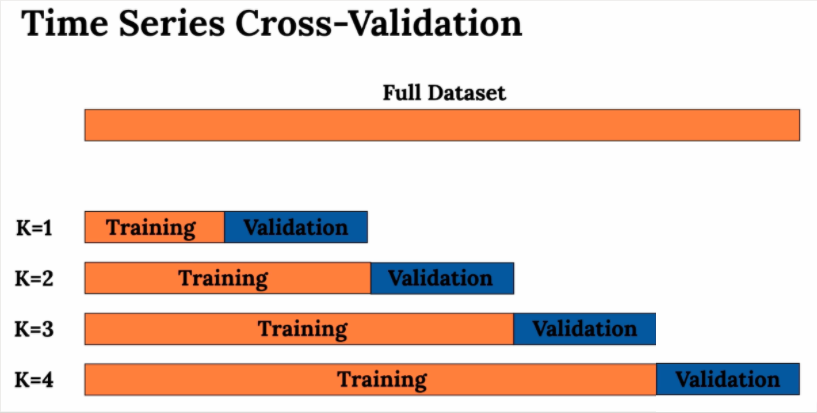

In [147]:
Image ('../img/time_series_cross_validation.png')

In [506]:
#Apenas para tareafs envolvendo time series, em função do kfold.
def cross_validation( x_training, kfold , model_name, model, verbose=False):
    """Calcula a performance real de um modelo passado via parâmetro.
    model recebe o modelo já instanciado.
    Passo só os dados de treino, e irá dividir o dataset em treino e validação 
         conforme o número de divisões passado via 'kfoln'.
    Irá a partir disso criar os datasets de validação de 6 semanas a cada iteração.
    Irá então treinar o modelo passado, e o modelo fará a previsão de vendas.
    Irá então chamar a função ml_erros, que calcula o erro do modelo.
    Retorna a performance real do modelo (erros: 'MAE','MAPE','RMSE') ± 1 std."""
    
    mae_list = []
    mape_list = []
    rmse_list = []

    k = 1
    for k in reversed (range(1,kfold+1) ):
        
        validation_start_date = x_training['date'].max() - dt.timedelta( days=k*6*7 ) 
        validation_end_date = x_training['date'].max() - dt.timedelta( days=(k-1)*6*7 )

        training = x_training[x_training['date'] < validation_start_date ]
        validation = x_training[ (x_training['date'] >= validation_start_date) & ( x_training['date'] <= validation_end_date) ]

        if verbose: 
            print('\nKFold Number: ',k)
            print('kFold training start date: ',training['date'].min() )
            print('kFold training end date: ',training['date'].max() )
            print('kFold validation start date: ',validation_start_date)
            print('kFold validation end date: ',validation_end_date)
            
        
        #training and validation dataset:
        # vou excluir agora as colunas date e sales para treino e validação:  
        xtraining = training.drop( ['date','sales'], axis=1 )#features
        ytraining = training['sales']#variável resposta            
        xvalidation = validation.drop( ['date','sales'], axis=1 ) #features
        yvalidation = validation['sales']#variável resposta

        #model training (sobre os dados de treino)
        m = model.fit( xtraining, ytraining )

        #model prediction (sobre os dados de validação)
        yhat = m.predict ( xvalidation )

        #performance
        m_result = ml_error ( model_name, np.expm1(yvalidation), np.expm1(yhat) )

        #store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] ) 

    #cria dicionário calculando a média e std de cada erro, 
    #e já retorna um df pronto com a performance do modelo no formato: (erro ± 1 std):
    return pd.DataFrame ( {
        'Model Nme': model_name,
        'MAE CV': np.round(np.mean( mae_list),2 ).astype( str ) + ' ± ' + np.round(np.std( mae_list),2 ).astype( str ),
        'MAPE CV': np.round(np.mean( mape_list),2 ).astype( str ) + ' ± ' + np.round(np.std( mape_list),2 ).astype( str ),
        'RMSE CV': np.round(np.mean( rmse_list),2 ).astype( str ) + ' ± ' + np.round(np.std( rmse_list),2 ).astype( str ) }, index=[0] )

In [ ]:
Testando a função acima para uma Linear Regression:

In [507]:
model = LinearRegression()
#model = Lasso( alpha=0.01 )
#model = RandomForestRegressor (n_estimators=100, n_jobs=-1, random_state=42 )
#model = xgb.XGBRegressor( objective='reg:squarederror', n_estimators=100, eta=0.01, subsample=0.7, colsample_bytee=0.9 )

a = cross_validation( x_training, 5, 'Linear Regression', model, True)


KFold Number:  5
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2014-11-19 00:00:00
kFold validation start date:  2014-11-20 00:00:00
kFold validation end date:  2015-01-01 00:00:00

KFold Number:  4
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2014-12-31 00:00:00
kFold validation start date:  2015-01-01 00:00:00
kFold validation end date:  2015-02-12 00:00:00

KFold Number:  3
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-02-11 00:00:00
kFold validation start date:  2015-02-12 00:00:00
kFold validation end date:  2015-03-26 00:00:00

KFold Number:  2
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-03-25 00:00:00
kFold validation start date:  2015-03-26 00:00:00
kFold validation end date:  2015-05-07 00:00:00

KFold Number:  1
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-05-06 00:00:00
kFold validation start date:  2015-05-07 00:00:0

Dataframe já com o resultado real de performance (erro) e desvio padrão:

In [150]:
a

,Model Nme,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1440.51 ± 231.33,0.19 ± 0.01,3536.63 ± 703.2


Agora, voltamos em cada modelo e complementamos a avaliação de performance, chamando a função de cross validation que retorna a performance real.

Vamos seguir de Random Search, porque é mais rápida pra implementar nesse treinamento, pode ser usada pra qualquer algoritmo. 

## Random Search

Definimos que vamos seguir com o XGBoost como modelo. Copiei o bloco dele lá do Machine Learning Modeling, mas tirei o treinamento (.fit), pois já está contemplado na função de cross validation. 
Agora, vamos aplicar a estratégia de Random Search nele:

In [744]:
#Cria dicionário com possíveis valores para os parâmetros.
#Pra definir, é melhor colocar valores mais espassados, para que com menos iterações, tenha 
    #resultados mais variados. 
param = {
    'n_estimators':[500,2000,3500], #1500,2500,3500 quando deixar rodar, senão 15,17
    'eta':[0.01,0.3], 
    'max_depth':[3,5,9], 
    'subsample':[0.1,0.5,0.7],
    'colsample_bytree':[0.3,0.7,0.9],
    'min_child_weight':[3,8,15] }

max_eval = 3 #5 quando deixar rodando, senão 2

Vai rodar abaixo o número de iterações preenchido em 'max_eval' acima, pegando dados aleatórios do dicionário 'param':

In [745]:
final_result = pd.DataFrame()

#Pra escolher aleatoriamente, usar um for:
for i in range ( max_eval ):
    #obtém para cada hp['parametro'], valores aleatórios a cada iteração: (detalhado no snippet abaixo)
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print( hp ) #printa pra ver quais valores foram escolhidos na iteração
    
    #model
    model_xgb = xgb.XGBRegressor( 
            objective = 'reg:squarederror', #função objetiva
            n_estimators = hp['n_estimators'], #quantas árvores vai criar (fica legal com umas 3k arvores: leva horas)
            eta = hp['eta'], #quantas passadas usa pra fazer o aprendizado
            max_depth = hp['max_depth'], #máxima ramificação da árvore
            subsample = hp['subsample'], #% das variáveis de amostra pra selecionar as relevantes
            colsample_bytree = hp['colsample_bytree'],
            min_child_weight = hp['min_child_weight'] )

    #performance: já faço o cross validation
                                        #kfold é 5, 2 pra teste!!
    result = cross_validation( x_training, 5 , 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat( [final_result, result] )
    
final_result

{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 2000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}


,Model Nme,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,481.0 ± 44.78,0.07 ± 0.0,674.54 ± 69.41
0,XGBoost Regressor,352.85 ± 40.31,0.05 ± 0.0,505.87 ± 64.99
0,XGBoost Regressor,584.23 ± 55.19,0.08 ± 0.0,814.77 ± 78.98


### Detalhamento do for acima: 
hp = { k: random.sample(v, 1)[0] for k, v in param.items() }

In [721]:
for k, v in param.items():
    print (k)
    print (v)

n_estimators
[15, 17]
eta
[0.01, 0.3]
max_depth
[3, 5, 9]
subsample
[0.1, 0.5, 0.7]
colsample_bytree
[0.3, 0.7, 0.9]
min_child_weight
[3, 8]


In [725]:
random.sample(v, 1)[0]

8

In [731]:
hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
hp

{'n_estimators': 17,
 'eta': 0.01,
 'max_depth': 3,
 'subsample': 0.5,
 'colsample_bytree': 0.9,
 'min_child_weight': 3}

## Final Model

Tendo os melhores valores de configuração sido descobertos pelo fine tuning, preencho eles abaixo.

Se duas linhas tiverem resultados muito parecidos, priorizar o de menor 'n_estimators', pois ele consome bastante tempo pra rodar o modelo.

In [518]:
#completa no dicionário o melhor conjunto de parâmetros da tabela acima
param_tuned = {
    'n_estimators':3500, 
    'eta':0.01, 
    'max_depth':9, 
    'subsample':0.1,
    'colsample_bytree':0.9,
    'min_child_weight':15
}

Rodo agora uma última vez a XGBoost, com os parametros acima.
Incluo o .fit pra treinar o modelo agora sobre os dados de treino.
Modelo prevê com .predict sobre os dados de teste (das últimas 6 semanas).
Calcula o erro passando as vendas reais de teste, e a predição do modelo tunada.

-> Aqui, é o mesmo processo que foi feito na avaliação de Single Performance.

In [519]:
#correto - sem customer
x_train.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos
41396,1,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41397,2,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41398,3,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41399,4,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41400,5,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969


In [520]:
#correto - sem customer
x_test.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521
3,4,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521


In [517]:
y_train.head()

41396    8.443762
41397    8.547722
41398    8.927712
41399    9.091669
41400    8.502080
Name: sales, dtype: float64

In [521]:
#terceira vez - sem o customer(correto)

#treinar modelo
model_xgb_tuned = xgb.XGBRegressor( 
        objective = 'reg:squarederror', #função objetiva
        n_estimators = param_tuned['n_estimators'], #quantas árvores vai criar (fica legal com umas 3k arvores: leva horas)
        eta = param_tuned['eta'], #quantas passadas usa pra fazer o aprendizado
        max_depth = param_tuned['max_depth'], #máxima ramificação da árvore
        subsample = param_tuned['subsample'], #% das variáveis de amostra pra selecionar as relevantes
        colsample_bytree = param_tuned['colsample_bytree'],
        min_child_weight = param_tuned['min_child_weight'] ).fit( x_train, y_train )

#predição do modelo
yhat_xgb_tuned_pred = model_xgb_tuned.predict( x_test )

#performance - medição
    #recebe nome do modelo, valores reais de venda, e predições de venda
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned_pred) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,671.832732,0.099097,980.321871


In [182]:
#segunda vez!!!

#treinar modelo
model_xgb_tuned = xgb.XGBRegressor( 
        objective = 'reg:squarederror', #função objetiva
        n_estimators = param_tuned['n_estimators'], #quantas árvores vai criar (fica legal com umas 3k arvores: leva horas)
        eta = param_tuned['eta'], #quantas passadas usa pra fazer o aprendizado
        max_depth = param_tuned['max_depth'], #máxima ramificação da árvore
        subsample = param_tuned['subsample'], #% das variáveis de amostra pra selecionar as relevantes
        colsample_bytree = param_tuned['colsample_bytree'],
        min_child_weight = param_tuned['min_child_weight'] ).fit( x_train, y_train )

#predição do modelo
yhat_xgb_tuned_pred = model_xgb_tuned.predict( x_test )

#performance - medição
    #recebe nome do modelo, valores reais de venda, e predições de venda
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned_pred) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,326.979554,0.04737,500.572558


In [522]:
#Modelo sem Customer:
model_xgb_tuned

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             eta=0.01, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.00999999978,
             max_delta_step=0, max_depth=9, min_child_weight=15, missing=nan,
             monotone_constraints='()', n_estimators=3500, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [524]:
#Modelo sem Customer: (olhando as colunas que contém)
cols_when_model_builds_2 = model_xgb_tuned.get_booster().feature_names
cols_when_model_builds_2

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'month_cos',
 'month_sin',
 'day_cos',
 'day_sin',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_week_cos']

In [189]:
#Calcula o MPE:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned_pred ) )
mpe #0.002549255820470709 -> Predições estão sendo bem levemente subestimadas (MPE positivo)

0.002549255820470709

In [526]:
#salvar o modelo treinado num .pkl através do pickle, para guardar objetos (model_xgb_tuned está correto,
                                                                            #e agora sem o customer!)
pickle.dump(model_xgb_tuned, open ('../model/model_rossmann.pkl', 'wb') )

## Significados dos Erros:

Model Name	           MAE	      MAPE	       RMSE
XGBoost Regressor	326.979554	 0.04737	500.572558

-----------------------------------------

MAE
=> Erro absoluto médio.
Resultado do erro: 326.

Fórmula: É a diferença entre os valores preditos e reais: soma todos e divide pelo número de valores.
Significado: A cada predição de 6 semanas, eu erro em média ± R$326 por dia. 

-----------------------------------------
MAPE
=> Erro absoluto médio em percentagem (complementar ao MAE). 
Resultado do erro: 0.047 (* 100 = 4,7% de erro). 

Fórmula: É a diferença % entre os valores preditos e reais:
    Vendo em média R$6.995 por dia. E pra cada predição para 6 semanas, tem um erro médio MAE de R$326 por dia. O cálculo do MAPE é: 326/6995 -> 4.7%.
    
Significado: A cada predição de 6 semanas, eu erro em média ± 4,7% na previsão total.
(Detalhamento nos snippets abaixo)


-----------------------------------------
RMSE
=> Raiz quadrada do erro médio (com outliers impactando mais que no MAE).
Resultado do erro: 501

Significado: A cada predição de 6 semanas, eu erro em média ± R$501 por dia. 

Usado como métrica de melhoria de performance do modelo, pois o outlier é um problema a ser resolvido no modelo.

RMSPE -> 501/6995 => 7,1% (A cada predição de 6 semanas, eu erro em média ± 7,1%)

-----------------------------------------
MPE
=> Erro médio percentual.
Resultado do erro: 0.002.
Significado: Indica se as predições estão sendo subestimadas (MPE positivo) ou superestimadas (MPE negativo).

Não serve para calcular a performance do modelo.
Só calcular na hora que tá avaliando o modelo final, antes é inútil.
(Detalhamento e cálculo nos snippets abaixo)

----------------------------------------------------------------------------------


#### Detalhamento MAPE

Cálculo do mínimo, máximo e range da variável resposta:

In [199]:
#valor mínimo de vendas
#np.expm1 porque está na escala de log, pra voltar ao normal
np.expm1(y_test).min()

569.0000000000002

In [200]:
#valor máximo de vendas
np.expm1(y_test).max()

41550.99999999998

In [201]:
#range: diferença
np.expm1(y_test).max() - np.expm1(y_test).min()

40981.99999999998

Tenho uma variação (range) de faturamento diário de R$40.981
Meu MAE é de R$326, bem pequeno comparado a variação.

Olhando para a média de vendas do nosso ds de teste, temos faturamento médio/dia de R$6.995
Dividindo o erro absoluto MAE abaixo de 326/6995, temos 0.047 (4,7%) de erro!

In [202]:
#media
np.expm1(y_test).mean() 

6995.162576094309

In [203]:
326/6995

0.04660471765546819

#### Detalhamento e cálculo MPE

In [188]:
def mean_percentage_error (y, yhat):
    return np.mean( ( y - yhat ) / y )

Calcular MPE:

In [198]:
mpe = mean_percentage_error( np.expm1(y_test), np.expm1 (yhat_xgb_tuned_pred) )
mpe

0.002549255820470709

MPE positiva -> está subestimando as vendas.
MPE negativa -> está superestimando as vendas.
Logo, nosso valor predito tende a ser levemente menor que o valor real (quase insignificante)

## Business Performance

In [209]:
#ler do pickle o modelo salvo (yhat_xgb_tuned_pred), caso precise rodar novamente tudo:
model_rossmann_trained = pickle.load( open( '../model/model_rossmann_trained.pkl', 'rb') )
model_rossmann_trained

array([8.558933, 8.674219, 9.045819, ..., 8.845809, 9.966608, 9.038229],
      dtype=float32)

In [210]:
#pega todas as colunas selecionadas pelo boruta, mais sales e date, em cols_selected_boruta_full
df9 = X_test[ cols_selected_boruta_full ].copy()

#rescale - voltar pra escala original, pra calcular na mesma eslaca
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned_pred )

In [212]:
df9.shape

(41396, 24)

In [213]:
df9.head()

,store,customers,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos,date,sales,predictions
0,1,555,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,5263.0,5212.117188
1,2,625,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,6064.0,5849.129883
2,3,821,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,8314.0,8481.999023
3,4,1498,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,13995.0,12298.015625
4,5,559,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,4822.0,5500.965332


In [214]:
#Save CSV:
df9.to_csv('../data/9_business_performance.csv', index=False) #index=False if I have first columns as index, to avoid saving with the unnamed:0. Don't save the index, and won't have column unnamed:0 created nor problem to load it.
#no import needed, no message will appear.

In [285]:
# soma de predições de vendas por loja (que é como programamos mostrar para o CFO)
df91 = df9 [['store','predictions']].groupby( 'store' ).sum().reset_index()

#MAE e MAPE - calcula pra cada loja
df9_aux1 = df9 [['store', 'sales', 'predictions']].groupby ('store').apply ( 
    lambda x: mean_absolute_error(x['sales'], x['predictions'] ) ).reset_index().rename( columns= {0:'MAE'} )

df9_aux2 = df9 [['store', 'sales', 'predictions']].groupby ('store').apply ( 
    lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'] ) ).reset_index().rename( columns= {0:'MAPE'} )

#merge MAE e MAPE
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
#merge pervisões por loja com MAE e MAPE 
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

In [286]:
#Scenarios
#wrong:
###df92['worst_scenario'] = df92['predictions'] - df92['MAE']
###df92['best_scenario'] = df92['predictions'] + df92['MAE']

#right:
df92['worst_scenario'] = ( df92['predictions'] - ( df92['predictions'] * df92['MAPE'] ) )
df92['best_scenario'] = ( df92['predictions'] + ( df92['predictions'] * df92['MAPE'] ) )

#order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [287]:
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,164277.406250,158637.759696,169917.052804,147.124076,0.034330
1,2,188158.640625,171394.904058,204922.377192,444.759620,0.089094
2,3,242345.468750,228823.281410,255867.656090,392.216071,0.055797
3,4,360634.312500,347310.636424,373957.988576,374.570497,0.036945
4,5,169207.281250,160776.253888,177638.308612,232.318076,0.049827


Previsão de Receira para as próximas 6 semanas:

In [240]:
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1099,1100,174196.734375,163745.993828,184647.474922,340.142176,0.059994
762,763,226434.453125,217460.615785,235408.290465,244.036172,0.039631
727,728,200109.500000,191753.536039,208465.463961,228.450400,0.041757
1081,1082,238104.203125,231946.649885,244261.756365,165.916735,0.025861
444,445,330800.875000,309512.282290,352089.467710,555.972551,0.064355


Análise da Loja 1099: 

predictions - R$174.196 de receita para as próximas 6 semanas.
MAE - Significado: A cada predição de 6 semanas, eu erro em média ± R$340 por dia. 
MAPE- Significado: A cada predição de 6 semanas, eu erro em média ± 6% na previsão total da loja.
worst_scenario: R$174.196 - 6%
best_scenario: R$174.196 + 6%

In [289]:
#olhar as lojas com maior erro MAPE:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
908,909,280816.906250,223531.623483,338102.189017,3868.195843,0.203995
875,876,210955.390625,176441.137124,245469.644126,2423.291875,0.163609
291,292,102586.757812,86738.850400,118434.665225,2084.580990,0.154483
721,722,320780.031250,271469.319334,370090.743166,1121.189875,0.153721
303,304,281206.156250,240995.301119,321417.011381,910.778294,0.142994


In [346]:
#olhar as lojas com menor erro MAPE:
df92.sort_values('MAPE', ascending=True).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
393,394,323601.125000,315493.144772,331709.105228,232.881110,0.025055
1081,1082,238104.203125,231946.649885,244261.756365,165.916735,0.025861
1042,1043,298590.812500,290861.343003,306320.281997,216.020204,0.025886
958,959,265133.000000,258261.372502,272004.627498,169.739634,0.025918
522,523,501860.937500,488808.781661,514913.093339,356.700169,0.026008


Plotar as previsões de vendas de cada loja:

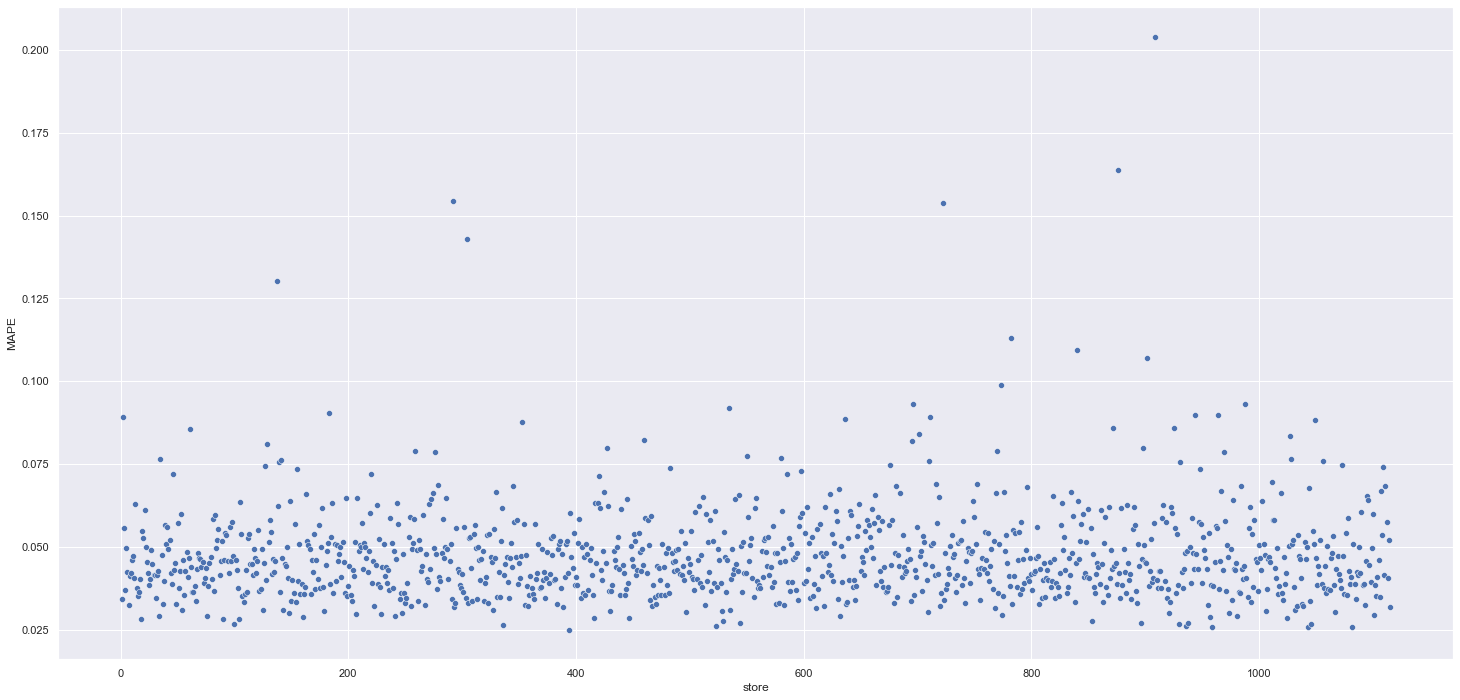

In [243]:
sns.scatterplot( x='store', y='MAPE', data=df92 );

Notamos acima que a maioria das lojas tem um erro MAPE entre 2,5 e 7,5%.

## Total Performance

Resumir o pior e melhor cenário pra todas as lojas

In [291]:
    #axis=0 - somas das colunas
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply (lambda x: np.sum( x ), axis=0).reset_index().rename( columns={'index': 'Scenario', 0: 'Values' } )
df93['Values'] = df93['Values'].map( '$ {:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"$ 286,958,912.00"
1,worst_scenario,"$ 273,620,969.02"
2,best_scenario,"$ 300,296,882.75"


Melhorando a exibição, por loja:

In [354]:
df94 = df92.copy()

In [355]:
# formata valores monetários em dólares
df94['predictions'] = df94['predictions'].map( '$ {:,.2f}'.format )
df94['worst_scenario'] = df94['worst_scenario'].map( '$ {:,.2f}'.format )
df94['best_scenario'] = df94['best_scenario'].map( '$ {:,.2f}'.format )
df94['MAE'] = df94['MAE'].map( '$ {:,.2f}'.format )

#renomeia colunas MAE e MAPE
df94 = df94.rename( columns= {'MAE':'mean_abs_error', 'MAPE':'mean_abs_perc_error'} )
#traz o erro para o formato: x,xx 
df94['mean_abs_perc_error'] = df94['mean_abs_perc_error'].apply( lambda x: round(x*100,2) ) 

In [356]:
df94.head()

,store,predictions,worst_scenario,best_scenario,mean_abs_error,mean_abs_perc_error
0,1,"$ 164,277.41","$ 158,637.76","$ 169,917.05",$ 147.12,3.43
1,2,"$ 188,158.64","$ 171,394.90","$ 204,922.38",$ 444.76,8.91
2,3,"$ 242,345.47","$ 228,823.28","$ 255,867.66",$ 392.22,5.58
3,4,"$ 360,634.31","$ 347,310.64","$ 373,957.99",$ 374.57,3.69
4,5,"$ 169,207.28","$ 160,776.25","$ 177,638.31",$ 232.32,4.98


## Machine Learning Performance

Olhar em formato gráfico como as vendas se comportam nas 6 semanas previstas (vendas e erros na linha do tempo, muito interessante!)

In [245]:
#colunas usadas pra construir os gráficos
df9['error'] = df9['sales'] - df9['predictions'] 
df9['error_rate'] = df9['predictions'] / df9['sales'] 

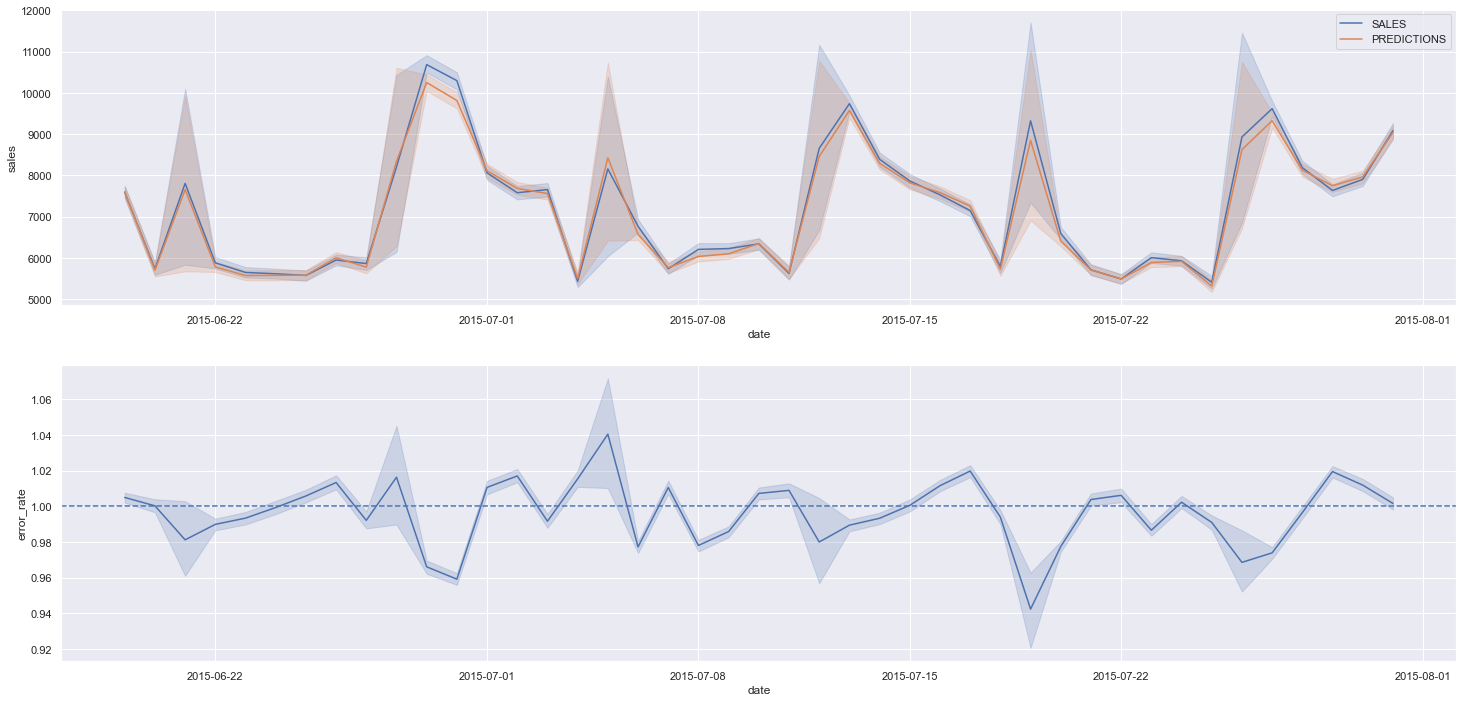

In [254]:
#Nas 6 semanas em que prevemos as vendas: 
    #Vendas reais x vendas previstas pelo GXBoost por dia:
    #A sombra em laranja é a variancia, valor que varia de loja por loja.
    #Notamos que a predição ao longo do tempo está bem próxima das vendas ao longo do tempo.
plt.subplot( 2,1,1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' );
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' );

#Nas 6 semanas em que prevemos as vendas: 
    #Taxa de erros por dia:
    #Quando for = 1, tenho a previsão perfeita.
    #Se variação acima do 1, são dias onde modelo superestimou vendas (predição > venda).
plt.subplot( 2,1,2 )
sns.lineplot( x='date', y='error_rate', data=df9);
plt.axhline( 1, linestyle='--');

In [359]:
df94.head(5)

,store,predictions,worst_scenario,best_scenario,mean_abs_error,mean_abs_perc_error
0,1,"$ 164,277.41","$ 158,637.76","$ 169,917.05",$ 147.12,3.43
1,2,"$ 188,158.64","$ 171,394.90","$ 204,922.38",$ 444.76,8.91
2,3,"$ 242,345.47","$ 228,823.28","$ 255,867.66",$ 392.22,5.58
3,4,"$ 360,634.31","$ 347,310.64","$ 373,957.99",$ 374.57,3.69
4,5,"$ 169,207.28","$ 160,776.25","$ 177,638.31",$ 232.32,4.98


/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


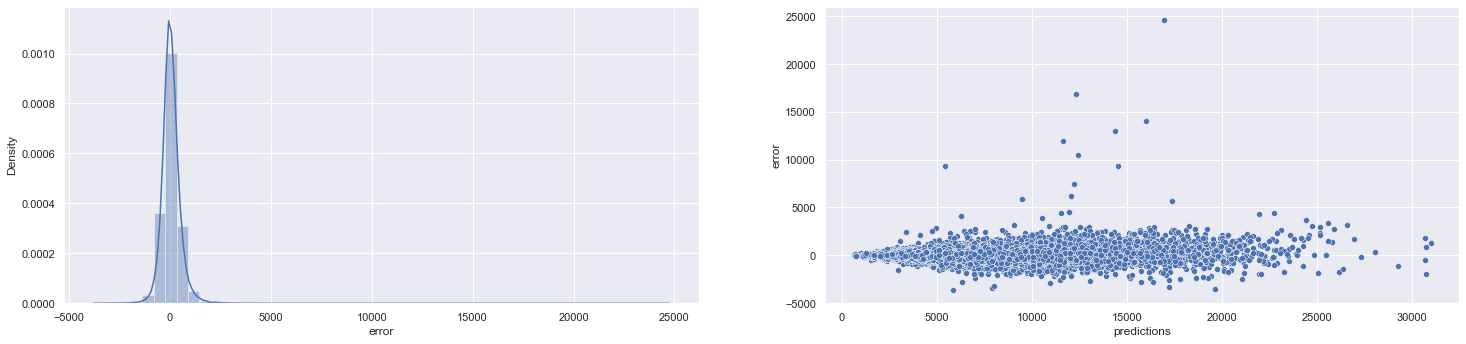

In [256]:
#Plotar a distribuição do erro, para ver se é parecida com uma normal.
    #Se for, isso é bem positivo, é usado para análise do resíduo.
    #Análise de resíduo: aborda quais pontos fracos tem o modelo, para que possa trabalhar nas 
        #melhorias dele.
plt.subplot( 2,2,1 )
sns.distplot( df9['error'] );

#Plotar o gráfico de resíduo.
    #Mostra que previsões entre 10 e 15k de vendas tem erros um pouco maiores que nas demais 
       #faixas, por exemplo. Mas é bem leve, está muito bom. O gráfico precisa ficar dentro de um
       #tubo horizontal, como está o nosso, com alguns outliers é normal, como temos.
    #É usado também para análise do resíduo.
plt.subplot( 2,2,2 )
sns.scatterplot( df9['predictions'], df9['error'] );